# Import bibliotek

In [228]:
import os
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff
import random
from scipy import stats
from sklearn.linear_model import LinearRegression
from statistics import NormalDist
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# Klasa do wykresów

In [206]:
class Plots:
    def __init__(self):
        pass

    def check_data(self, data):
        if not isinstance(data, pd.DataFrame) and not isinstance(data, pd.Series) and not isinstance(data, np.ndarray):
            raise TypeError('Wrong type of data. It should be pandas DataFrame, pandas Series or numpy arra.')
        data = np.array(data)
        if(data.ndim == 2):
            data = data.squeeze()
        return data
    
    def check_2d_data(self, data):
        if not isinstance(data, pd.DataFrame) and not isinstance(data, pd.Series) and not isinstance(data, np.ndarray):
            raise TypeError('Wrong type of data. It should be pandas DataFrame, pandas Series or numpy array.')
        return np.array(data)
    
    def hist_plot(self, data, name="", bin_size=1):
        data = self.check_data(data=data)
        fig = go.Figure()
        fig.add_trace(go.Histogram(x=data, showlegend=False, name=name, marker=dict(color='blue'), xbins=dict(size=bin_size)))
        fig.update_layout(template="simple_white", width=800, height=800, title=f"<b>{name}<b>", title_x=0.5, xaxis_title="Wartość", yaxis_title="Liczebność", font=dict(family="Times New Roman",size=16,color="Black"))
        fig.show("png")
    
    def histogram_and_box_plot(self, data, name="", annotation=["Min","Q1","Med","Q3","Max"]):
        data = self.check_data(data=data)
        fig = make_subplots(rows=1, cols=2, specs=[[{"type": "histogram"}, {"type": "box"}]])
        fig.add_trace(go.Box(y=data, name='', marker=dict(color="rgb(48,70,116)"), showlegend=False), row=1, col=1)
        fig.add_trace(go.Histogram(x=data, marker=dict(color="rgb(48,70,116)"), showlegend=False), row=1, col=2)
        for x in zip(["Min","Q1","Med","Q3","Max"], np.quantile(data, [0, 0.25, 0.5, 0.75, 1])):
            if(x[0] in annotation):
                fig.add_annotation(x=0.4, y=x[1], text=x[0] + ": " + str(np.round(x[1], 3)), showarrow=False)
        fig.update_layout(template="simple_white", width=1600, height=800, title=f"<b>{name.title()} distribution<b>", title_x=0.5, font=dict(family="Times New Roman",size=16,color="Black"))
        fig.show("png")
    
    def pie_and_bar_plot(self, data, name=""):
        data = self.check_data(data=data)
        rows = 1
        columns = 2
        labels, frequency = np.unique(data, return_counts=True)
        colors = px.colors.qualitative.Plotly
        fig = make_subplots(rows=rows, cols=columns, specs=[[{"type": "pie"}, {"type": "bar"}] for i in range(0, rows)])
        fig.add_trace(go.Pie(values=frequency, labels=labels, showlegend=True, textinfo='value+percent', hole=0.3, marker=dict(line=dict(color='black', width=2), colors=colors)), row=1, col=1)
        fig.add_trace(go.Bar(x=labels, y=frequency, marker=dict(line=dict(color='black', width=1), color=colors), showlegend=False), row=1, col=2)
        fig.update_layout(template="simple_white", width=1600, height=800, title=f"<b>Pie chart and bar chart {name.title()}<b>", title_x=0.5, font=dict(family="Times New Roman",size=16,color="Black"))
        fig.show("png")
    
    def boxplot_by_categorical(self, data, categorical, target):
        fig = make_subplots(rows=1, cols=2, specs=[[{"type": "box"}, {"type": "histogram"}] for i in range(0, 1)])
        labels, frequency = np.array([0,1]), np.array(data[categorical].value_counts().values)
        colors = px.colors.qualitative.Plotly
        for color_idx, category in enumerate(labels):
            indices = np.where(data[categorical]==category)[0]
            grouped_data = data[target][indices]
            fig.add_trace(go.Box(y=grouped_data, name=str(category), marker=dict(color=colors[color_idx]), showlegend=True), row=1, col=1)
            fig.add_trace(go.Histogram(x=grouped_data, marker=dict(color=colors[color_idx]), showlegend=False), row=1, col=2)
        fig.update_layout(template="simple_white", width=1600, height=800, title=f"<b>Wykres pudełkowy {target} dla kategorii zmiennej {categorical}<b>", title_x=0.5, font=dict(family="Times New Roman",size=16,color="Black"))
        fig.show("png")
    
    def linear_regression_plot(self, data, feature, target):
        model = LinearRegression()
        no_nan_indices = ~data[feature].isna()
        model.fit(data[no_nan_indices][feature].values.reshape(-1, 1), data[no_nan_indices][target])
        predictions = model.predict(data[no_nan_indices][feature].values.reshape(-1, 1))
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=data[no_nan_indices][feature], y=data[no_nan_indices][target], mode='markers', name='Real values'))
        fig.add_trace(go.Scatter(x=data[no_nan_indices][feature], y=predictions, mode='lines', line_color="green", name='Expected values'))
        fig.add_traces(go.Scatter(x=data[no_nan_indices][feature], y=predictions, mode='lines', line_color = 'rgba(0,0,0,0)', showlegend=False))
        fig.update_layout(template="simple_white", width=1600, height=800, title_text=f"<b>Linear regression between {feature} and {target}<b>", title_x=0.5, xaxis_title=feature, yaxis_title=target, font=dict(family="Times New Roman",size=16,color="Black"))
        fig.show("png")
    
    def correlation_plot(self, data, features_names):
        data = self.check_data(data=data)
        data = pd.DataFrame(data, columns=features_names)
        corr = np.round(data[data.columns.tolist()].corr(method='pearson'), 3)
        mask = np.triu(np.ones_like(corr, dtype=bool))
        data_mask = corr.mask(mask)
        fig = ff.create_annotated_heatmap(z=data_mask.to_numpy(), x=data_mask.columns.tolist(), y=data_mask.columns.tolist(), colorscale=px.colors.diverging.RdBu,hoverinfo="none", showscale=True, ygap=1, xgap=1)
        fig.update_xaxes(side="bottom")
        fig.update_layout(width=1600, height=1600, xaxis_showgrid=False,yaxis_showgrid=False,xaxis_zeroline=False,yaxis_zeroline=False,yaxis_autorange='reversed',template='plotly_white',font=dict(family="Times New Roman",size=12,color="Black"))
        for i in range(len(fig.layout.annotations)):
            if fig.layout.annotations[i].text == 'nan':
                fig.layout.annotations[i].text = ""
        fig.show("png")

plots = Plots()

# Ładowanie danych

In [144]:
parent_dir = os.path.dirname(os.getcwd())
data = pd.read_csv('data.csv')
data.reset_index(drop=True, inplace=True)
data=data.drop(columns=['Unnamed: 0'])
data

title_author  pages  \
0                      Gravity by Tal Bauer    273   
1           Every Last Secret by A.R. Torre    302   
2         Black Cake by Charmaine Wilkerson    400   
3                   Treason by Timothy Zahn    459   
4                   Eric by Terry Pratchett    160   
...                                     ...    ...   
8915             Inkheart by Cornelia Funke    535   
8916  Little Fires Everywhere by Celeste Ng    368   
8917                  Lies by Michael Grant    472   
8918                    Emma by Jane Austen    574   
8919       Gente Ansiosa by Fredrik Backman    350   

                                                  genre  stars  reviews  \
0     ['fiction', 'contemporary', 'lgbtqia+', 'roman...   4.00     2017   
1                               ['fiction', 'thriller']   3.78     7330   
2                 ['fiction', 'historical', 'literary']   4.15    16761   
3             ['fiction', 'fantasy', 'science fiction']   4.16     2128   
4                                ['fiction', 'fantasy']   3.65     6634   
...                                                 ...    ...      ...   
8915             ['fiction', 'fantasy', 'middle grade']   3.88    30975   
8916            ['fiction', 'contemporary', 'literary']   4.08   102789   
8917  ['fiction', 'dystopian', 'science fiction', 'y...   3.88     5914   
8918     ['fiction', 'classics', 'literary', 'romance']   3.99    63694   
8919  ['fiction', 'contemporary', 'literary', 'myste...   4.27    67909   

      series     mix  character    plot   funny  ...  inspiring  relaxing  \
0          0  0.0044     0.0051  0.0002  0.0027  ...     0.0035    0.0007   
1          0  0.0039     0.0042  0.0017  0.0003  ...     0.0000    0.0000   
2          0  0.0051     0.0039  0.0008  0.0002  ...     0.0028    0.0001   
3          1  0.0048     0.0010  0.0040  0.0004  ...     0.0003    0.0001   
4          1  0.0028     0.0016  0.0054  0.0092  ...     0.0001    0.0008   
...      ...     ...        ...     ...     ...  ...        ...       ...   
8915       1  0.0045     0.0008  0.0045  0.0014  ...     0.0018    0.0005   
8916       0  0.0040     0.0050  0.0008  0.0003  ...     0.0009    0.0001   
8917       1  0.0064     0.0012  0.0022  0.0007  ...     0.0000    0.0000   
8918       0  0.0022     0.0072  0.0004  0.0070  ...     0.0007    0.0029   
8919       0  0.0037     0.0056  0.0005  0.0074  ...     0.0035    0.0005   

       tense     sad  reflective  adventurous  challenging  informative  \
0     0.0021  0.0012      0.0011       0.0010       0.0007       0.0001   
1     0.0063  0.0005      0.0003       0.0007       0.0009       0.0000   
2     0.0010  0.0034      0.0066       0.0024       0.0018       0.0011   
3     0.0050  0.0000      0.0008       0.0095       0.0015       0.0005   
4     0.0000  0.0000      0.0004       0.0083       0.0000       0.0001   
...      ...     ...         ...          ...          ...          ...   
8915  0.0020  0.0005      0.0003       0.0096       0.0005       0.0000   
8916  0.0031  0.0023      0.0061       0.0008       0.0022       0.0002   
8917  0.0075  0.0022      0.0006       0.0073       0.0028       0.0000   
8918  0.0001  0.0000      0.0022       0.0004       0.0006       0.0001   
8919  0.0006  0.0021      0.0055       0.0008       0.0007       0.0001   

      mysterious    dark  
0         0.0000  0.0000  
1         0.0080  0.0068  
2         0.0043  0.0010  
3         0.0057  0.0020  
4         0.0004  0.0001  
...          ...     ...  
8915      0.0049  0.0022  
8916      0.0047  0.0018  
8917      0.0050  0.0086  
8918      0.0001  0.0000  
8919      0.0026  0.0007  

[8920 rows x 23 columns]

# Definicja zmiennych

## title_author

$\text{Zmienna przedstawiająca tytuł i autora książki.}$<p>
$\text{Poniżej sprawdzono czy zmienna zawiera unikalne wartości.}$

In [57]:
print("Zmienna title_author posiada wartości unikalne: {}".format(len(data["title_author"].value_counts()) == len(data)))

Zmienna title_author posiada wartości unikalne: False


$\text{Niektóre książki występują w danych kilkukrotnie, co ma związek z tym, że na stronie, z której scrapowano dane, książki były dostępne w różnych edycjach.}$<p>
$\text{Poniżej przedstawiono przykład, książki posiadają tą samą wartość title_author, ale różnią się chociażby liczbą stron.}$

In [88]:
data.loc[data["title_author"] == data["title_author"].value_counts().index[0]]

title_author  pages  \
983   Happy Place by Emily Henry    388   
2124  Happy Place by Emily Henry    388   
5250  Happy Place by Emily Henry    388   
6777  Happy Place by Emily Henry    391   
7939  Happy Place by Emily Henry    385   

                                       genre  stars  reviews  series     mix  \
983   ['fiction', 'contemporary', 'romance']   4.16    71882       0  0.0026   
2124  ['fiction', 'contemporary', 'romance']   4.16    71837       0  0.0026   
5250  ['fiction', 'contemporary', 'romance']   4.16    71887       0  0.0026   
6777  ['fiction', 'contemporary', 'romance']   4.16    71887       0  0.0026   
7939  ['fiction', 'contemporary', 'romance']   4.16    71869       0  0.0026   

      character    plot   funny  ...  inspiring  relaxing   tense    sad  \
983      0.0068  0.0004  0.0055  ...     0.0019    0.0014  0.0005  0.002   
2124     0.0068  0.0004  0.0055  ...     0.0019    0.0014  0.0005  0.002   
5250     0.0068  0.0004  0.0055  ...     0.0019    0.0014  0.0005  0.002   
6777     0.0068  0.0004  0.0055  ...     0.0019    0.0014  0.0005  0.002   
7939     0.0068  0.0004  0.0055  ...     0.0019    0.0014  0.0005  0.002   

      reflective  adventurous  challenging  informative  mysterious  dark  
983       0.0042       0.0007       0.0004          0.0         0.0   0.0  
2124      0.0042       0.0007       0.0004          0.0         0.0   0.0  
5250      0.0042       0.0007       0.0004          0.0         0.0   0.0  
6777      0.0042       0.0007       0.0004          0.0         0.0   0.0  
7939      0.0042       0.0007       0.0004          0.0         0.0   0.0  

[5 rows x 23 columns]

$\text{Zdecydowano się na usunięcie duplikatów ze zbioru danych.}$

In [145]:
data.drop_duplicates(subset="title_author", keep="first", inplace=True)
data.reset_index(drop=True, inplace=True)

$\text{Następnie rozdzielamy tytuł książki od nazwiska autora.}$

In [146]:
data_o=data["title_author"].str.rpartition(' by ')
data=data.join(data_o[2])
data=data.rename(columns={2: "author"})
data

title_author  pages  \
0                      Gravity by Tal Bauer    273   
1           Every Last Secret by A.R. Torre    302   
2         Black Cake by Charmaine Wilkerson    400   
3                   Treason by Timothy Zahn    459   
4                   Eric by Terry Pratchett    160   
...                                     ...    ...   
6925  Gestohlene Erinnerung by Blake Crouch    432   
6926     The Terraformers by Annalee Newitz    352   
6927             Inkheart by Cornelia Funke    535   
6928                  Lies by Michael Grant    472   
6929       Gente Ansiosa by Fredrik Backman    350   

                                                  genre  stars  reviews  \
0     ['fiction', 'contemporary', 'lgbtqia+', 'roman...   4.00     2017   
1                               ['fiction', 'thriller']   3.78     7330   
2                 ['fiction', 'historical', 'literary']   4.15    16761   
3             ['fiction', 'fantasy', 'science fiction']   4.16     2128   
4                                ['fiction', 'fantasy']   3.65     6634   
...                                                 ...    ...      ...   
6925         ['fiction', 'science fiction', 'thriller']   4.15    30643   
6926         ['fiction', 'lgbtqia+', 'science fiction']   3.62     1058   
6927             ['fiction', 'fantasy', 'middle grade']   3.88    30975   
6928  ['fiction', 'dystopian', 'science fiction', 'y...   3.88     5914   
6929  ['fiction', 'contemporary', 'literary', 'myste...   4.27    67909   

      series     mix  character    plot   funny  ...  relaxing   tense  \
0          0  0.0044     0.0051  0.0002  0.0027  ...    0.0007  0.0021   
1          0  0.0039     0.0042  0.0017  0.0003  ...    0.0000  0.0063   
2          0  0.0051     0.0039  0.0008  0.0002  ...    0.0001  0.0010   
3          1  0.0048     0.0010  0.0040  0.0004  ...    0.0001  0.0050   
4          1  0.0028     0.0016  0.0054  0.0092  ...    0.0008  0.0000   
...      ...     ...        ...     ...     ...  ...       ...     ...   
6925       0  0.0048     0.0005  0.0046  0.0000  ...    0.0000  0.0070   
6926       0  0.0055     0.0013  0.0030  0.0015  ...    0.0002  0.0013   
6927       1  0.0045     0.0008  0.0045  0.0014  ...    0.0005  0.0020   
6928       1  0.0064     0.0012  0.0022  0.0007  ...    0.0000  0.0075   
6929       0  0.0037     0.0056  0.0005  0.0074  ...    0.0005  0.0006   

         sad  reflective  adventurous  challenging  informative  mysterious  \
0     0.0012      0.0011       0.0010       0.0007       0.0001      0.0000   
1     0.0005      0.0003       0.0007       0.0009       0.0000      0.0080   
2     0.0034      0.0066       0.0024       0.0018       0.0011      0.0043   
3     0.0000      0.0008       0.0095       0.0015       0.0005      0.0057   
4     0.0000      0.0004       0.0083       0.0000       0.0001      0.0004   
...      ...         ...          ...          ...          ...         ...   
6925  0.0016      0.0032       0.0071       0.0034       0.0006      0.0058   
6926  0.0004      0.0038       0.0071       0.0030       0.0015      0.0006   
6927  0.0005      0.0003       0.0096       0.0005       0.0000      0.0049   
6928  0.0022      0.0006       0.0073       0.0028       0.0000      0.0050   
6929  0.0021      0.0055       0.0008       0.0007       0.0001      0.0026   

        dark               author  
0     0.0000            Tal Bauer  
1     0.0068           A.R. Torre  
2     0.0010  Charmaine Wilkerson  
3     0.0020         Timothy Zahn  
4     0.0001      Terry Pratchett  
...      ...                  ...  
6925  0.0052         Blake Crouch  
6926  0.0008       Annalee Newitz  
6927  0.0022       Cornelia Funke  
6928  0.0086        Michael Grant  
6929  0.0007      Fredrik Backman  

[6930 rows x 24 columns]

## pages

$\text{Zmienna przedstawia liczbę stron książki.}$

## genre

$\text{Wartości zmiennej to listy gatunków, do których należy książka.}$<p>
$\text{Ponieważ większość algorytmów uczenia maszynowego obsługuje jedynie zmienne numeryczne, należy przekształcić tę zmienną.}$<p>
$\text{W pierwszej kolejności zweryfikowano, jakie unikalne wartości (gatunki) występują wewnątrz list oraz ile ich jest.}$

In [147]:
genre_values = data["genre"].values
genres_list = [eval(genres) for genres in genre_values]
unique_genres = set([genre for genres in genres_list for genre in genres])
genre_count = {genre: 0 for genre in unique_genres}
for genres in genres_list:
    for genre in genres:
        genre_count[genre] += 1
print("Liczba książek w każdym gatunku: {}".format( dict(sorted(genre_count.items(), key=lambda item: item[1]))))
print("Liczbę unikalnych gatunków: {}".format(len(unique_genres)))

Liczba książek w każdym gatunku: {'cookbook': 1, 'mathematics': 1, 'design': 1, 'emotional': 1, 'computer science': 1, 'relaxing': 2, 'inspiring': 2, 'education': 3, 'funny': 3, 'lighthearted': 5, 'informative': 5, 'video games': 5, 'sad': 6, 'horror': 6, 'history': 6, 'technology': 7, 'reference': 9, 'food and drink': 10, 'mysterious': 11, 'economics': 14, 'reflective': 15, 'gender': 17, 'art': 19, 'travel': 25, 'religion': 27, 'music': 29, 'business': 32, 'nature': 35, 'autobiography': 41, 'health': 41, 'true crime': 41, 'play': 42, 'sociology': 45, 'tense': 55, 'erotica': 57, 'comics': 61, 'speculative fiction': 63, 'sports': 65, 'philosophy': 68, 'biography': 69, 'race': 75, 'manga': 76, 'childrens': 79, 'politics': 97, 'science': 98, 'self help': 98, 'psychology': 100, 'feminism': 102, 'essays': 112, 'poetry': 124, 'dystopian': 183, 'short stories': 221, 'middle grade': 221, 'magical realism': 223, 'crime': 236, 'memoir': 366, 'science fiction': 545, 'classics': 674, 'thriller': 6

$\text{Gatunków jest stosunkowo dużo, zatem potencjalne utworzenie zmiennych binarnych dla każdego gatunku mogłoby prowadzić do problemu związanego z dużą wymiarowością zbioru danych.}$<p>
$\text{Jak można jednak zauważyć, występują zbliżone do siebie tematycznie gatunki, które można połączyć w jedną kategorię.}$<p>
$\text{Przed grupowaniem należy zaznaczyć, że w kolumnie genre występują także wartości określające 'Mood', które są procentowo wyrażone w kolejnych kolumnach.}$<p>
$\text{Są to: emotional, funny, relaxing, sad, inspiring, reflective, mysterious, lighthearted, informative, tense. Tych kategorii nie uwzględniono w podziale gatunków}$<p>
$\text{Zdecydowano się na podział gatunków na 10 kategorii.}$<p>
$\qquad \text{1. Fiction: fiction }$<p> 
$\qquad \text{2. Nonfiction: nonfiction, art, cookbook, comics, design, manga, food and drink, self help, music, play, sports, travel, video games, health, business, computer science, economics, education, mathematics, science, nature, technology, reference. }$<p> 
$\qquad \text{3. Literary: classics, historical, history, literary, poetry, essays, short stories.}$<p>
$\qquad \text{4. Fantasy: dystopian, fantasy, magical realism, science fiction, speculative fiction.}$<p>
$\qquad \text{5. Crime: crime, horror, thriller, true crime, mystery.}$<p>
$\qquad \text{6. Social: politics, religion, psychology, sociology, philosophy, feminism, gender, lgbtqia+,  race.}$<p>
$\qquad \text{7. Children: childrens, middle grade, young adult.}$<p>
$\qquad \text{8. Romans: erotica, romance.}$<p>
$\qquad \text{9. Realism: autobiography, biography, memoir, contemporary.}$<p>

$\text{Zostaną utworzone zmienne binarne dla każdej z wyżej wymienionych kategorii.}$<p>
$\text{Zatem przykładowo dla obserwacji, która posiada w zmiennej genre wartość ['fiction', 'thriller'], to w kolumnie 'Fiction' i 'Crime' będą wartości 1, a w pozostałych 0.}$

In [148]:
genres_dictionary_mapper = {"Fiction": ["fiction"] ,
"Nonfiction": ["nonfiction","art", "cookbook", "comics","design", "manga", "food and drink","music", "play", "sports","travel", "video games",
                  "health","business", "computer science", "economics", "education", "mathematics", "science", "nature", "technology", "reference"],
"Literary": ["classics",  "historical", "history", "literary", "poetry", "essays", "short stories"],
"Fantasy": ["dystopian", "fantasy", "magical realism", "science fiction", "speculative fiction"],
"Crime": ["crime", "horror", "thriller", "true crime", "mystery"],
"Social": ["religion","politics","psychology", "sociology", "self help", "philosophy", "feminism", "gender","lgbtqia+",  "race"],
"Children": ["childrens", "middle grade", "young adult"],
"Romans": ["erotica", "romance"],
"Realism": ["autobiography", "biography", "memoir", "contemporary"],
}

#Utworzenie słownika genres, który będzie przechowywał gatunki/nazwy nowo tworzonych kolumn binarych (klucze) oraz indeksy obserwacji, które zawierają dany gatunek (wartości)
genres = {key: [] for key in genres_dictionary_mapper.keys()}
for obs_idx, list in enumerate(genres_list):
    for genre in list:
        for key, value in genres_dictionary_mapper.items():
            if genre in value:
                genres[key].append(obs_idx)
#Utworzenie nowych kolumn binarnych na podstawie słownika genres
for key, value in genres.items():
    data[key] = 0
    data.loc[value, key] = 1

$\text{Teraz w każdej kategorii gatunków jest następująca liczba ksiązek:}$<p>

In [149]:
data[['Fiction', 'Nonfiction', 'Literary', 'Fantasy','Crime',
       'Social', 'Children', 'Romans', 'Realism']].sum()

Fiction       5994
Nonfiction    1172
Literary      2442
Fantasy       2427
Crime         1162
Social        1298
Children      1498
Romans        1475
Realism       1858
dtype: int64

$\text{W celu weryfikacji wybierzmy kilka obserwacji i sprawdźmy czy prawidłowo przypisano im kategorie.}$

In [150]:
data.loc[random.sample(range(len(data)), 5), ["genre",'Fiction', 'Nonfiction', 'Literary', 'Fantasy','Crime',
       'Social', 'Children', 'Romans', 'Realism']]

genre  Fiction  Nonfiction  \
3266  ['fiction', 'crime', 'historical', 'literary',...        1           0   
523   ['fiction', 'contemporary', 'lgbtqia+', 'magic...        1           0   
3733  ['fiction', 'contemporary', 'lgbtqia+', 'roman...        1           0   
4010              ['fiction', 'historical', 'literary']        1           0   
112                  ['fiction', 'mystery', 'thriller']        1           0   

      Literary  Fantasy  Crime  Social  Children  Romans  Realism  
3266         1        0      1       0         0       0        0  
523          0        1      0       1         1       0        1  
3733         0        0      0       1         0       1        1  
4010         1        0      0       0         0       0        0  
112          0        0      1       0         0       0        0

$\text{Ponieważ w nowo utworzonych kolumnach mamy już informację o gatunkach, zmienna genre nie jest już potrzebna i zostanie usunięta.}$

In [151]:
data.drop(columns=["genre"], inplace=True)

## stars

$\text{Zmienna celu przedstawiająca ocenę książki.}$

## reviews

$\text{Zmienna ciągła informująca o liczbie recenzji książki.}$

## series

$\text{Zmienna binarna informująca czy książka jest częścią serii (1) czy nie (0).}$

## mix, plot, character

$\text{Zmienne informujące o tym czy książka jest bardziej oparta na fabule (plot), postaciach (character) czy jest to mieszanka obu (mix).}$<p>
$\text{Zmienne przyjmują wartości z przedział [0, 0.01], zatem pierwszym krokiem będzie ich przemnożenie przez 100.}$

In [152]:
data["mix"] = data["mix"]*100
data["plot"] = data["plot"]*100
data["character"] = data["character"]*100

$\text{Następnie zweryfikujmy jak wygląda rozkład sumy tych zmiennych}$

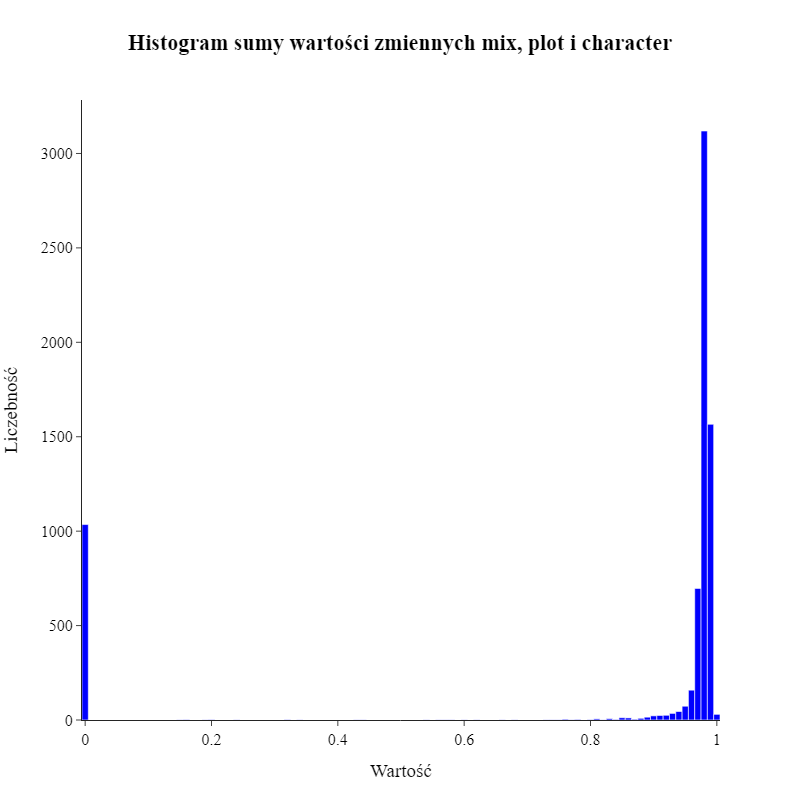

In [153]:
plots.hist_plot((data["mix"] + data["plot"] + data["character"]), name="Histogram sumy wartości zmiennych mix, plot i character", bin_size=0.01)

$\text{Dla większości obserwacji suma jest zbliżona do 1 (niedokładność wynika z błędu zaokrąglenia na stronie internetowej).}$<p>
$\text{Znajduje się jednak wiele takich obserwacji, dla których suma wynosi 0, gdyż książki non-fiction nie są oparte na fabule ani postaciach.}$<p>

## Zmienne Moods

$\text{Kolejne zmienne w zbiorze danych to wartości procentowe określające nastroje książki.}$<p>
$\text{Są to kolejno:}$<p>
$\qquad \text{- funny,}$<p>
$\qquad \text{- lighthearted,}$<p>
$\qquad \text{- emotional,}$<p>
$\qquad \text{- hopeful,}$<p>
$\qquad \text{- inspiring,}$<p>
$\qquad \text{- relaxing,}$<p>
$\qquad \text{- tense,}$<p>
$\qquad \text{- sad,}$<p>
$\qquad \text{- reflective,}$<p>
$\qquad \text{- adventurous,}$<p>
$\qquad \text{- challenging,}$<p>
$\qquad \text{- informative,}$<p>
$\qquad \text{- mysterious,}$<p>
$\qquad \text{- dark.}$<p>
$\text{Podobnie jak w przypadku zmiennych mix, plot oraz character, w celu łatwiejsze interpretacji wartości zostaną przemnożone przez 100.}$

In [154]:
moods = ['funny', 'lighthearted', 'emotional', 'hopeful', 'inspiring', 'relaxing', 'tense', 'sad', 'reflective', 'adventurous', 'challenging', 'informative', 'mysterious', 'dark']
for mood in moods:
    data[mood] = data[mood]*100

# Podstawowe informacje o zbiorze danych

In [155]:
def base_information(data):
    df =  pd.DataFrame(data.dtypes, columns=['dtypes'])
    df['Number of missing values'] = data.isna().sum()
    df['Percentage of missing values'] = data.isna().sum()/data.shape[0]
    df['Unique values'] = data.nunique().values
    df['Count'] = data.count().values
    return df.style.background_gradient(cmap='Blues')
base_information(data)

$\text{W zbiorze danych nie występują braki wartości.}$<p>
$\text{Mamy zarówno zmienne kategoryczne jak i numeryczne, które umieścimy w dwóch osobnych zbiorach.}$

In [239]:
categorical_features = ['series', 'Fiction', 'Nonfiction', 'Literary', 'Fantasy','Crime',
       'Social', 'Children', 'Romans', 'Realism']
target = "stars"
continous_features = data.columns.difference(categorical_features + [target] + ["author","title_author"]).tolist()

# Wizualizacja zmiennych

## starts (zmienna celu)

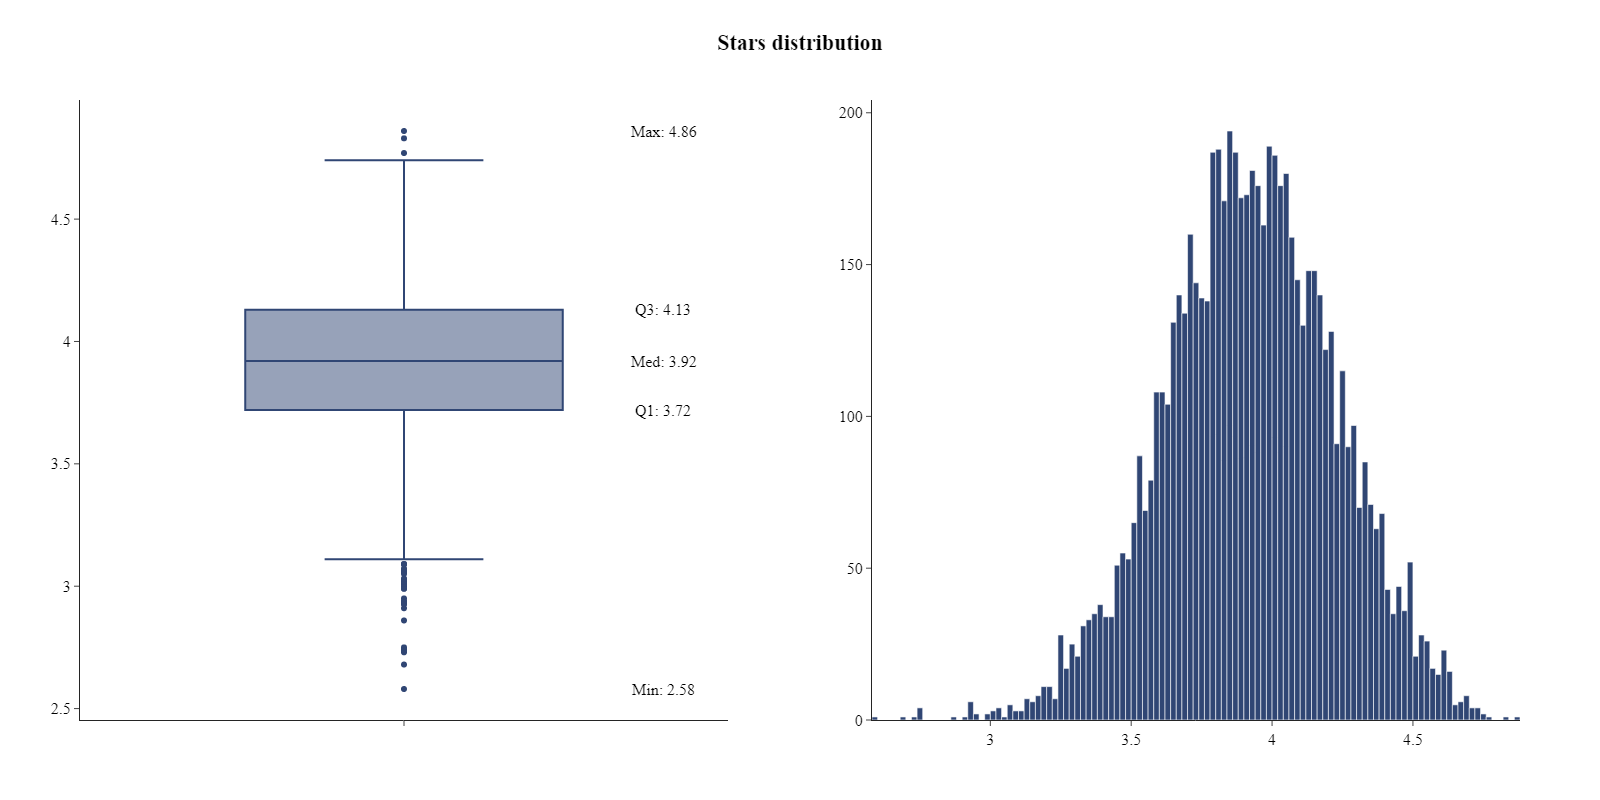

In [157]:
plots.histogram_and_box_plot(data[target], name="stars")

$\text{Rozkład zmiennej celu jest zbliżony do rozkładu normalnego.}$<p>
$\text{Mediana oscyluje w okolicach 4, a więcej wartości odstających znajduje się przy lewym ogonie rozkładu.}$

## Zmienne kategoryczne

### series

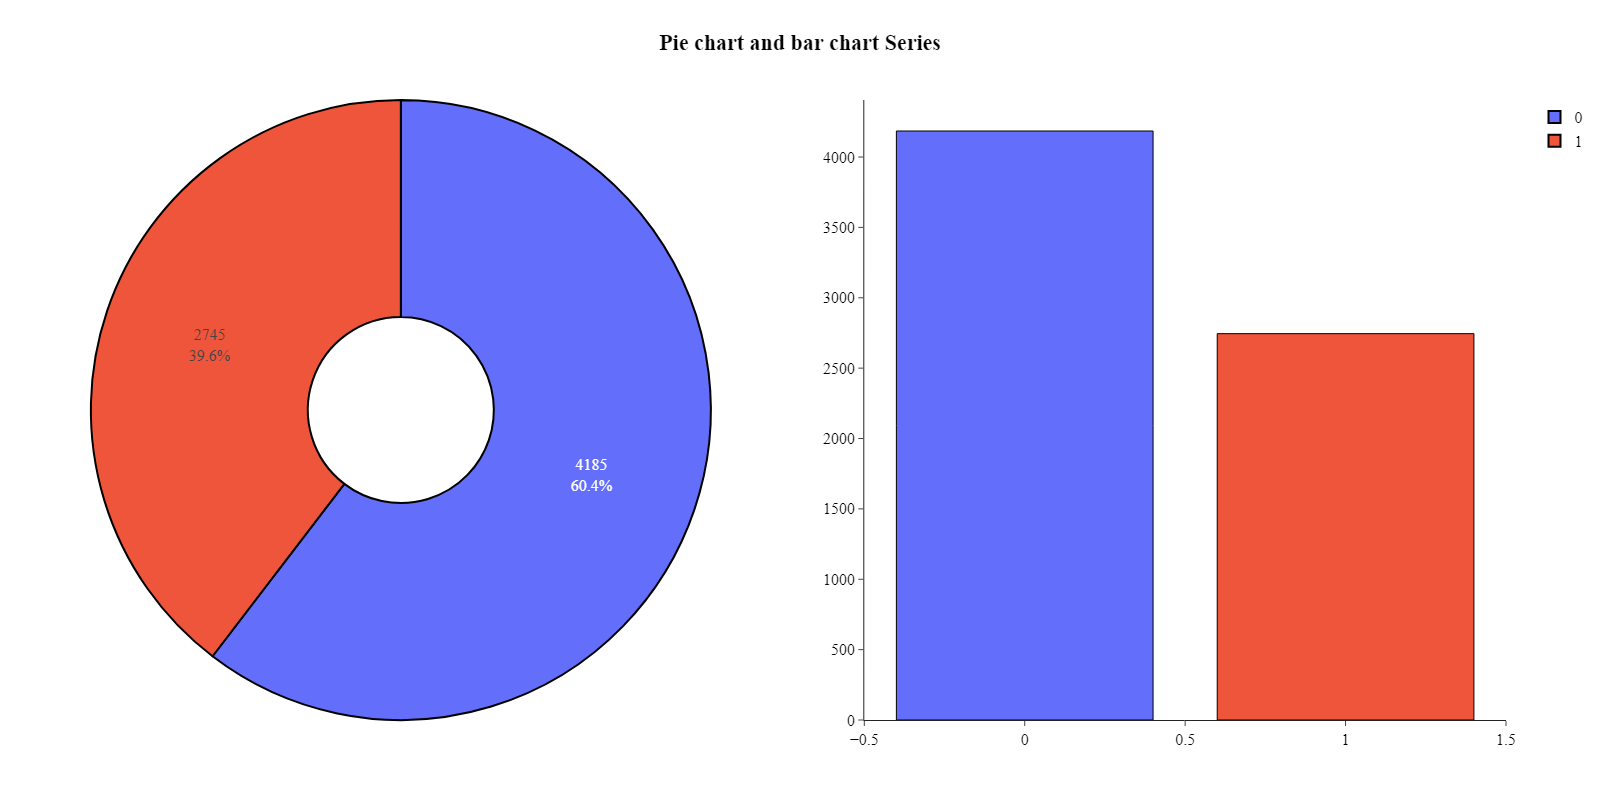

In [158]:
plots.pie_and_bar_plot(data["series"], name="series")

$\text{Większość książek (60%) nie jest częścią serii.}$

### Fiction

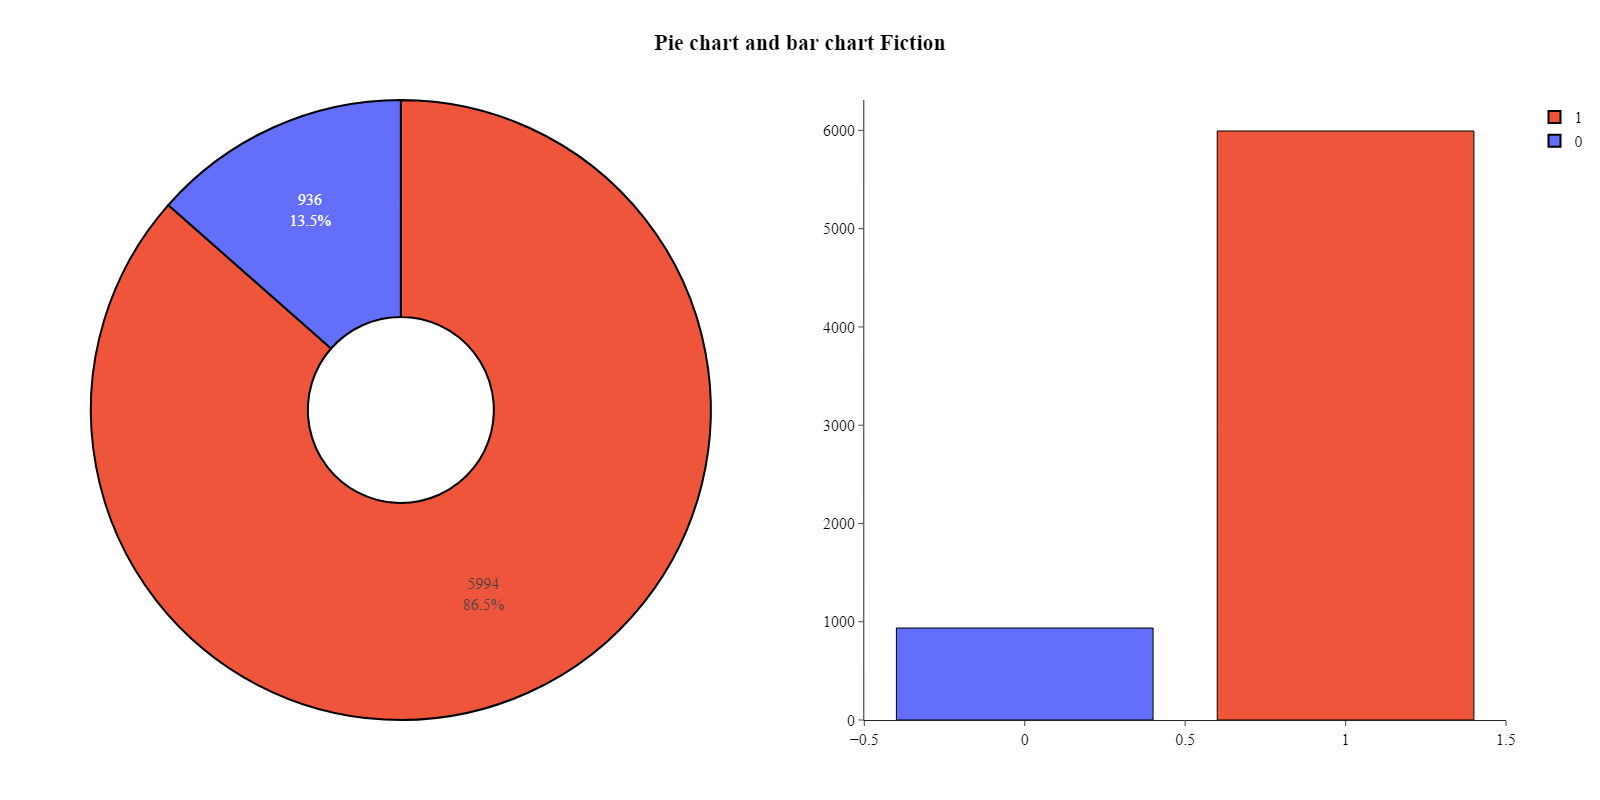

In [159]:
plots.pie_and_bar_plot(data['Fiction'], name='Fiction')

$\text{Przeważająca część książek należy do kategorii Fiction.}$

### Nonfiction

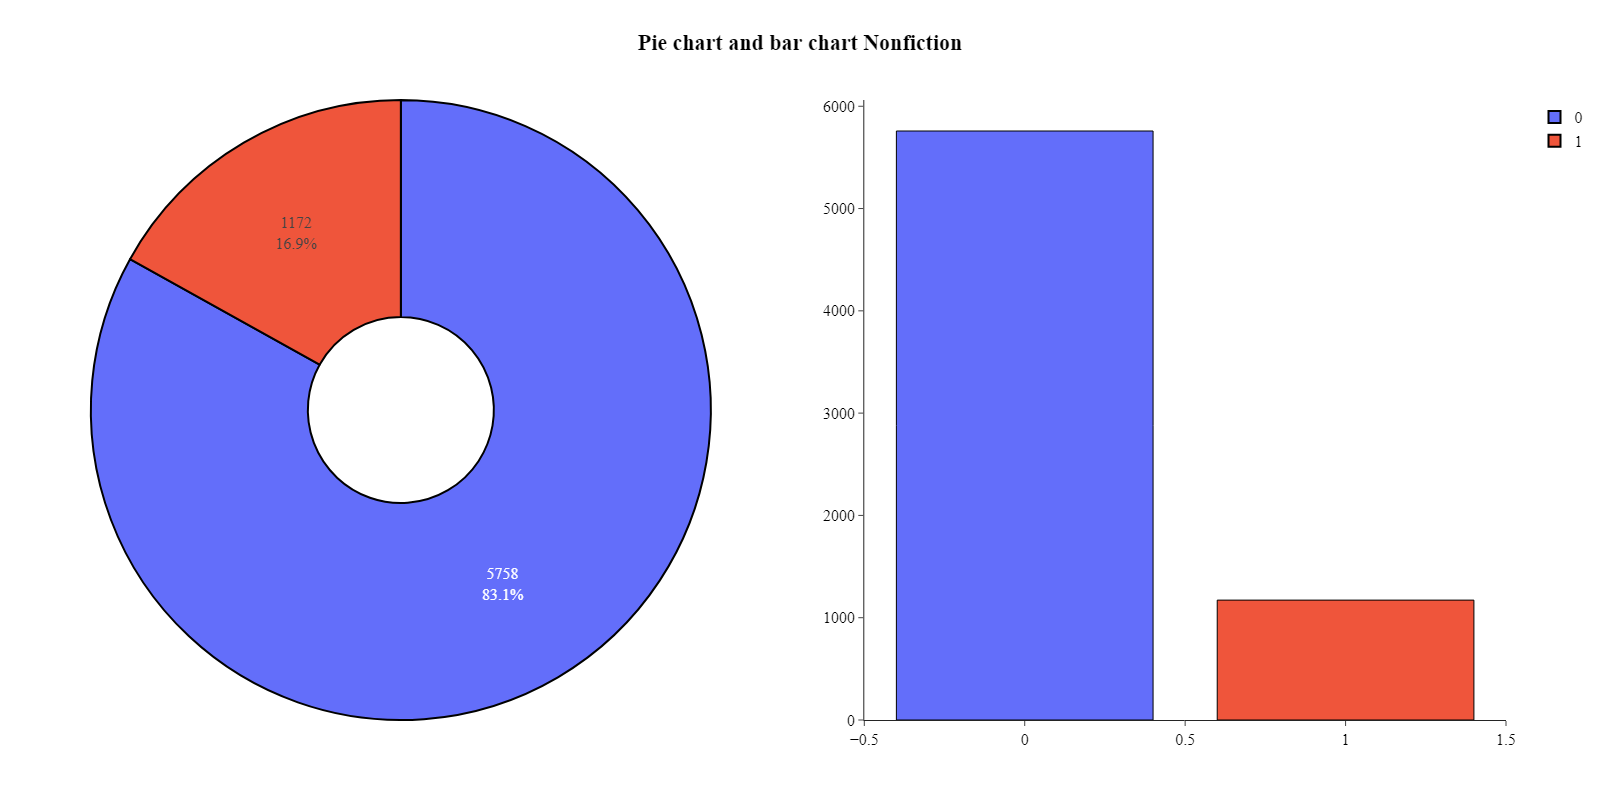

In [160]:
plots.pie_and_bar_plot(data['Nonfiction'], name='Nonfiction')

$\text{Mniejsza część książek należy do kategorii Nonfiction.}$

### Literary

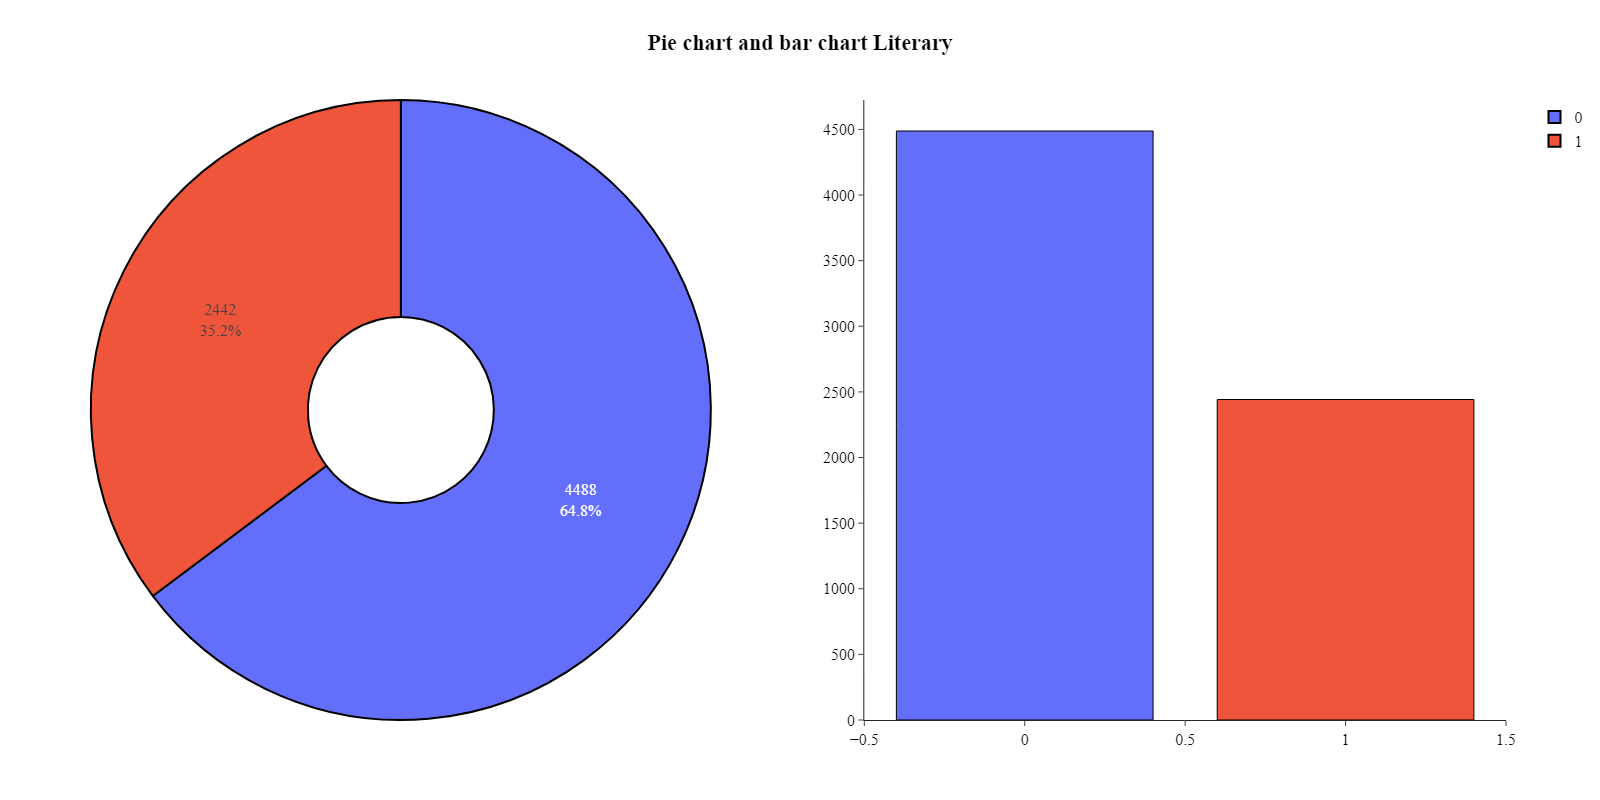

In [161]:
plots.pie_and_bar_plot(data['Literary'], name='Literary')

$\text{Około jedna trzecia książek należy do kategorii Literary}$

### Fantasy

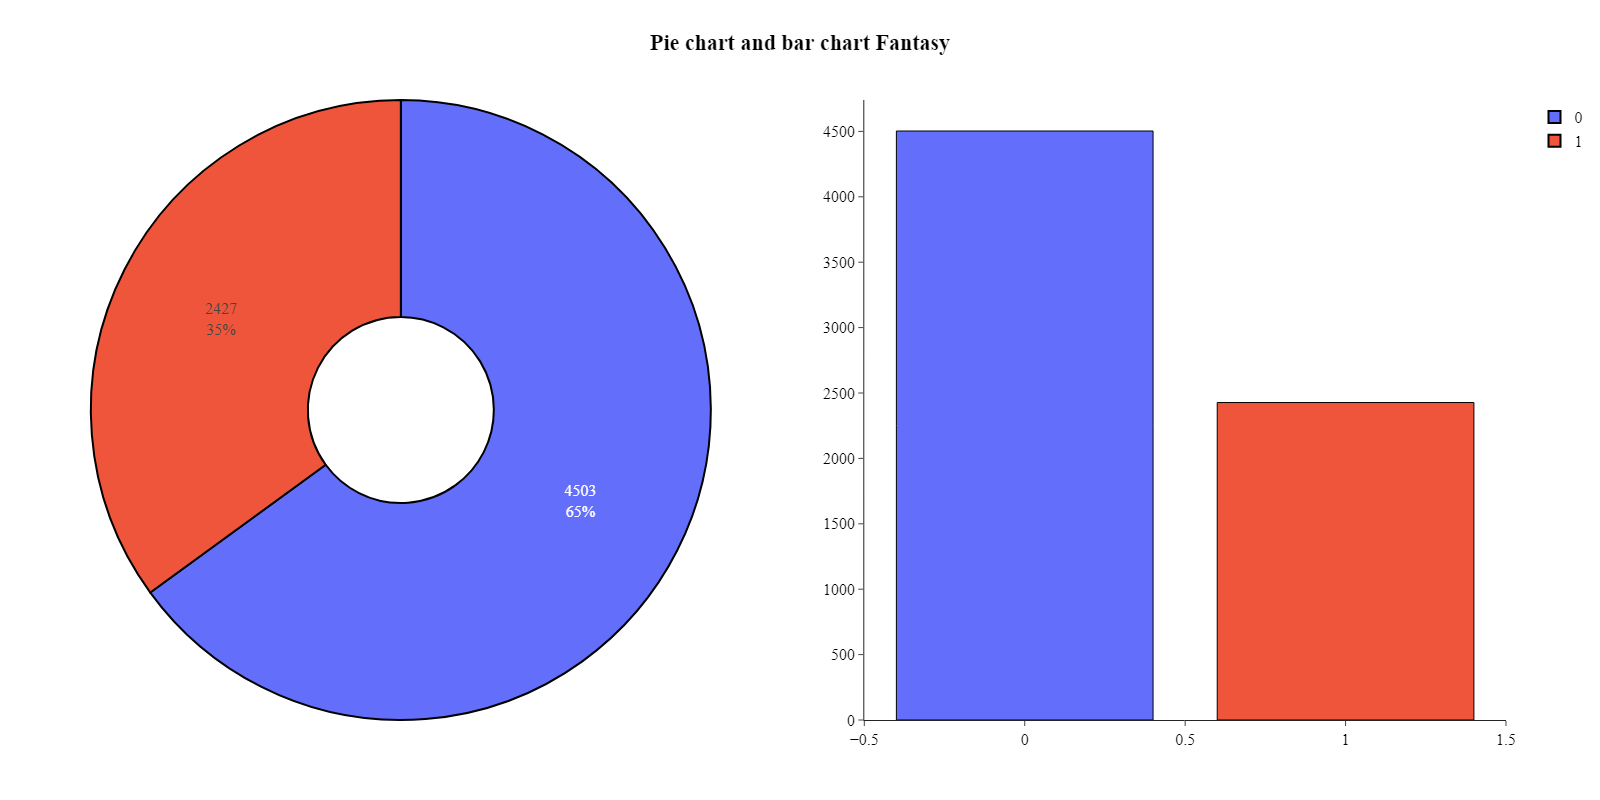

In [162]:
plots.pie_and_bar_plot(data['Fantasy'], name='Fantasy') 

$\text{Znów około jedna trzecia książek należy do kategorii Fantasy}$

### Realism

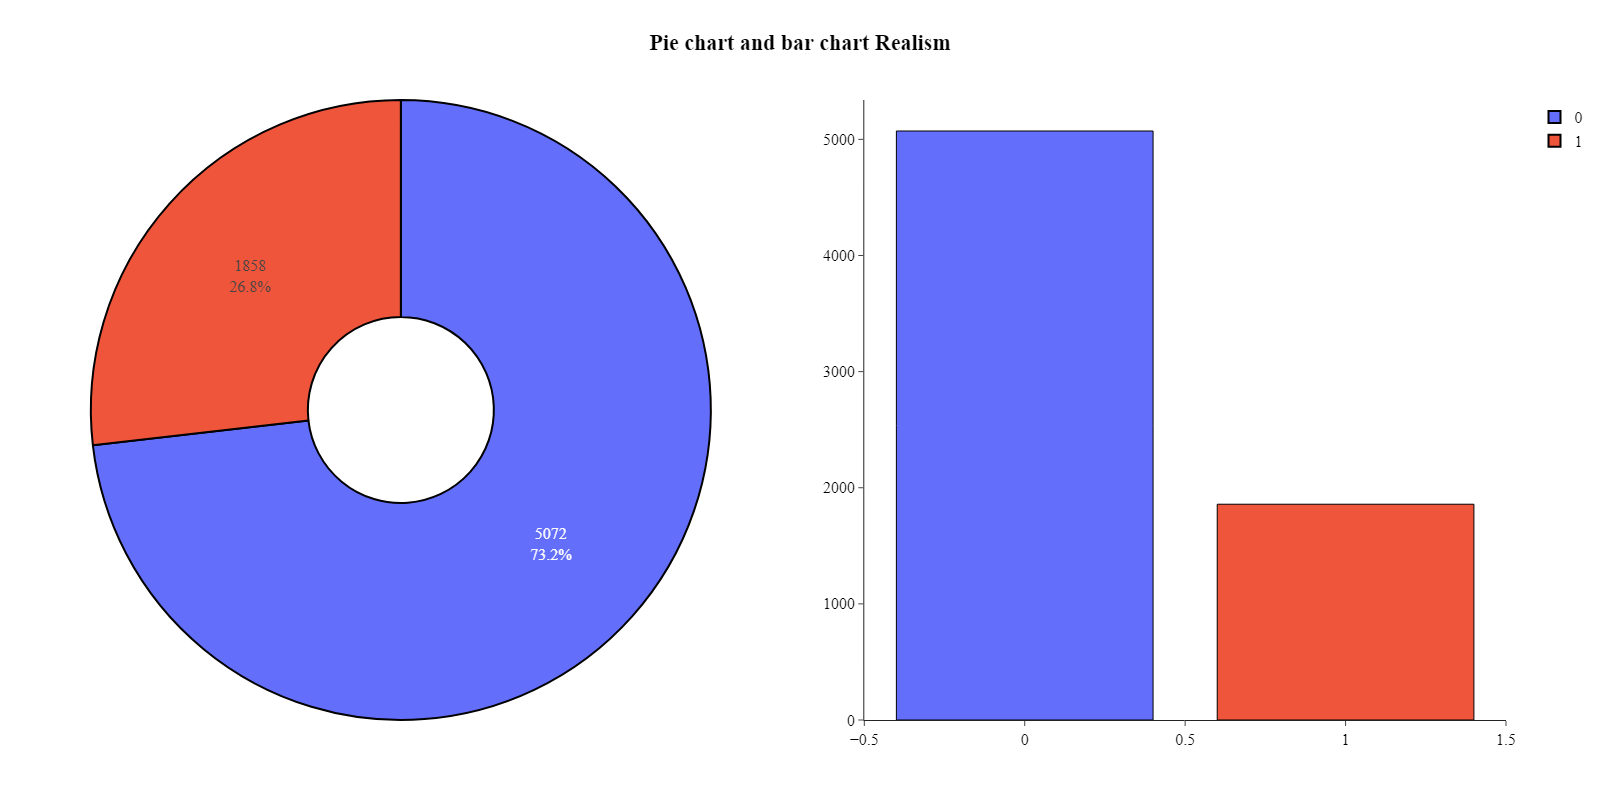

In [163]:
plots.pie_and_bar_plot(data['Realism'], name='Realism')

$\text{I znów około jedna trzecia książek należy do kategorii Realism.}$

### Crime

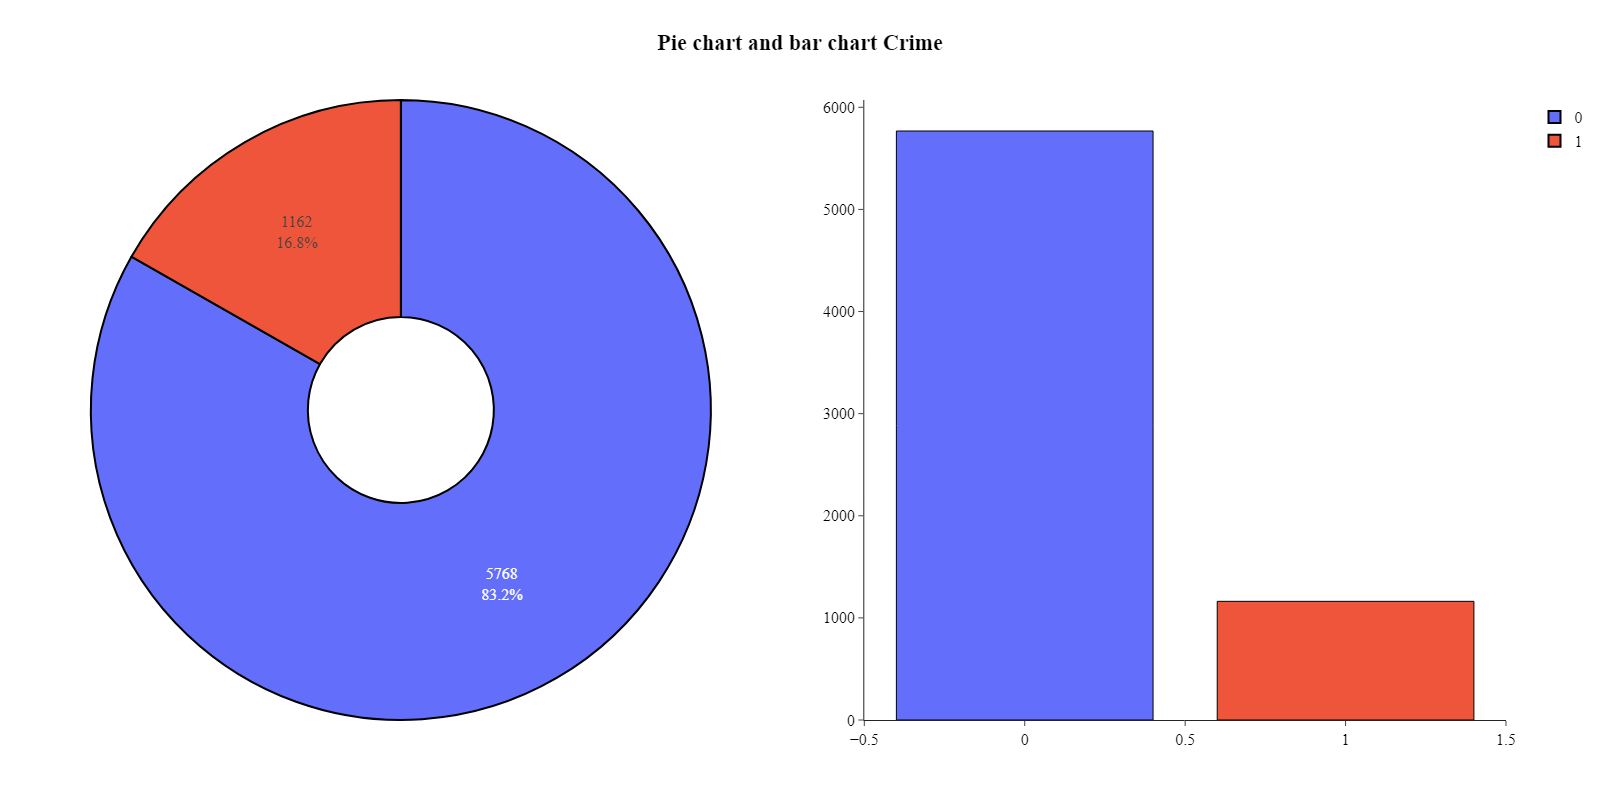

In [164]:
plots.pie_and_bar_plot(data['Crime'], name='Crime')

$\text{W tym przypadku około jedna szósta książek należy do kategorii Crime.}$

### Social

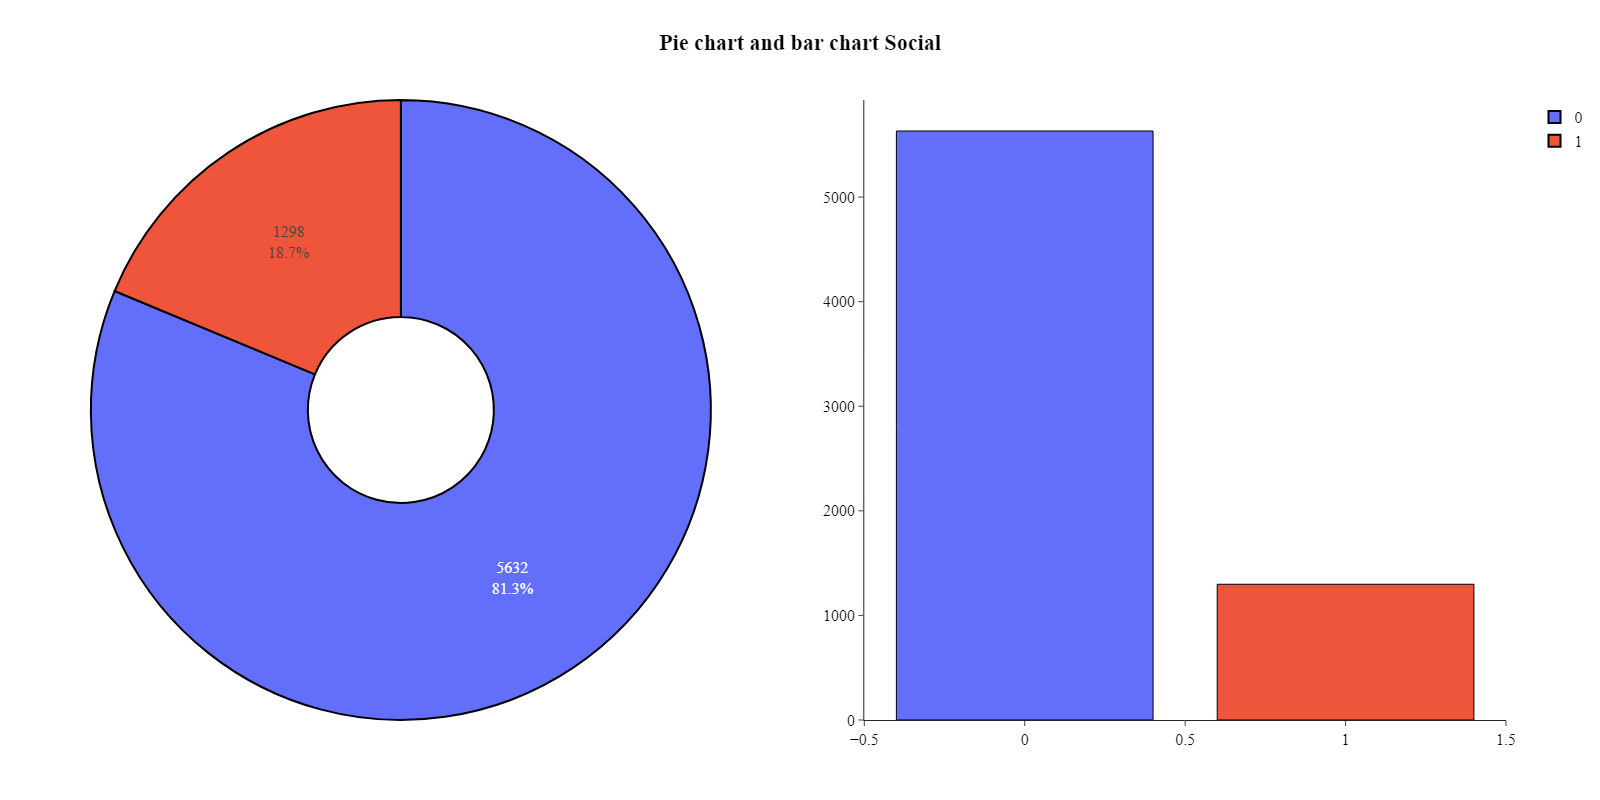

In [165]:
plots.pie_and_bar_plot(data['Social'], name='Social')

$\text{Około jedna piąta książek jest z kategorii Social.}$

### Children

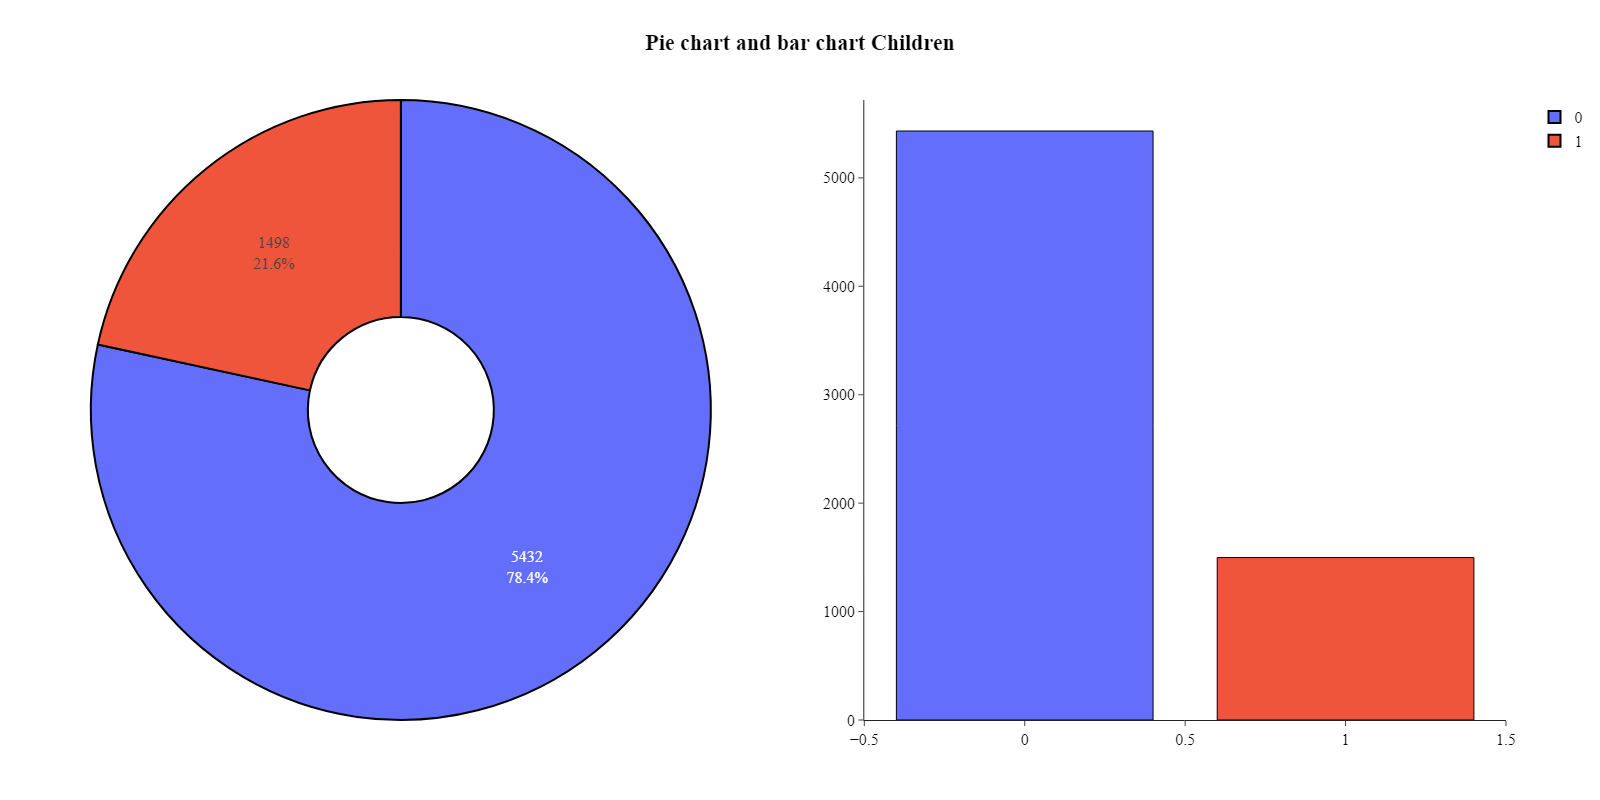

In [166]:
plots.pie_and_bar_plot(data['Children'], name='Children')

$\text{Znów około jedna piąta książek jest z kategorii Children.}$

### Romans

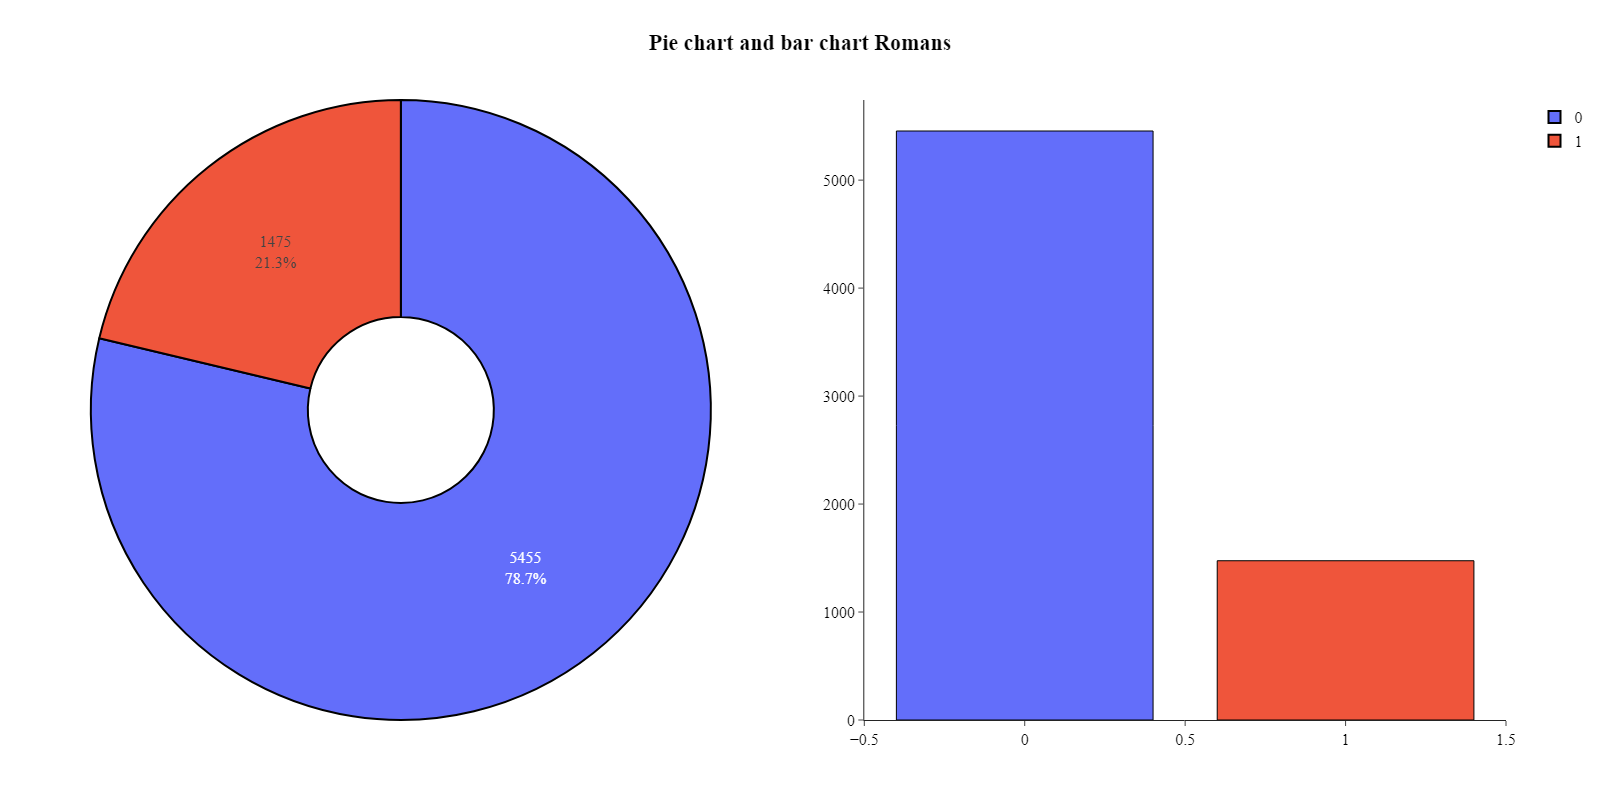

In [167]:
plots.pie_and_bar_plot(data['Romans'], name='Romans')

$\text{I znów około jedna piąta książek jest z kategorii Romans.}$

## Zmienne ciągłe

### pages

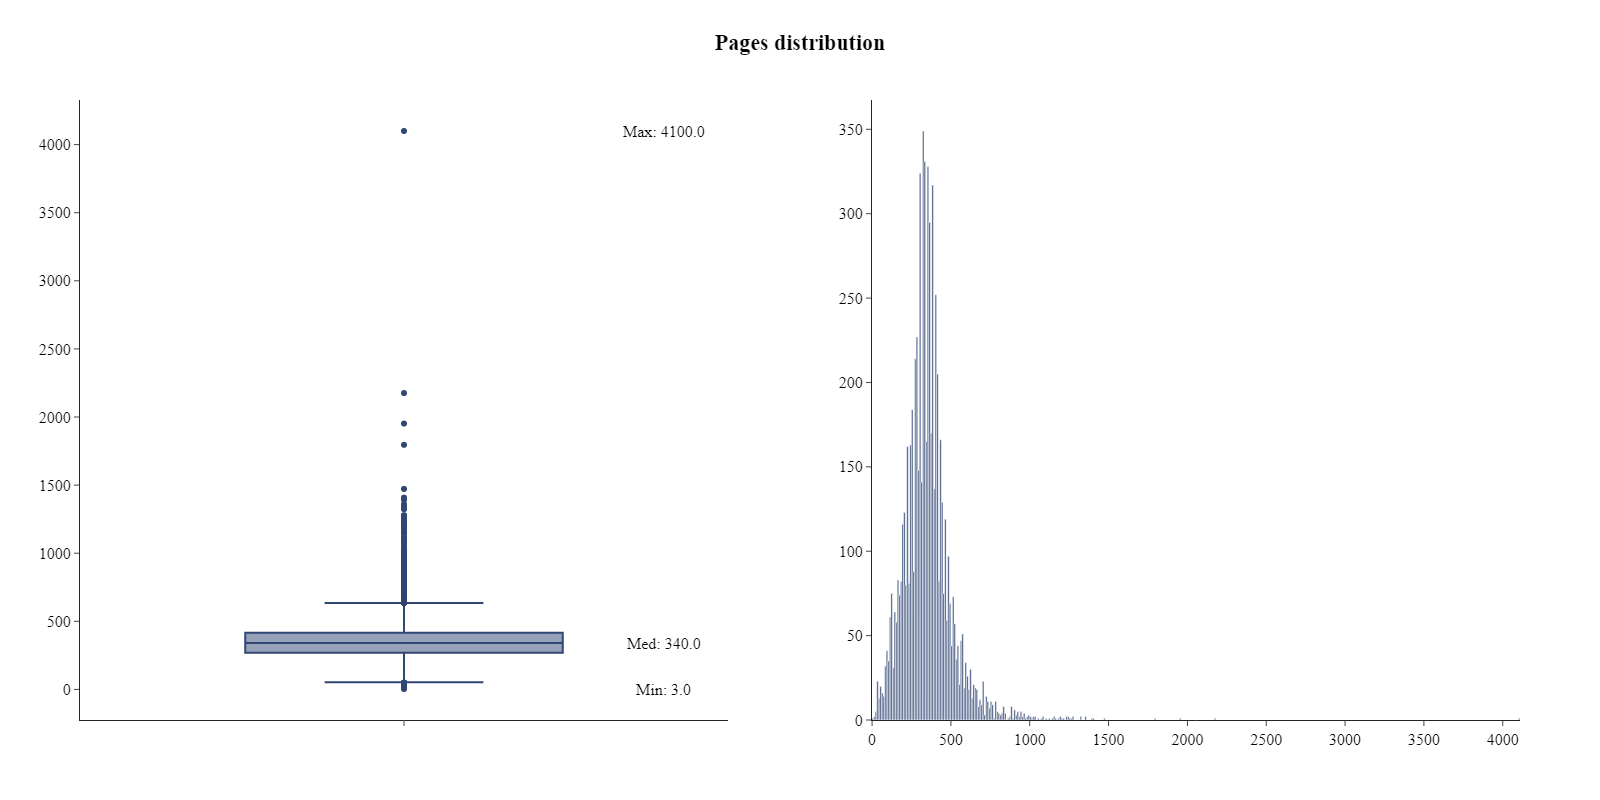

In [168]:
plots.histogram_and_box_plot(data["pages"], name="pages", annotation=["Min","Med","Max"])

$\text{Większość obserwacji skoncentrowana jest w okolicach 350 stron.}$<p>
$\text{Liczba stron znajduje się w przedziale od 3 do 4100, co wskazuje na dużą różnorodność wśród książek.}$

### reviews

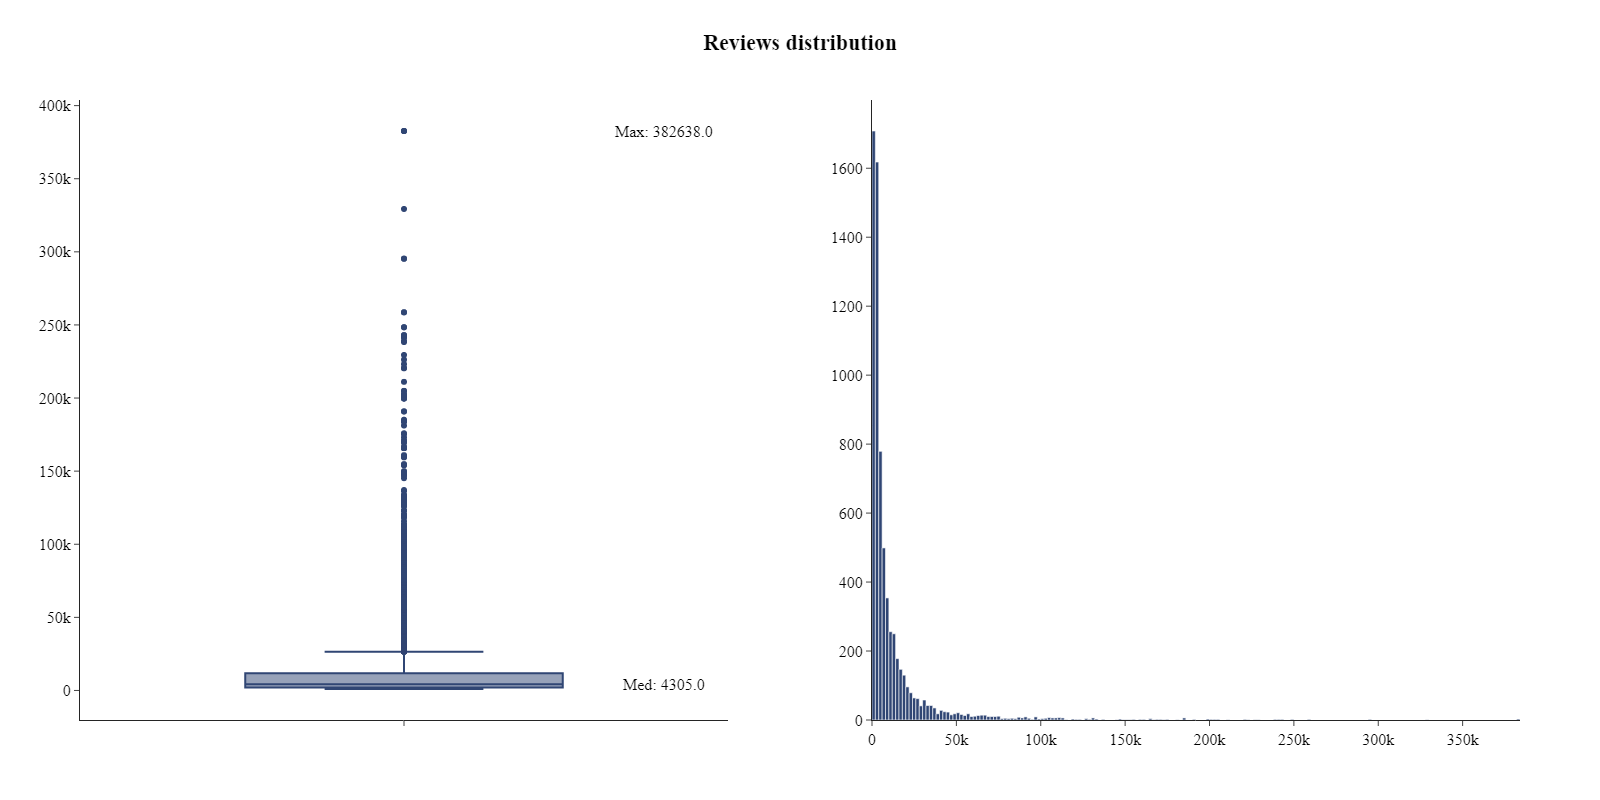

In [169]:
plots.histogram_and_box_plot(data["reviews"], name="reviews", annotation=["Med","Max"])

$\text{Zmienna dotycząca liczby recenzji jest prawostronnie skośna.}$

### mix

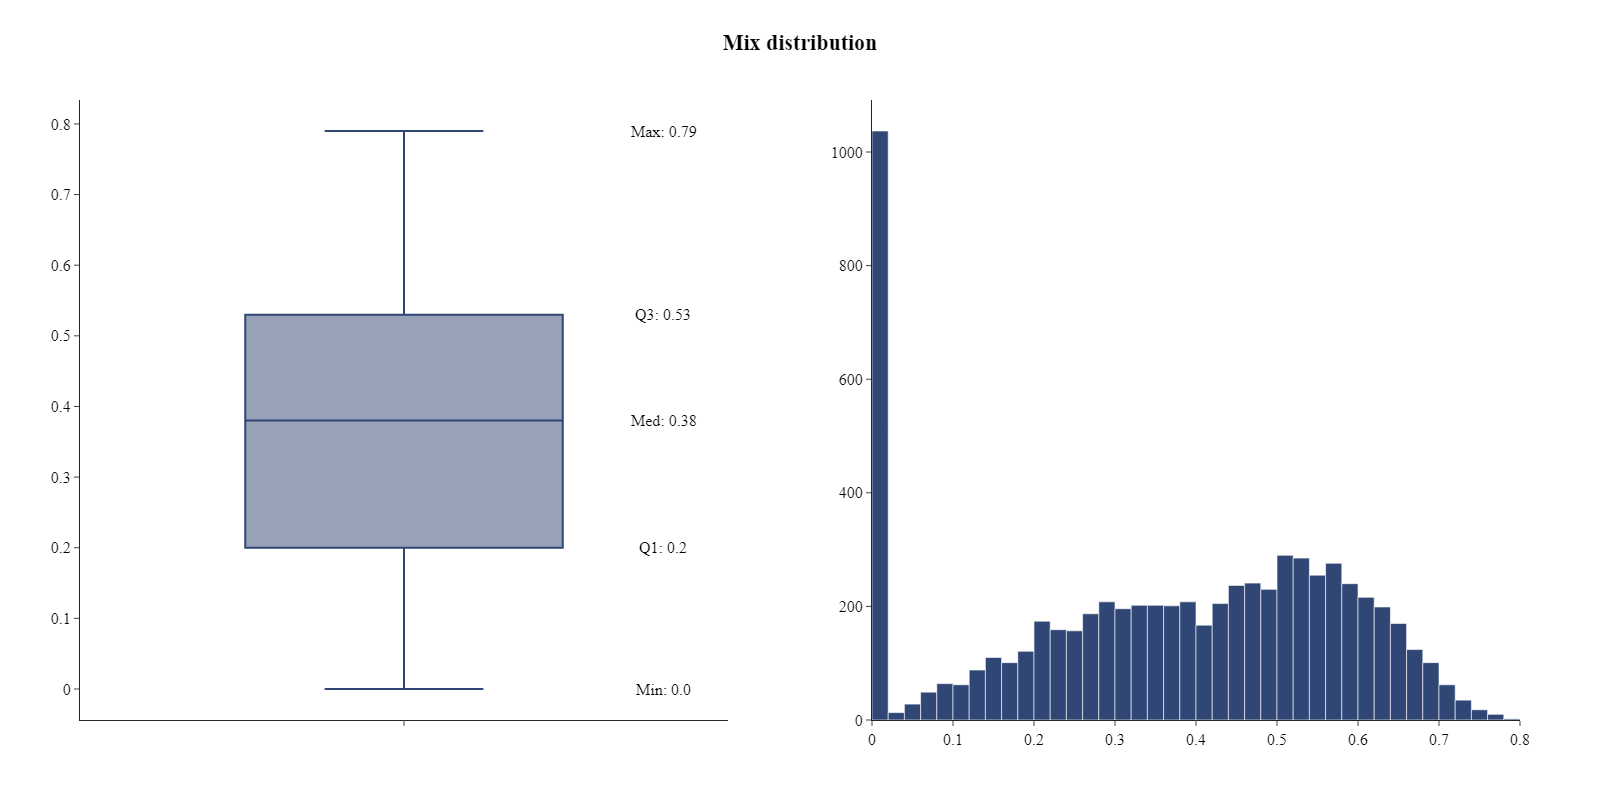

In [170]:
plots.histogram_and_box_plot(data["mix"], name="mix")

$\text{W przypadku dużej liczby obserwacji wartości zmiennej mix wynoszą 0.}$<p>
$\text{Poza tą skrajną wartością, rozkład jest stosunkowo równomiernie rozłożony.}$

### character

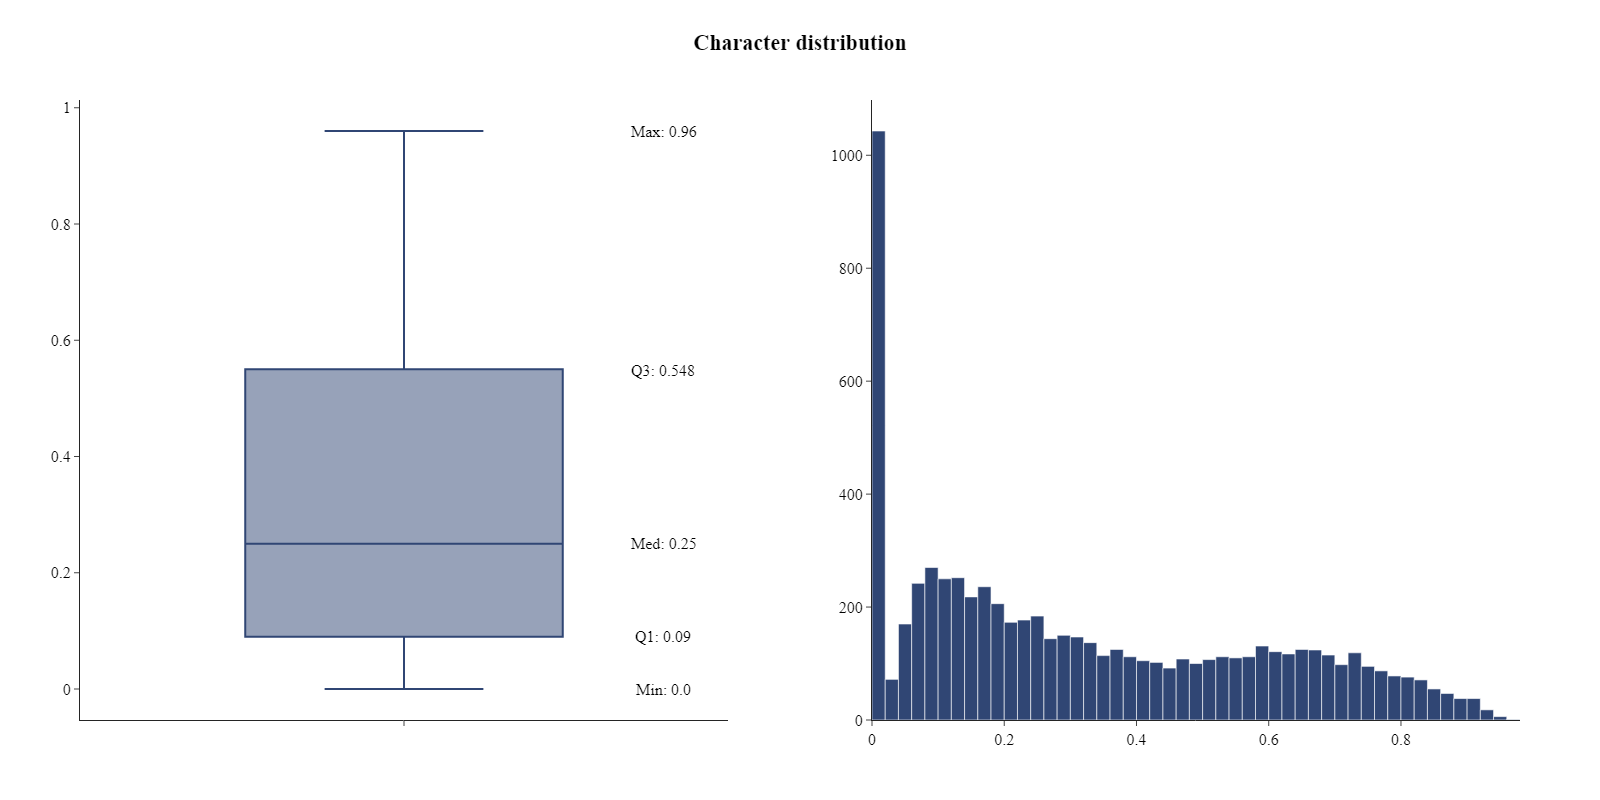

In [171]:
plots.histogram_and_box_plot(data["character"], name="character")

$\text{Rozkład wygląda podobnie jak w przypadku zmiennej mix z większą ilością obserwacji bliższych 0.}$

### plot

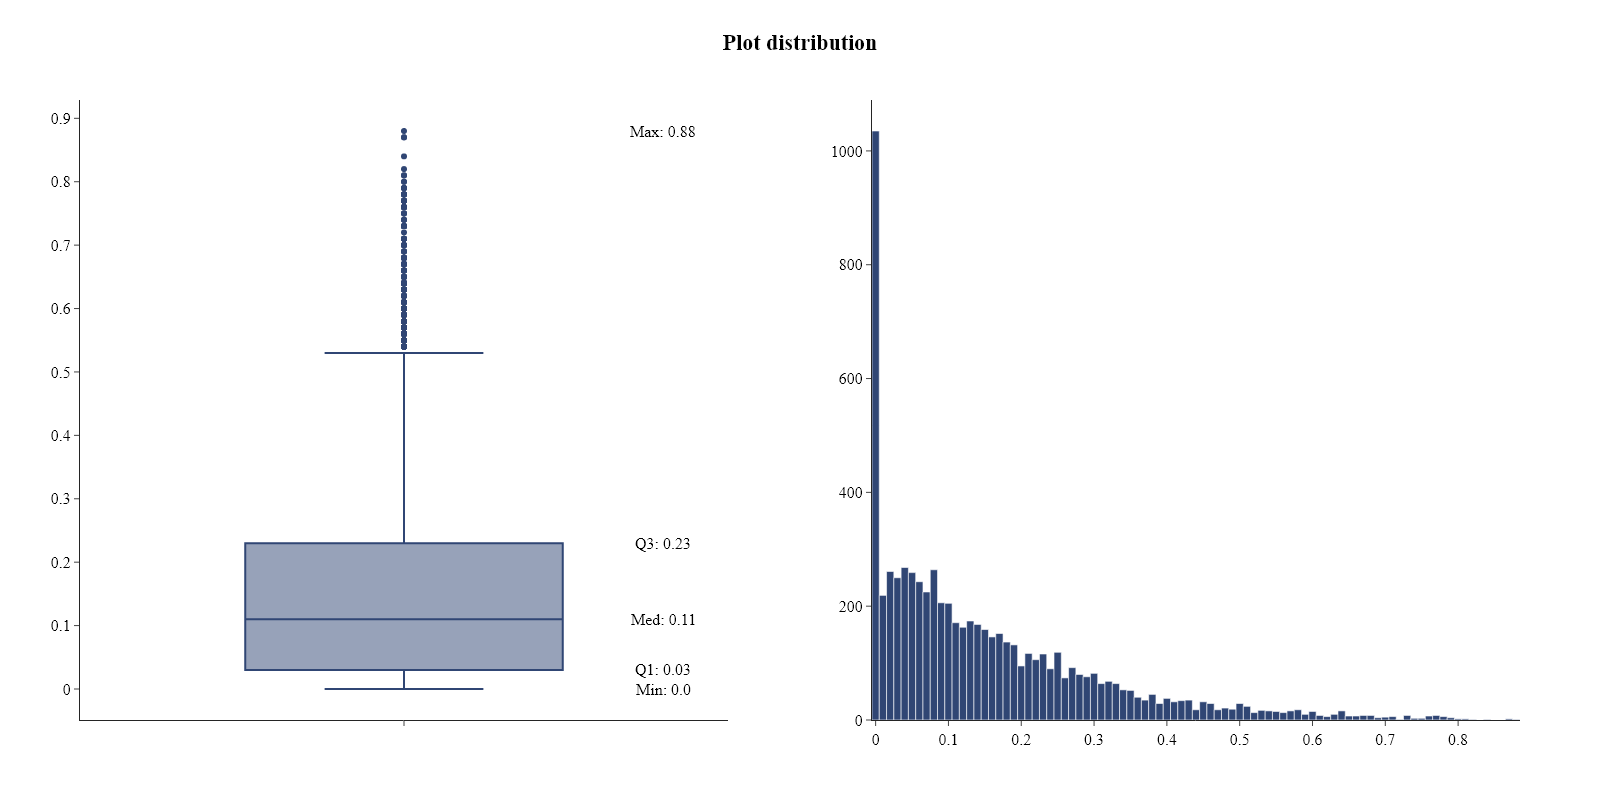

In [34]:
plots.histogram_and_box_plot(data["plot"], name="plot")

$\text{W przypadku zmiennej plot, rozkład jest bardziej skupiony wokół wartości 0.}$<p>
$\text{Sugeruje to, że większość książek nie jest oparta na fabule.}$

### funny

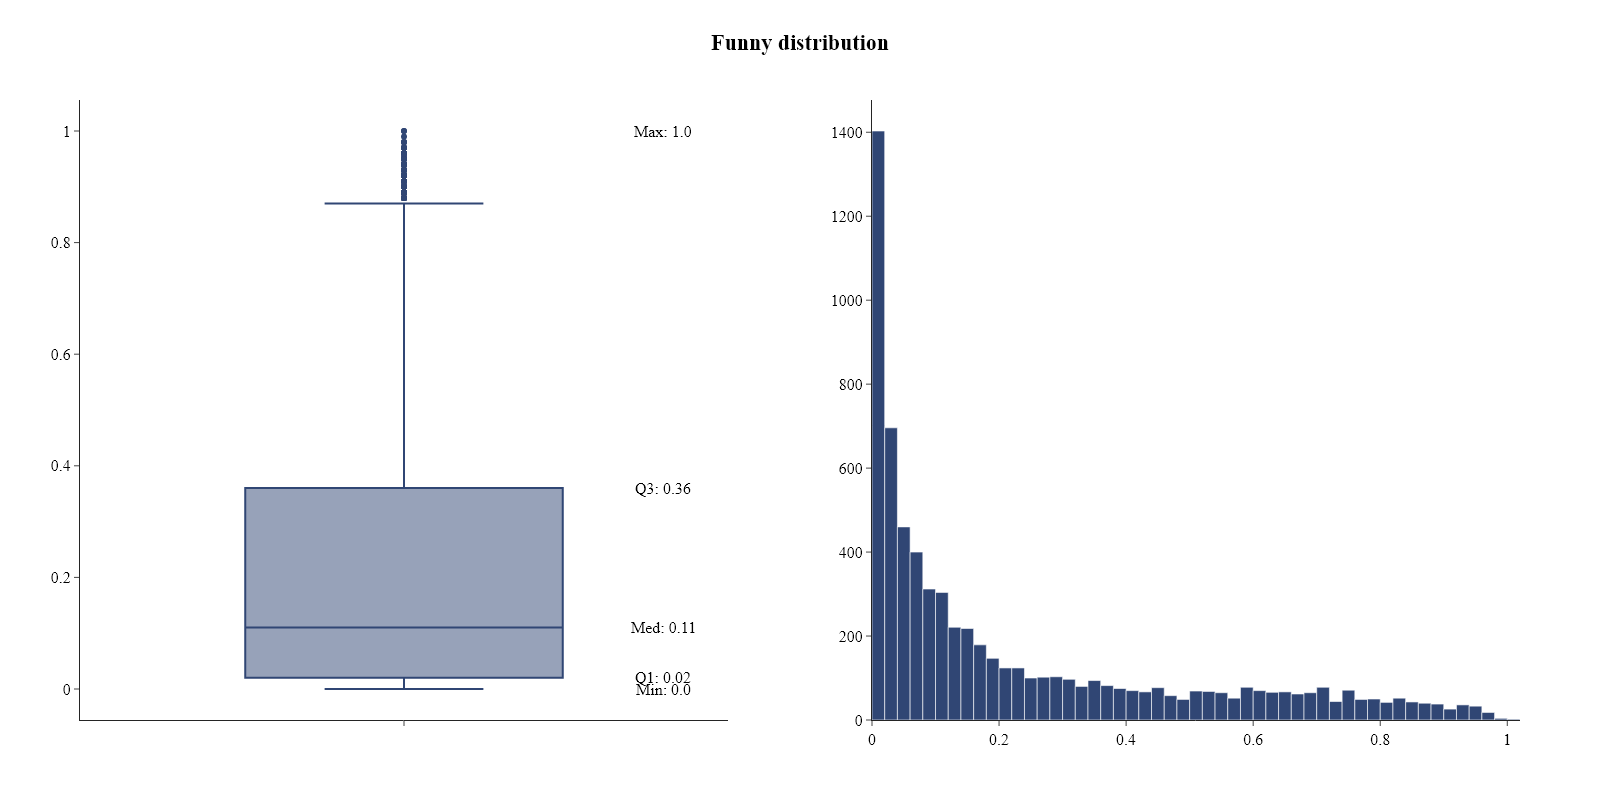

In [36]:
plots.histogram_and_box_plot(data["funny"], name="funny")

$\text{Zmienna funny ma niemal modelowy rozkład prawostronnie skośny.}$

### lighthearted

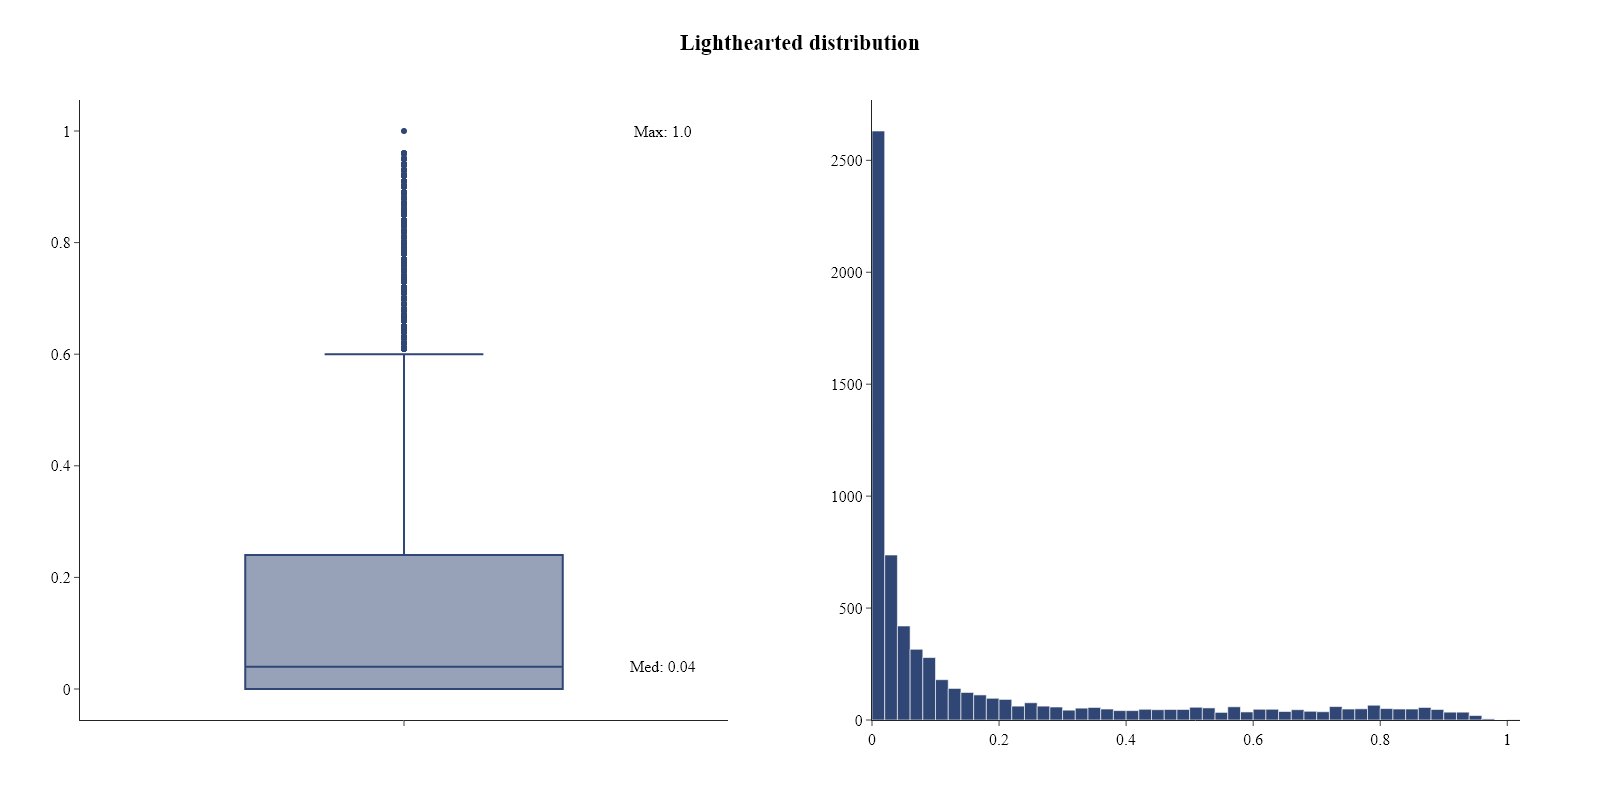

In [37]:
plots.histogram_and_box_plot(data["lighthearted"], name="lighthearted", annotation=["Med","Max"])

$\text{Podobnie jak funny, zmienna lightearted ma rozkład prawostronnie skośny.}$

### emotional

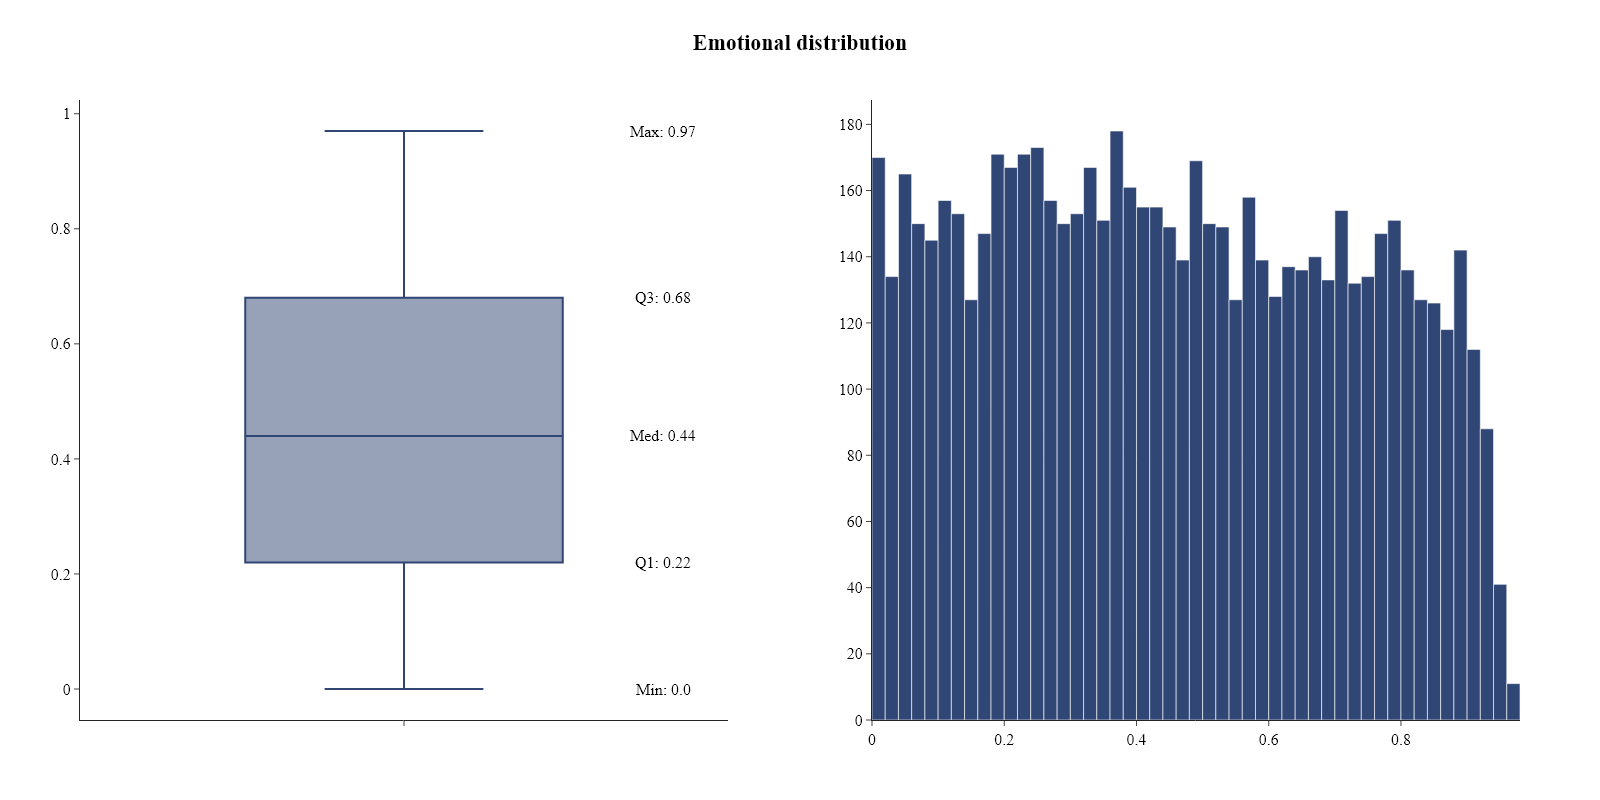

In [38]:
plots.histogram_and_box_plot(data["emotional"], name="emotional")

$\text{Mood emotional ma rozkład zbliżony do rozkładu jednostajnego, lekkie załamanie występuje po prawej stronie rozkładu.}$

### hopeful

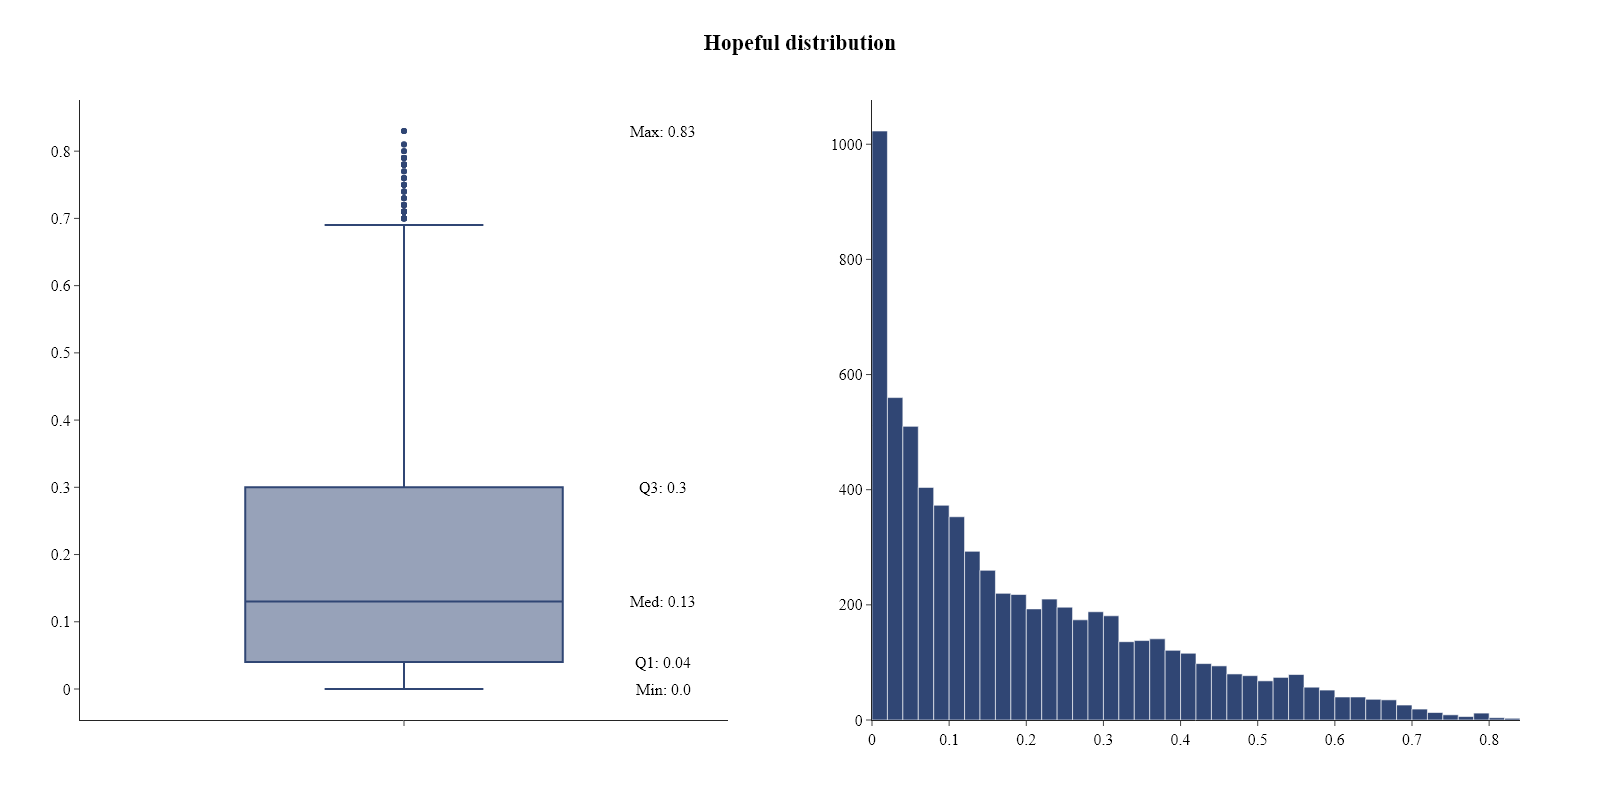

In [39]:
plots.histogram_and_box_plot(data["hopeful"], name="hopeful")

$\text{Dla zmiennej hopeful średnia jest większa od mediany, co wskazuje na prawostronnie skośny rozkład.}$

### inspiring

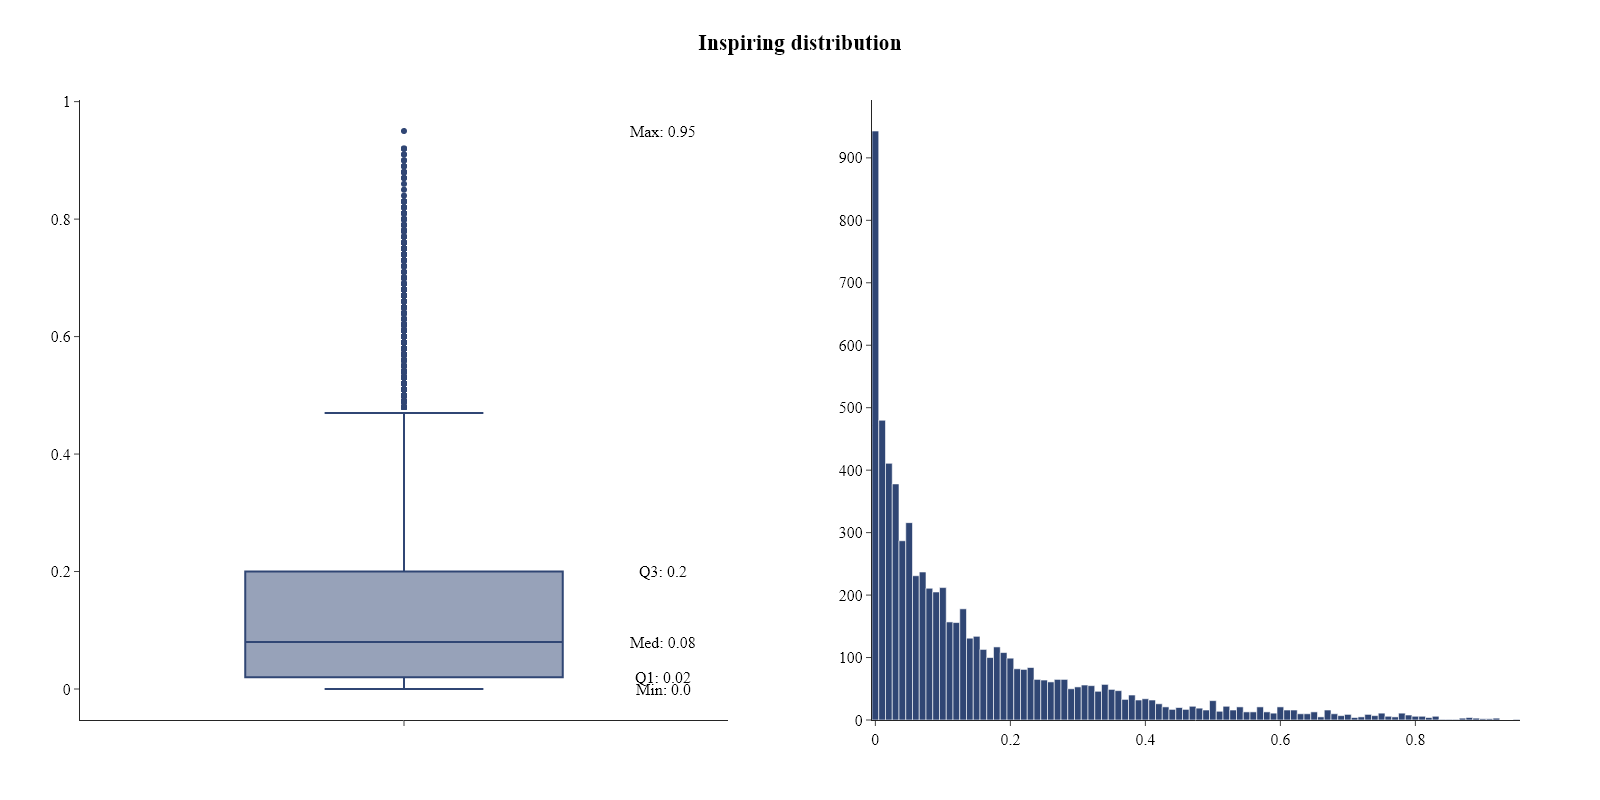

In [40]:
plots.histogram_and_box_plot(data["inspiring"], name="inspiring")

$\text{Inspiring również ma rozkład prawostronnie skośny.}$

### relaxing

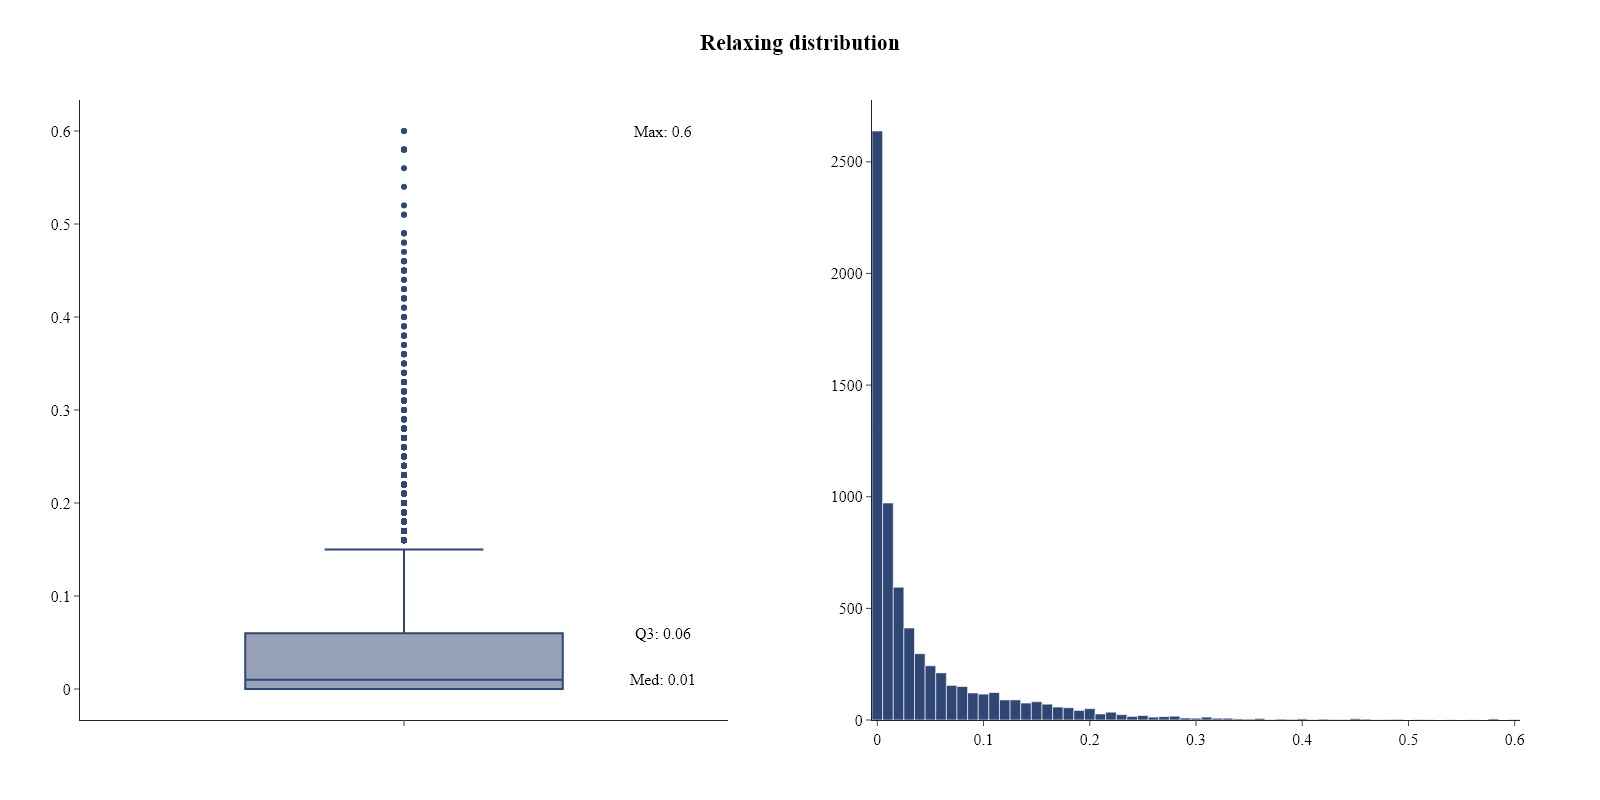

In [41]:
plots.histogram_and_box_plot(data["relaxing"], name="relaxing", annotation=["Med","Q3", "Max"])

$\text{Dla niewielkiej liczby książek zmienna relaxing przyjmuje wartości większe od 0.2.}$

### tense

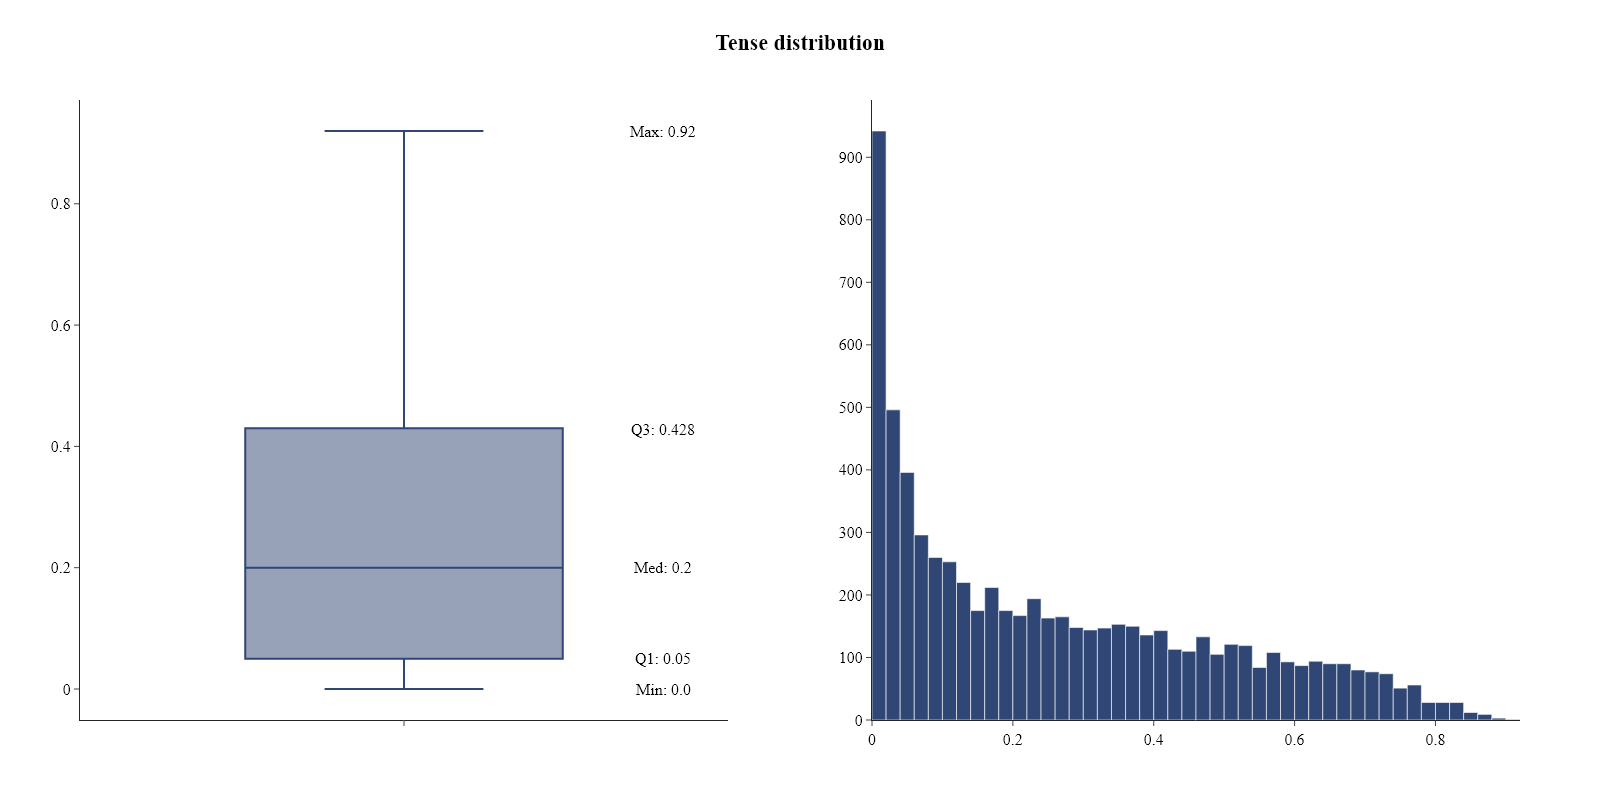

In [42]:
plots.histogram_and_box_plot(data["tense"], name="tense")

$\text{Rozkład zmiennej tense jest prawostronnie skośny.}$

### sad

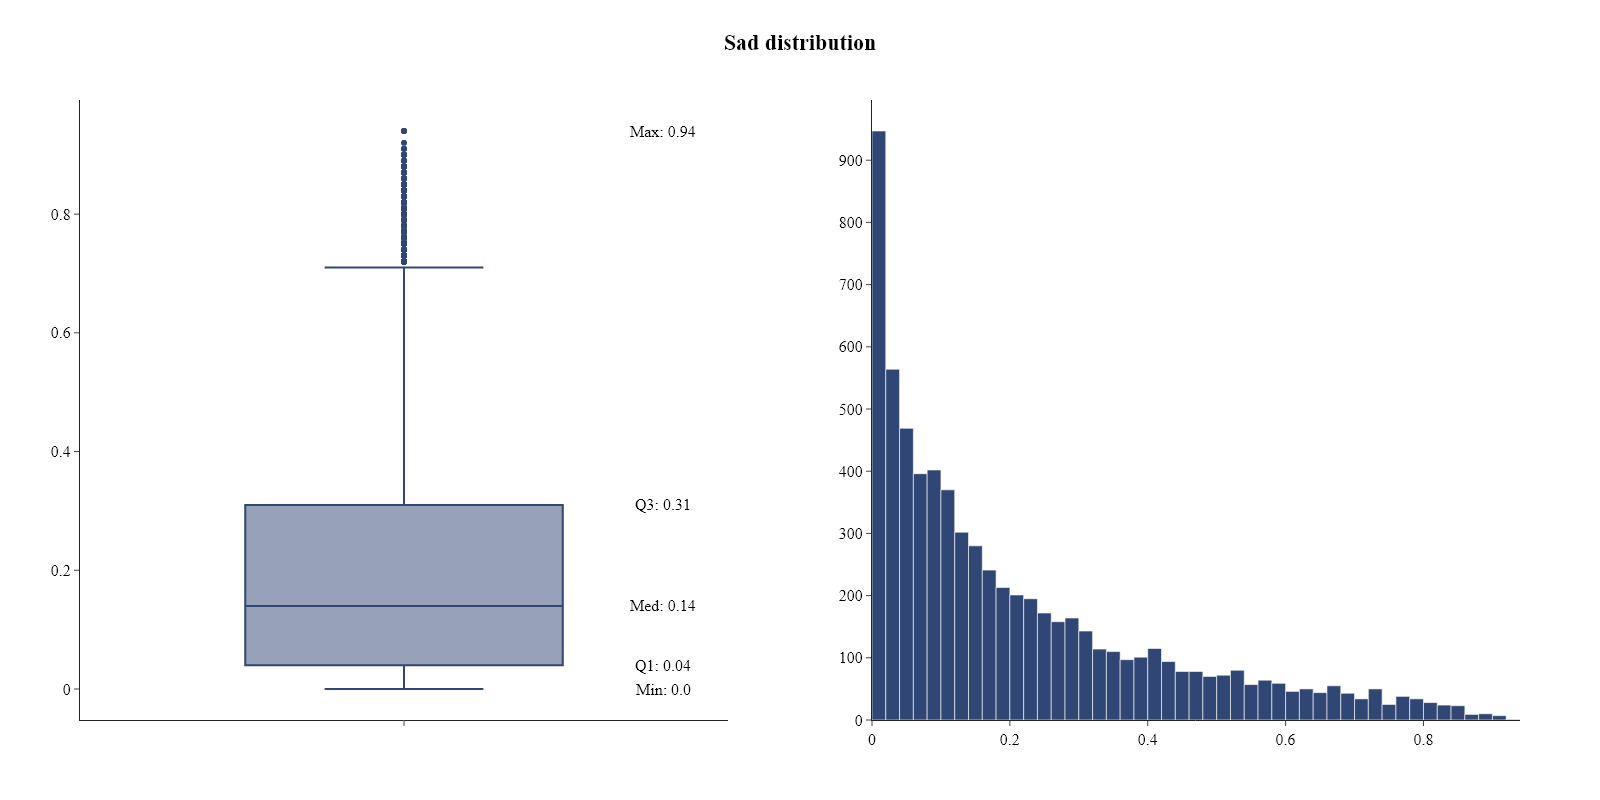

In [43]:
plots.histogram_and_box_plot(data["sad"], name="sad")

$\text{Sad jest rozkładem prawostronnie skośnym.}$

### reflective

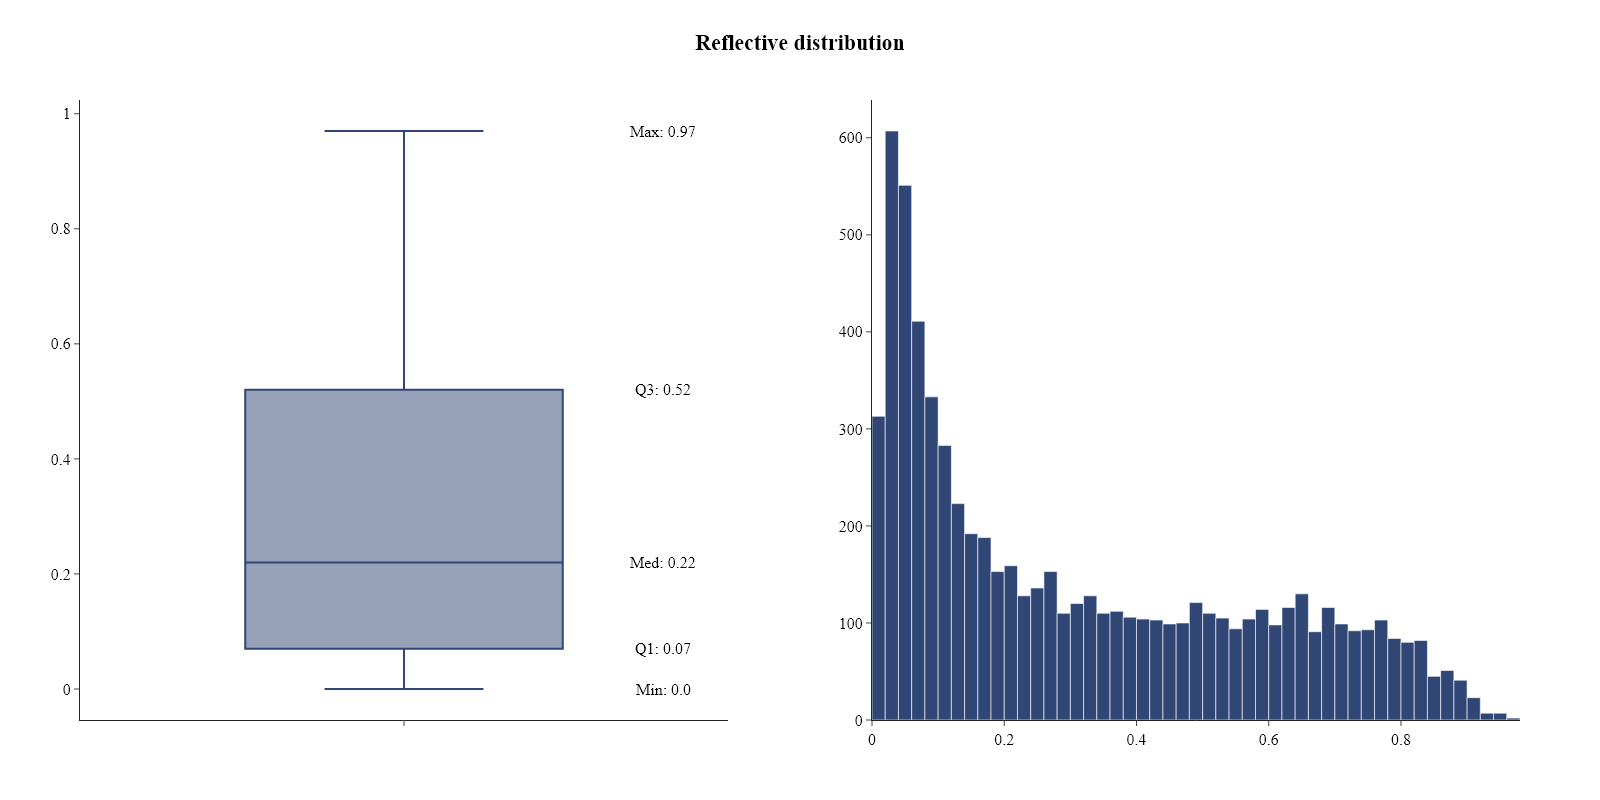

In [44]:
plots.histogram_and_box_plot(data["reflective"], name="reflective")

$\text{W odróżnieniu od poprzednich zmiennych, w przypadku reflective nieco bardziej liczne są przedziały o wartościach większych od 0.}$

### adventurous

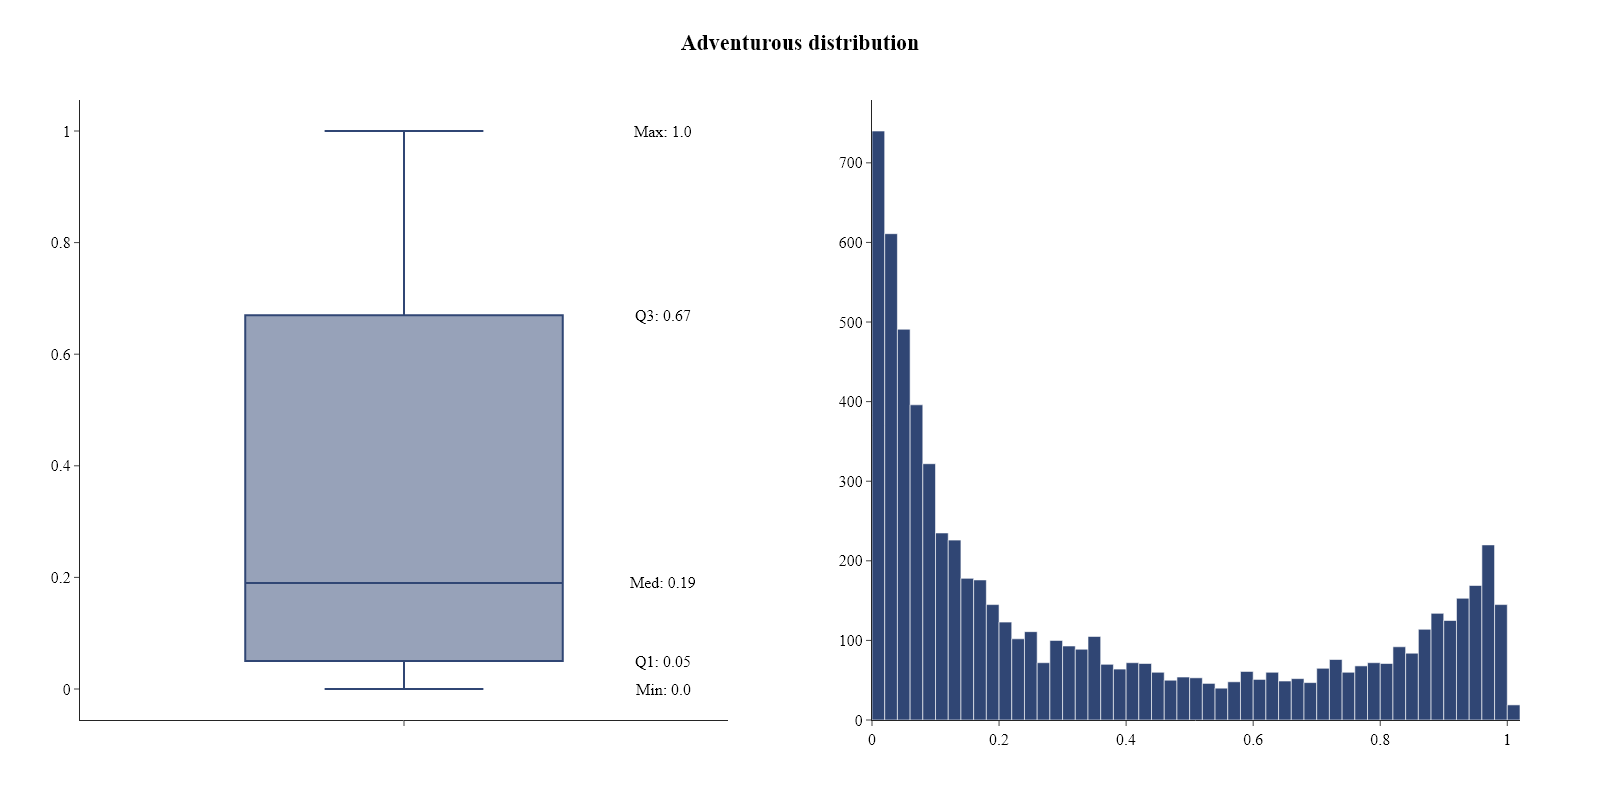

In [45]:
plots.histogram_and_box_plot(data["adventurous"], name="adventurous")

$\text{Wgłębienie w okolicach wartości 0.5 sygnalizuje, że adventorous przyjmuje przeważnie wartości skrajne.}$

### challenging

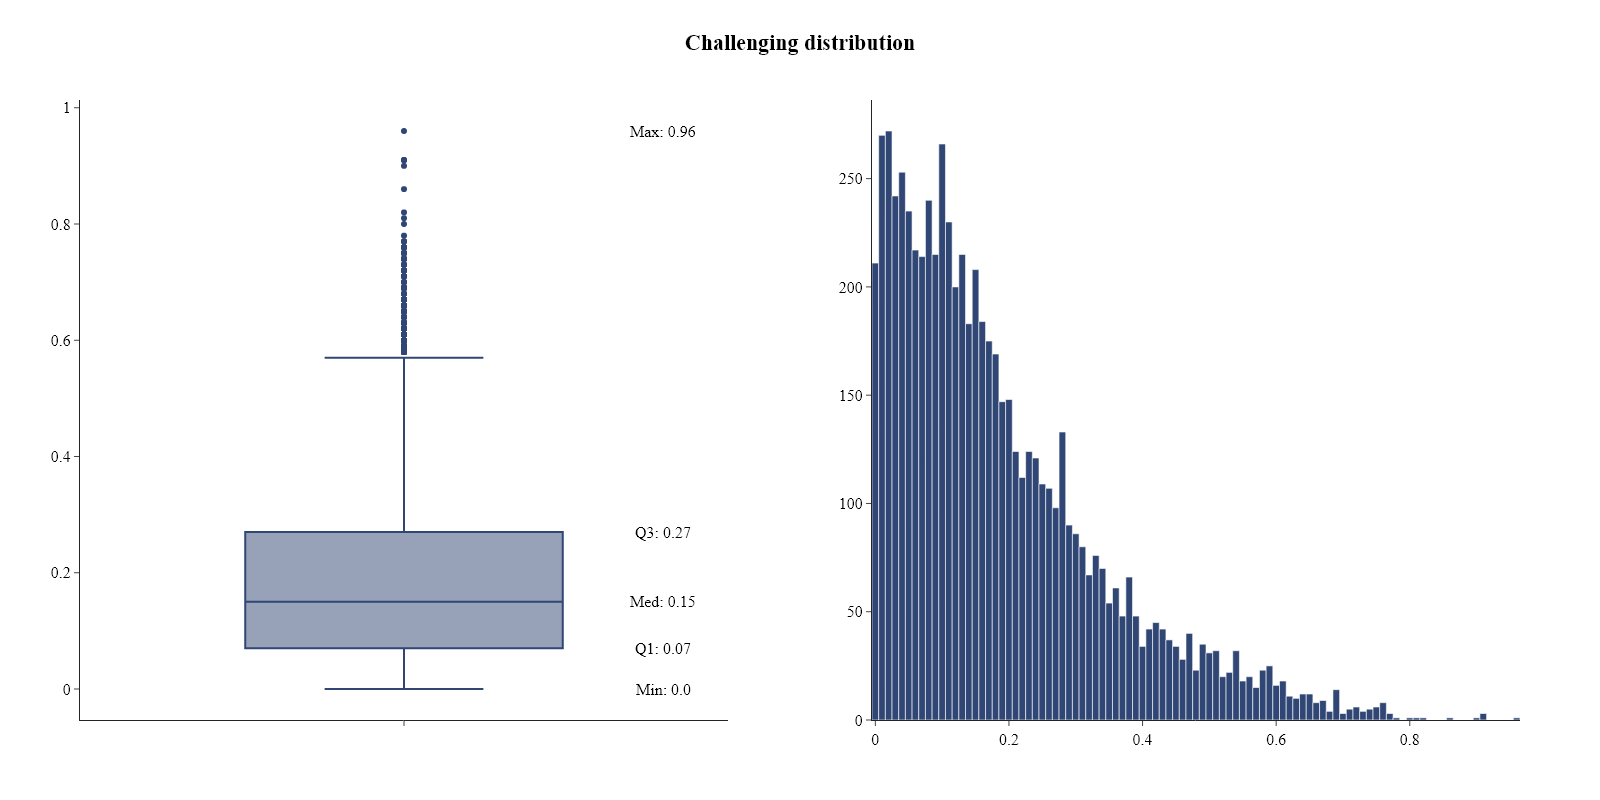

In [46]:
plots.histogram_and_box_plot(data["challenging"], name="challenging")

$\text{Bardzo niewielka liczba książek ma mood challenging większy od 0.8.}$

### informative

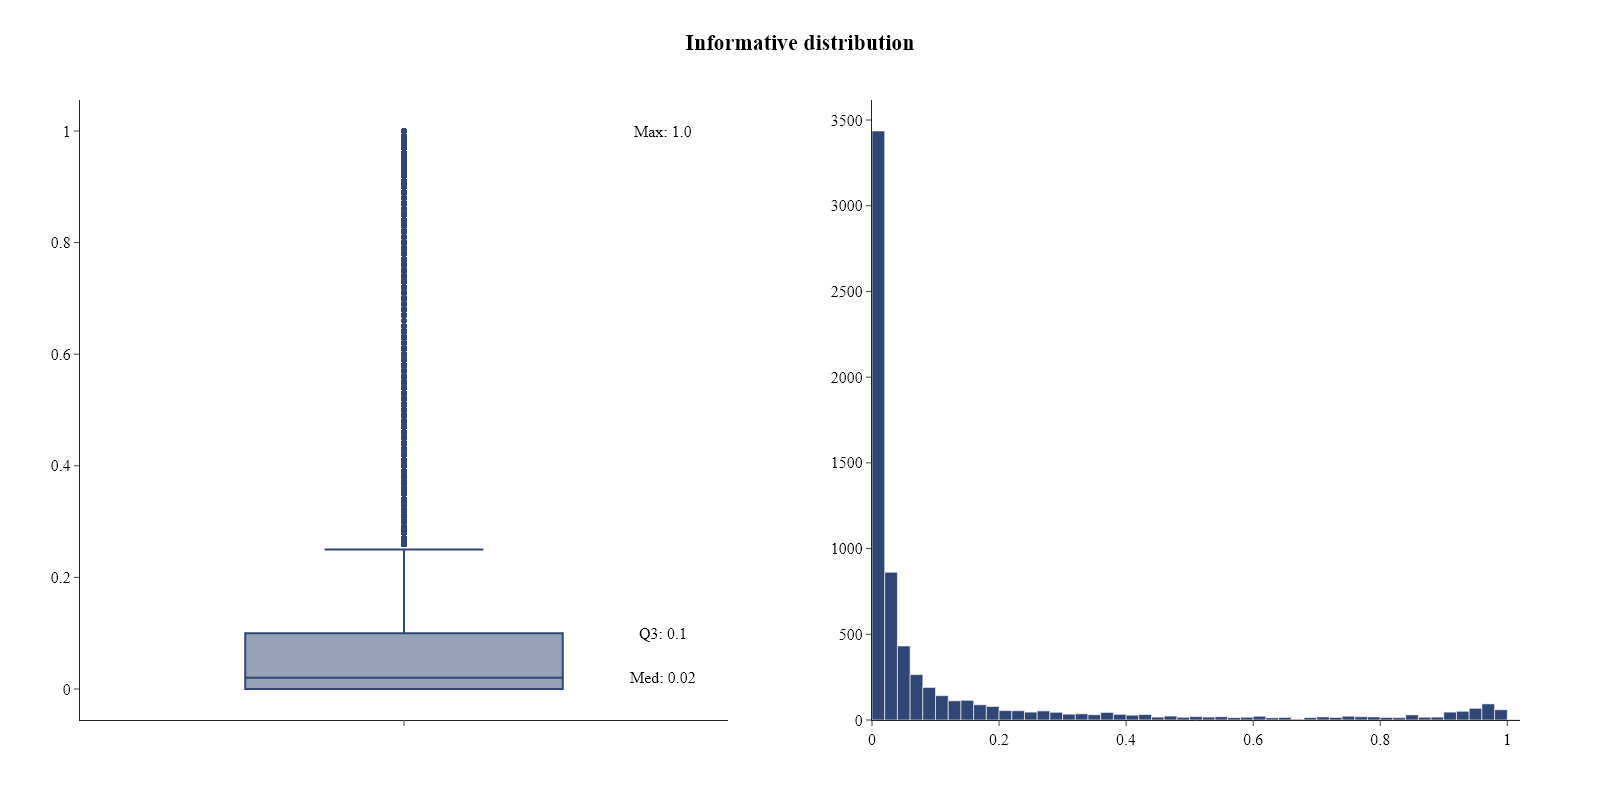

In [47]:
plots.histogram_and_box_plot(data["informative"], name="informative", annotation=["Med","Q3", "Max"])

$\text{Niemal połowa obserwacji zbioru danych dla zmiennej informative znajduje się w przedziale [0, 0.01].}$ 
$\text{Można za to również zaobserwować, że część obserwacji przyjmuje wartość bliską 1.}$

### mysterious

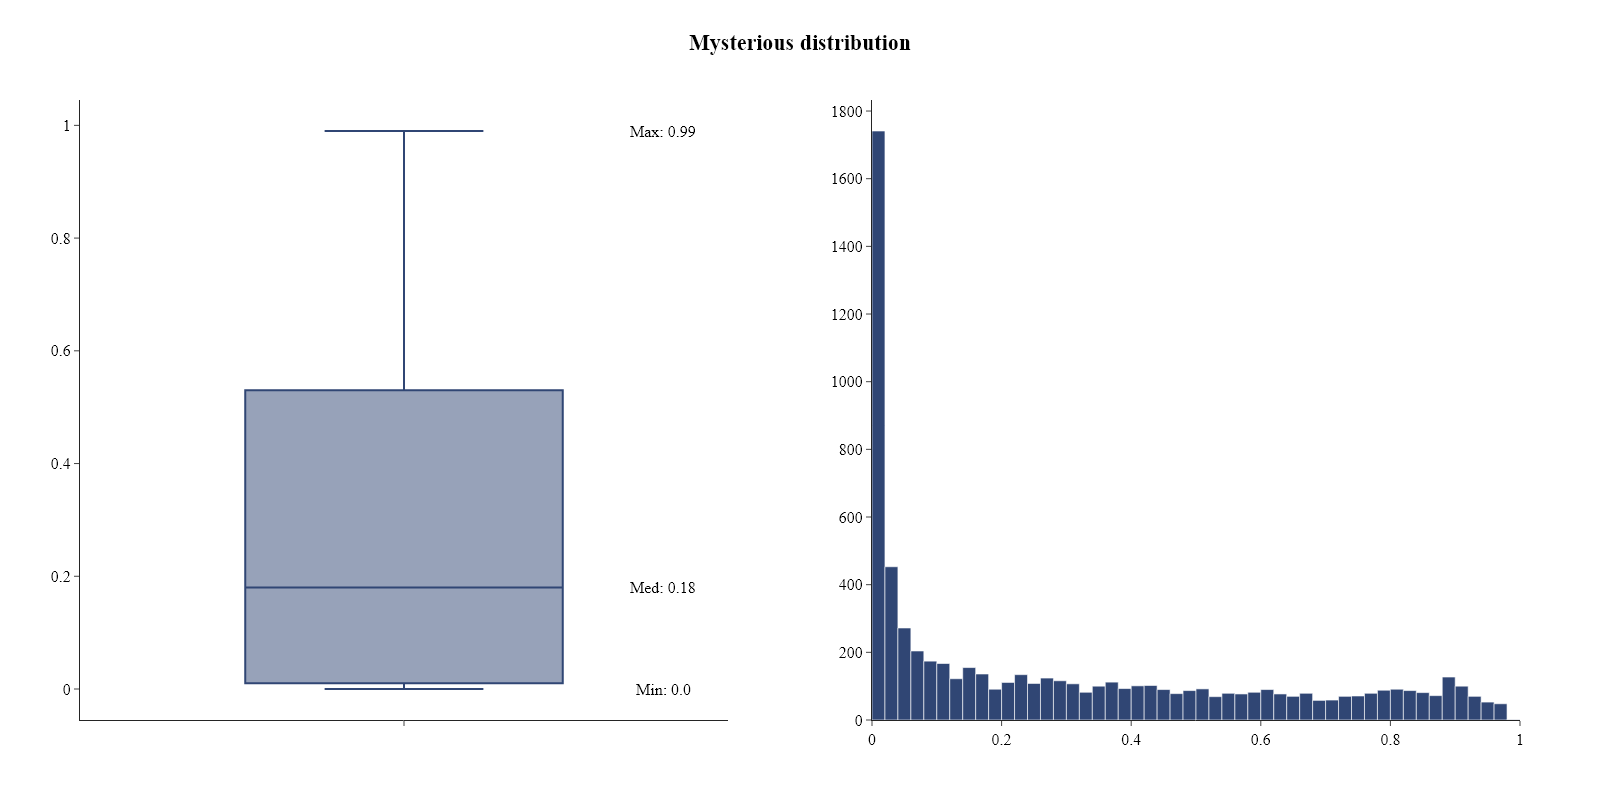

In [48]:
plots.histogram_and_box_plot(data["mysterious"], name="mysterious", annotation=["Min", "Med", "Max"])

$\text{Pomijając skrajne wartości znajdujące się przy minimum, zmienna mysterious ma rozkład zbliżony do rozkładu jednostajnego.}$

### dark

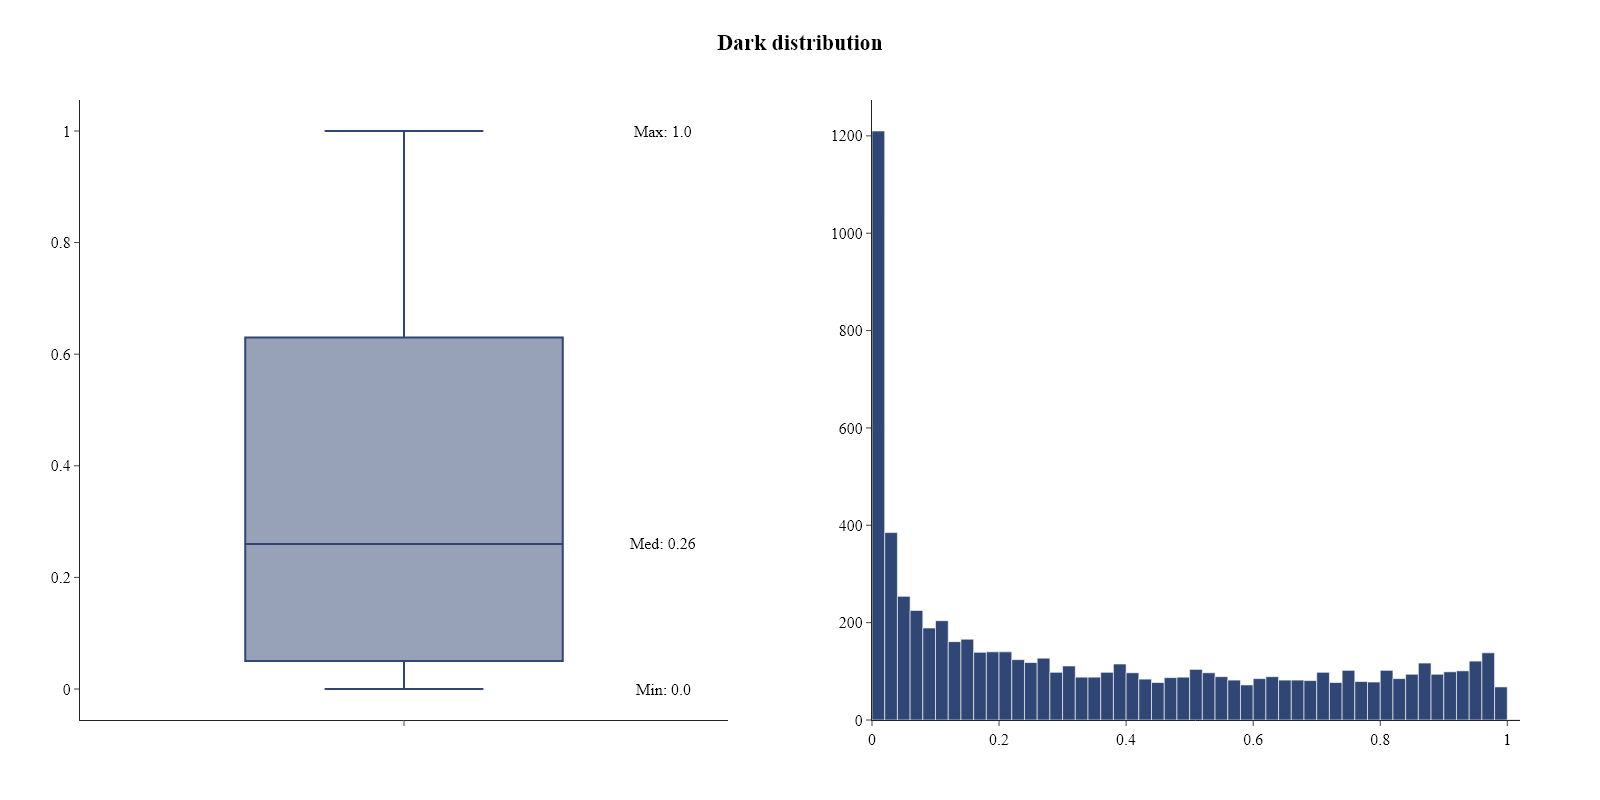

In [49]:
plots.histogram_and_box_plot(data["dark"], name="dark", annotation=["Min", "Med", "Max"])

$\text{Podobnie jak w przypadku ziennej mysterious, dark ma rozkład zbliżony do rozkładu jednostajnego.}$

## Rozkład zmiennej celu w zależności od zmiennych kategorycznych

$\text{W poniższej sekcji przedstawiono rozkład zmiennej celu w zależności od wartości zmiennych kategorycznych.}$<p>
$\text{Po przedstawieniu wszystkich wykresów zapiszemy kilka wniosków.}$

### series

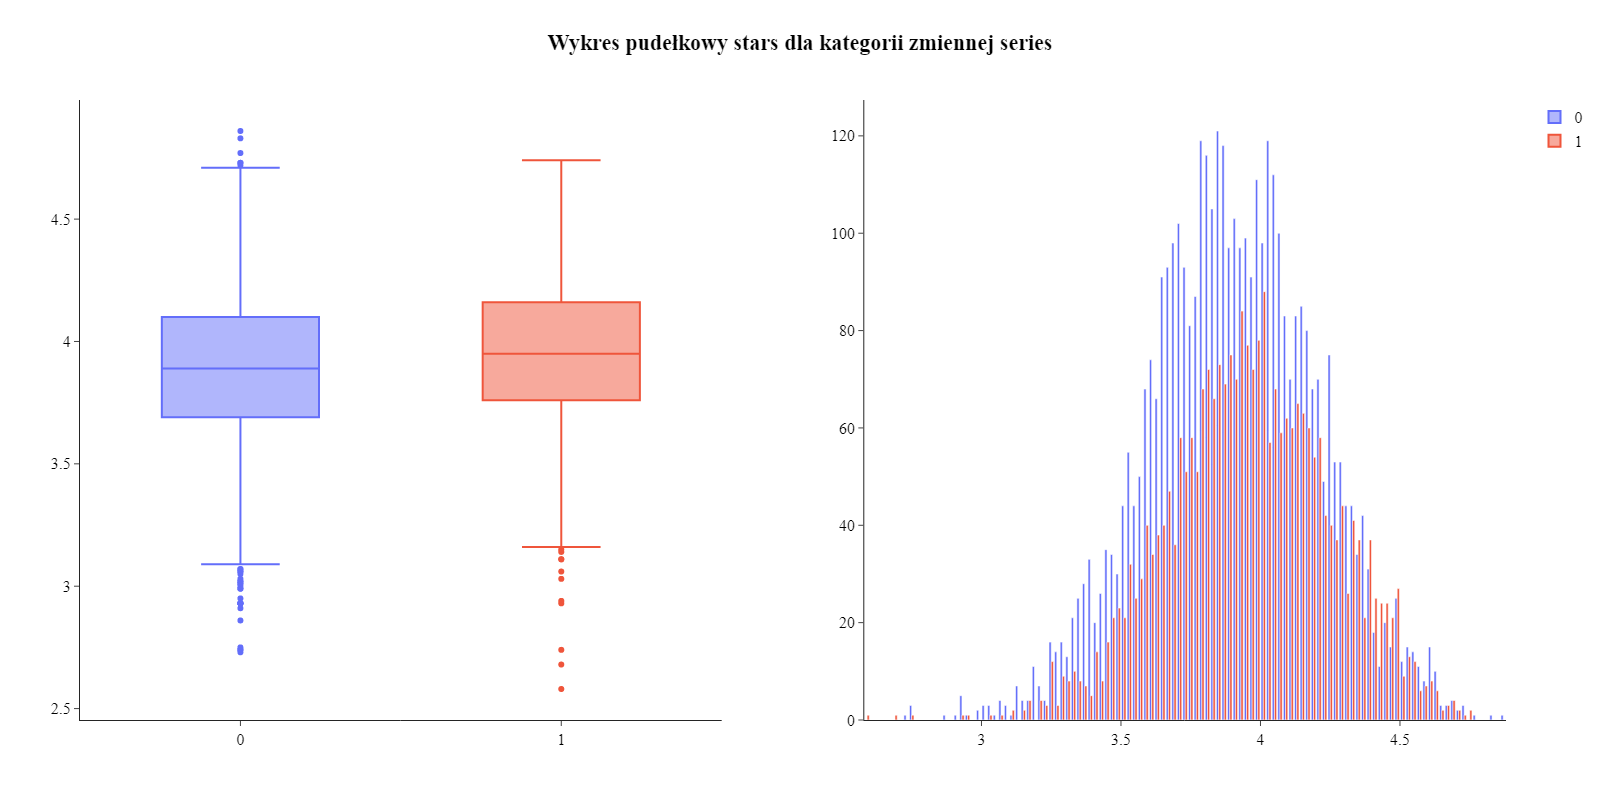

In [207]:
plots.boxplot_by_categorical(data, categorical="series", target=target)

### Fiction

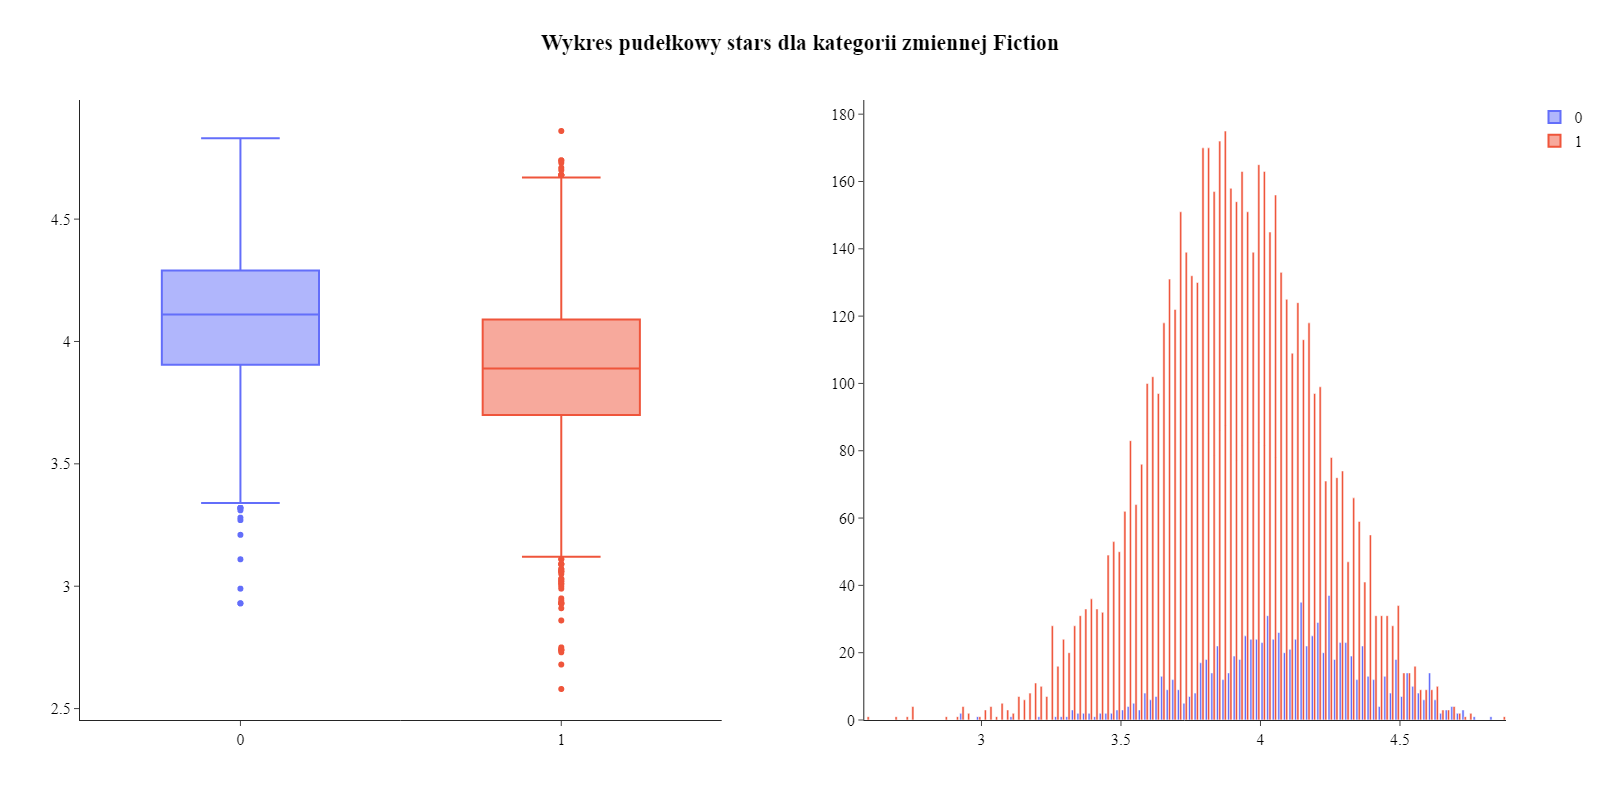

In [208]:
plots.boxplot_by_categorical(data, categorical='Fiction', target=target) 

### Nonfiction

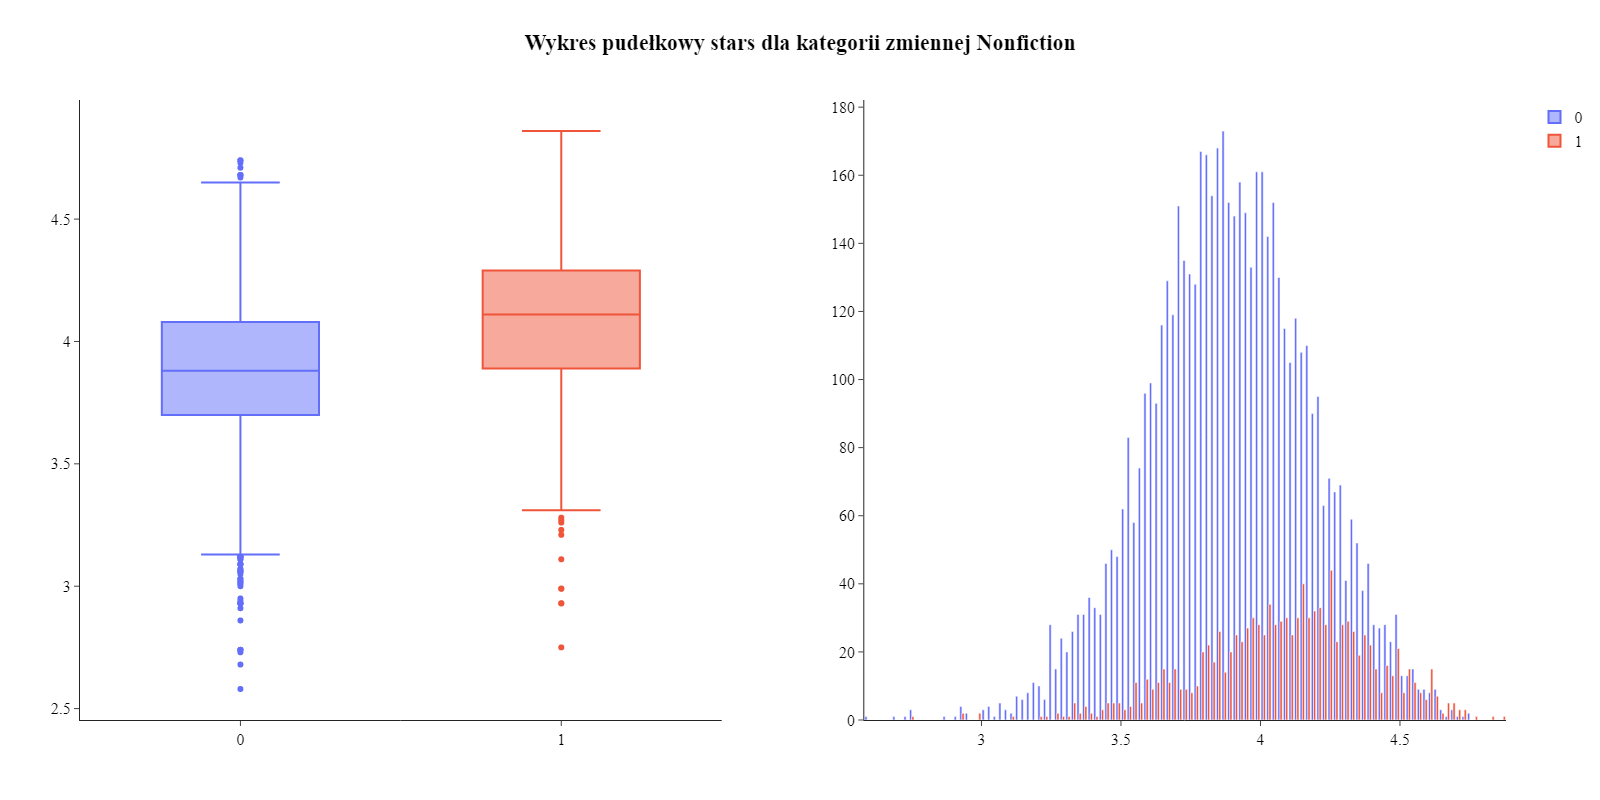

In [209]:
plots.boxplot_by_categorical(data, categorical= 'Nonfiction', target=target)

### Literary

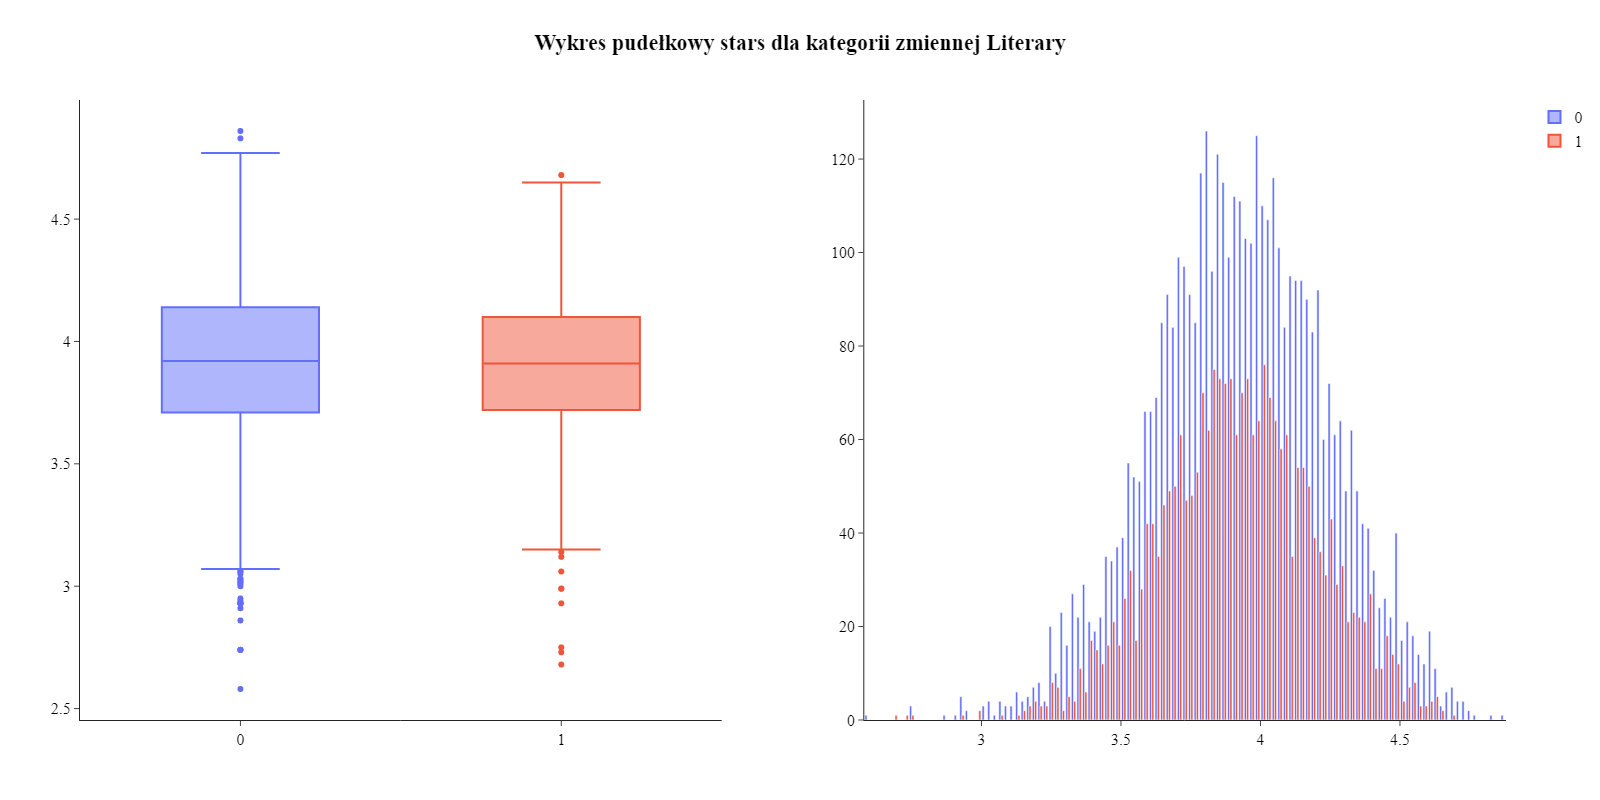

In [210]:
plots.boxplot_by_categorical(data, categorical='Literary', target=target)

### Fantasy

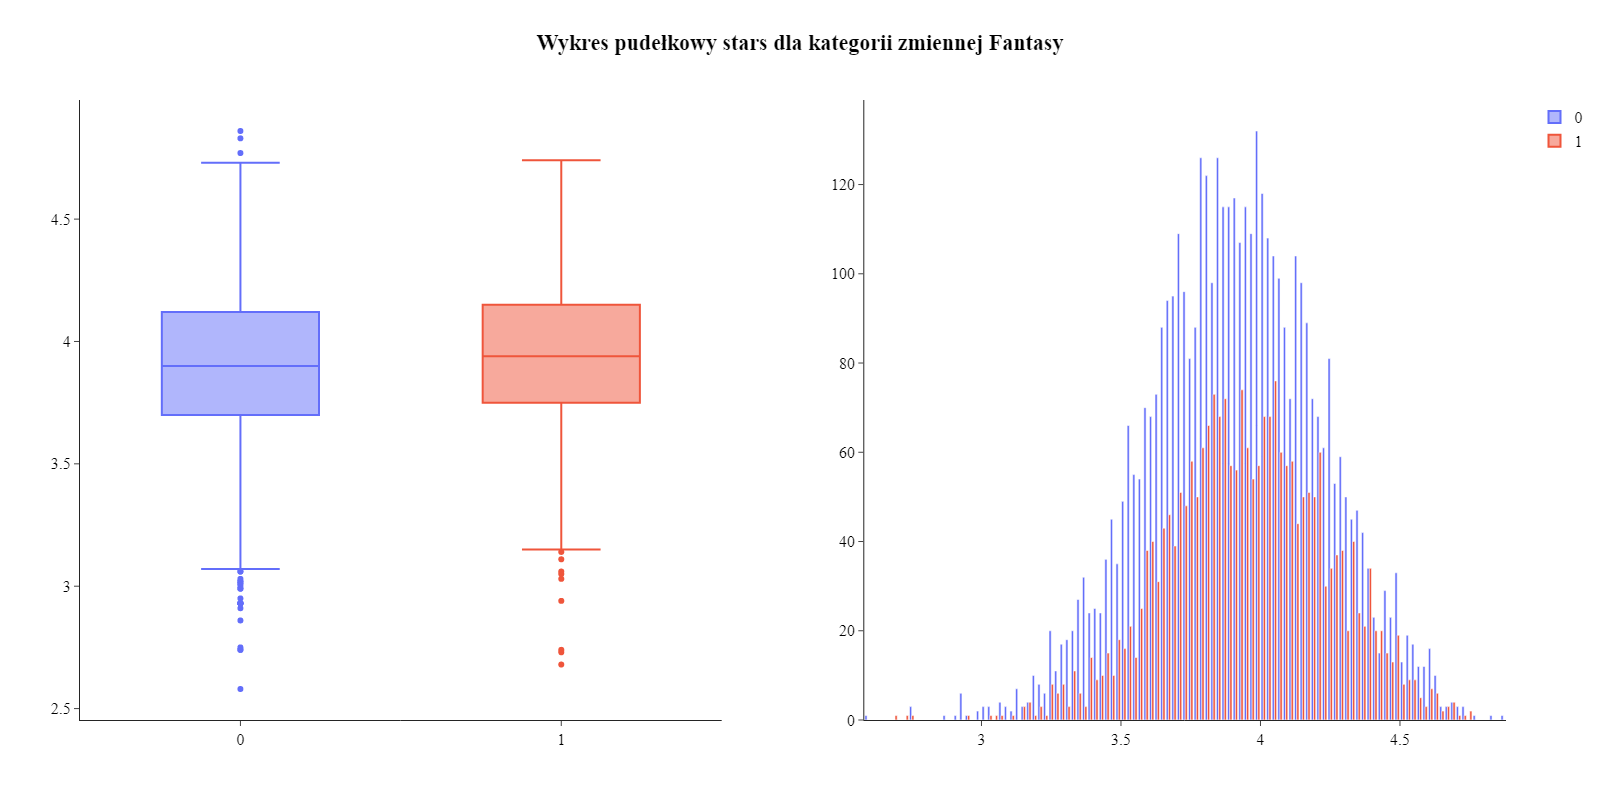

In [211]:
plots.boxplot_by_categorical(data, categorical='Fantasy', target=target)

### Realism

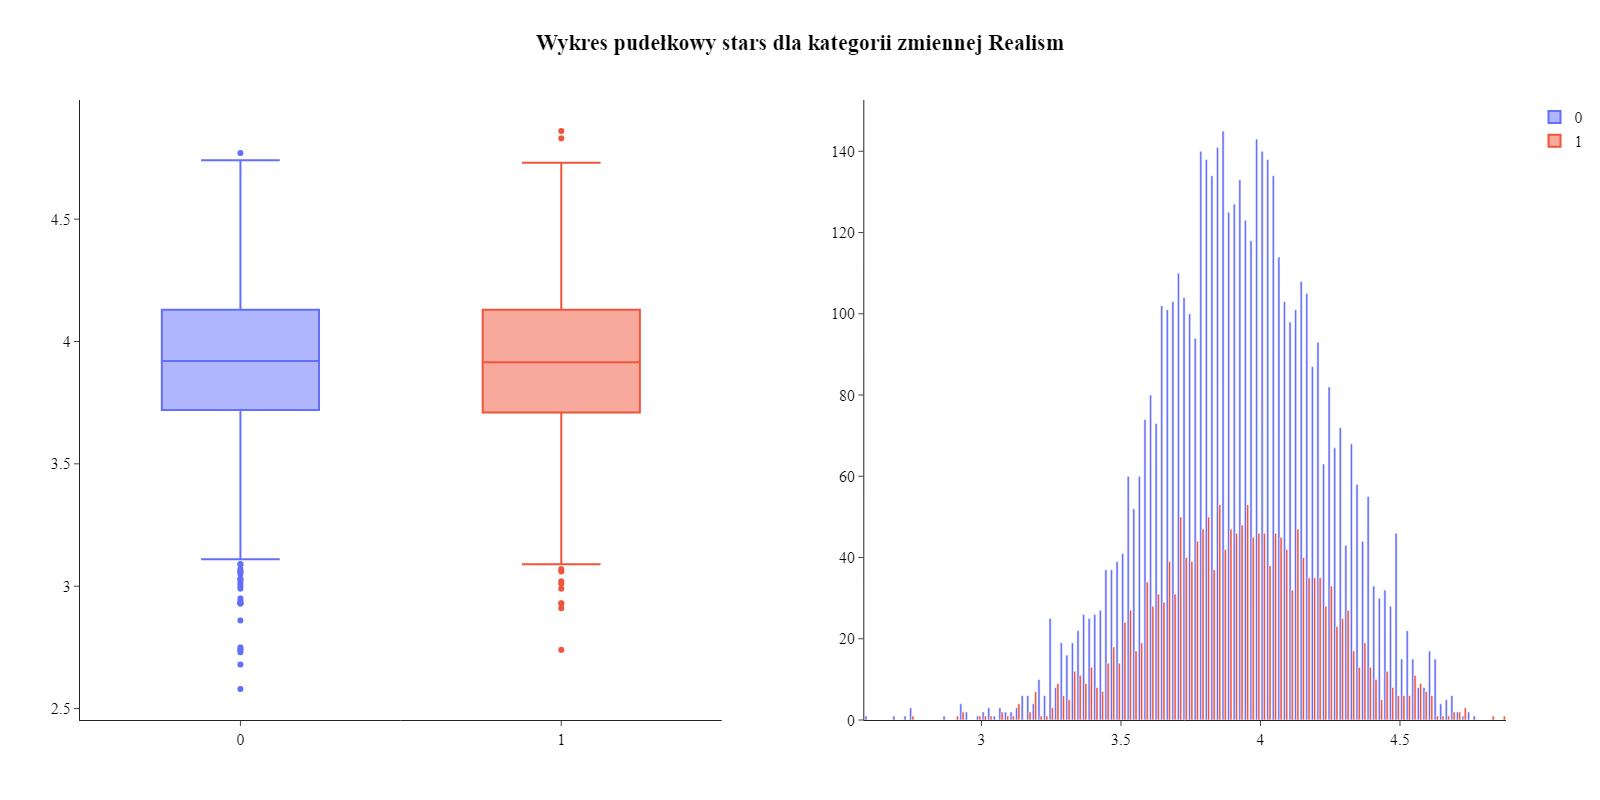

In [212]:
plots.boxplot_by_categorical(data, categorical='Realism', target=target)

###  Crime

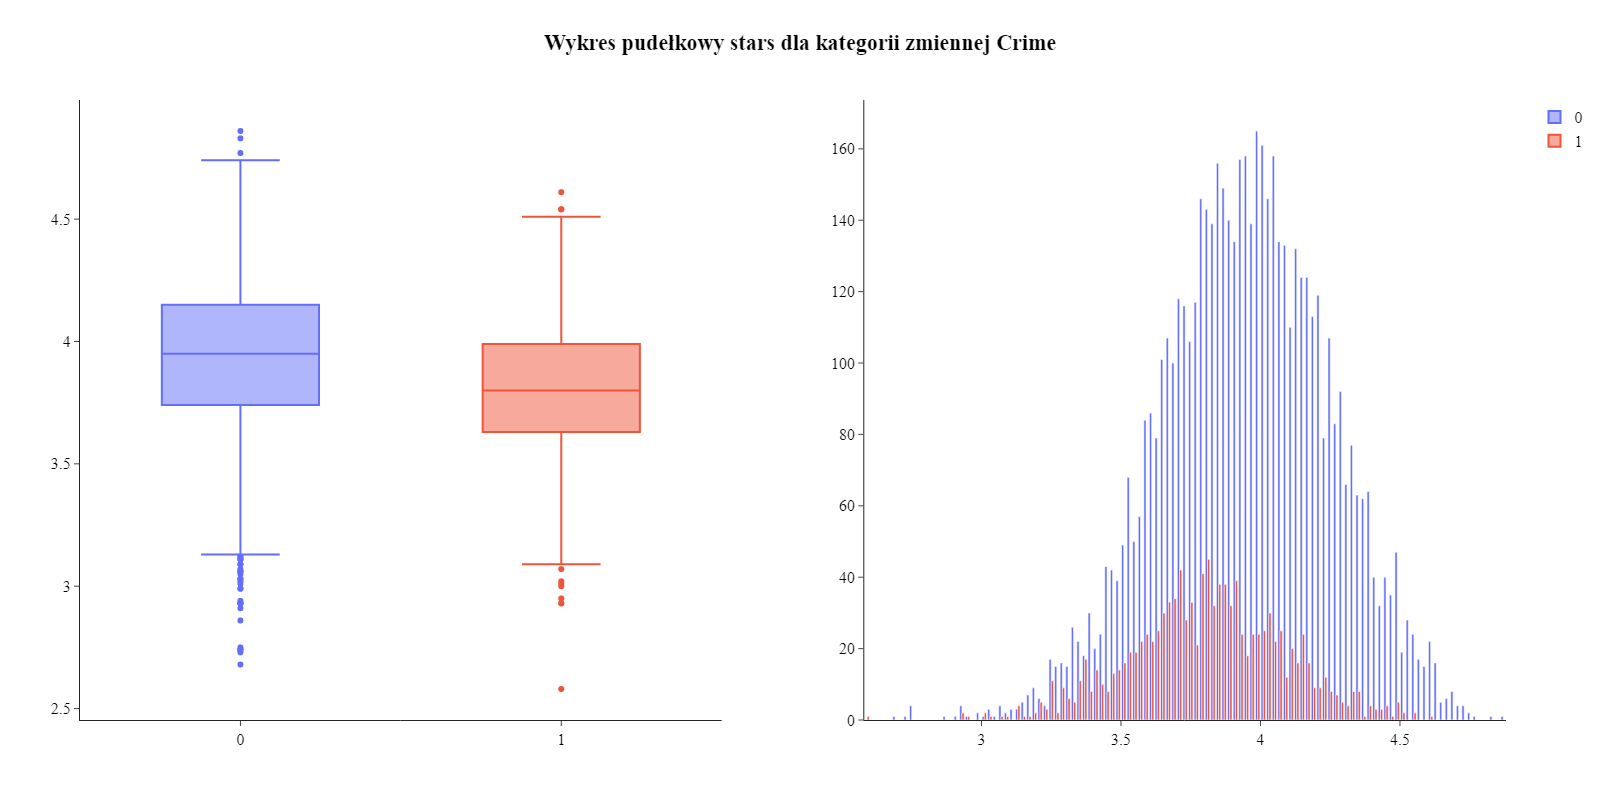

In [213]:
plots.boxplot_by_categorical(data, categorical= 'Crime', target=target)

### Social

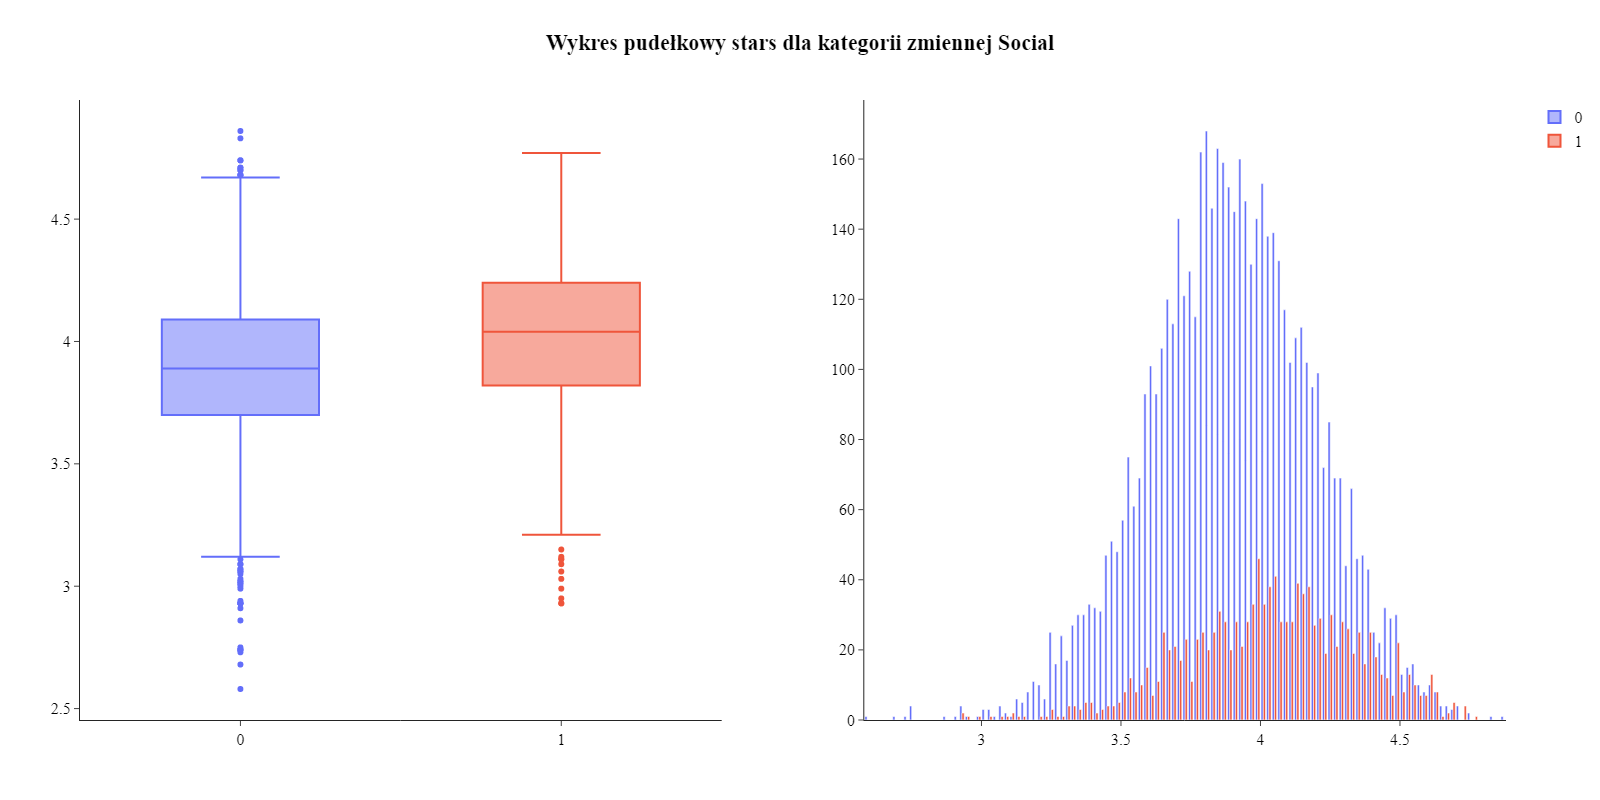

In [214]:
plots.boxplot_by_categorical(data, categorical='Social', target=target)

### Children

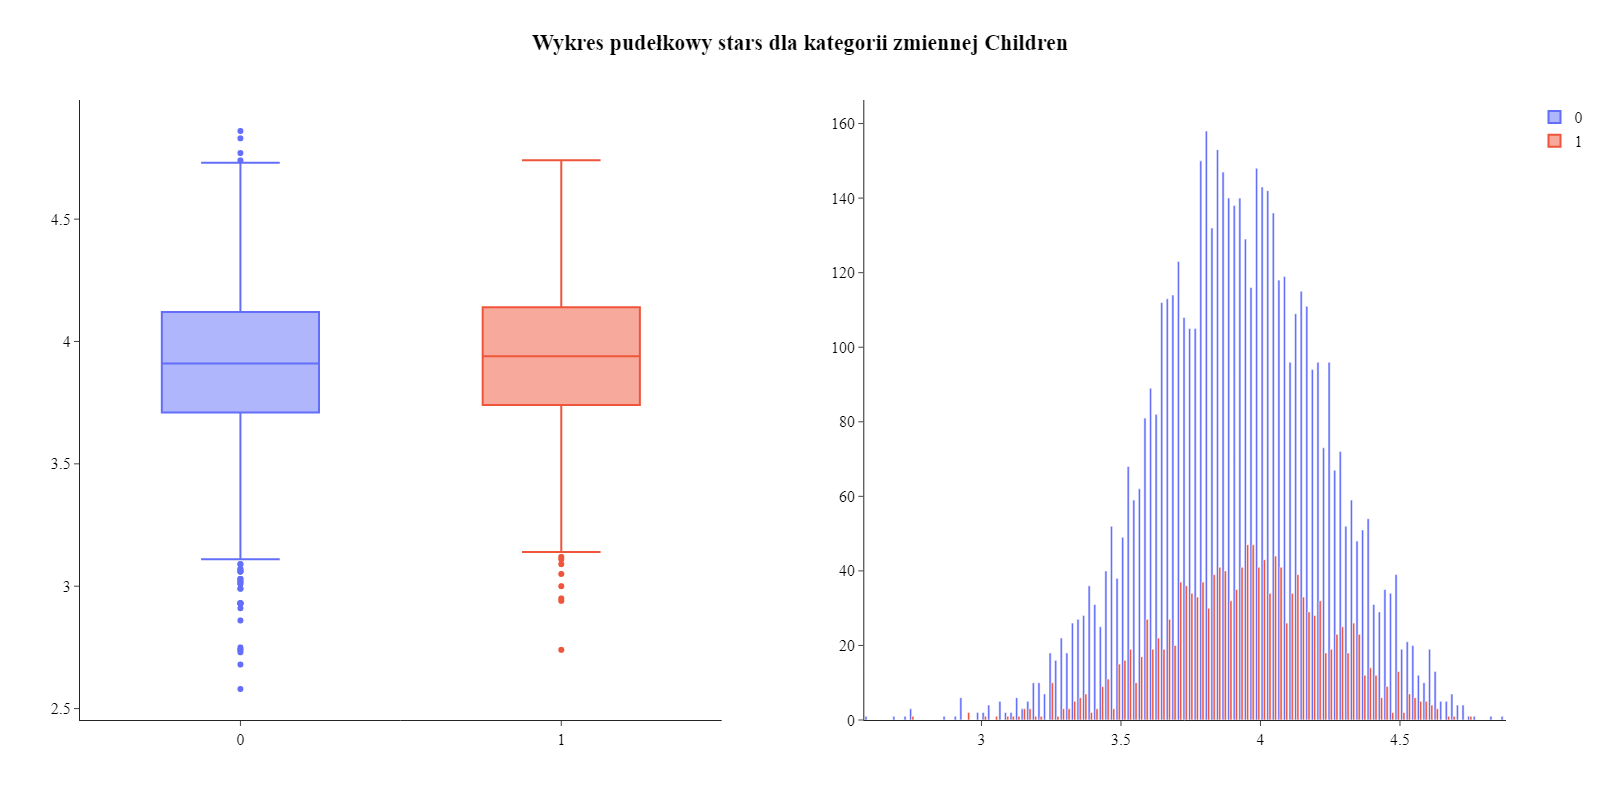

In [215]:
plots.boxplot_by_categorical(data, categorical='Children', target=target)

### Romans

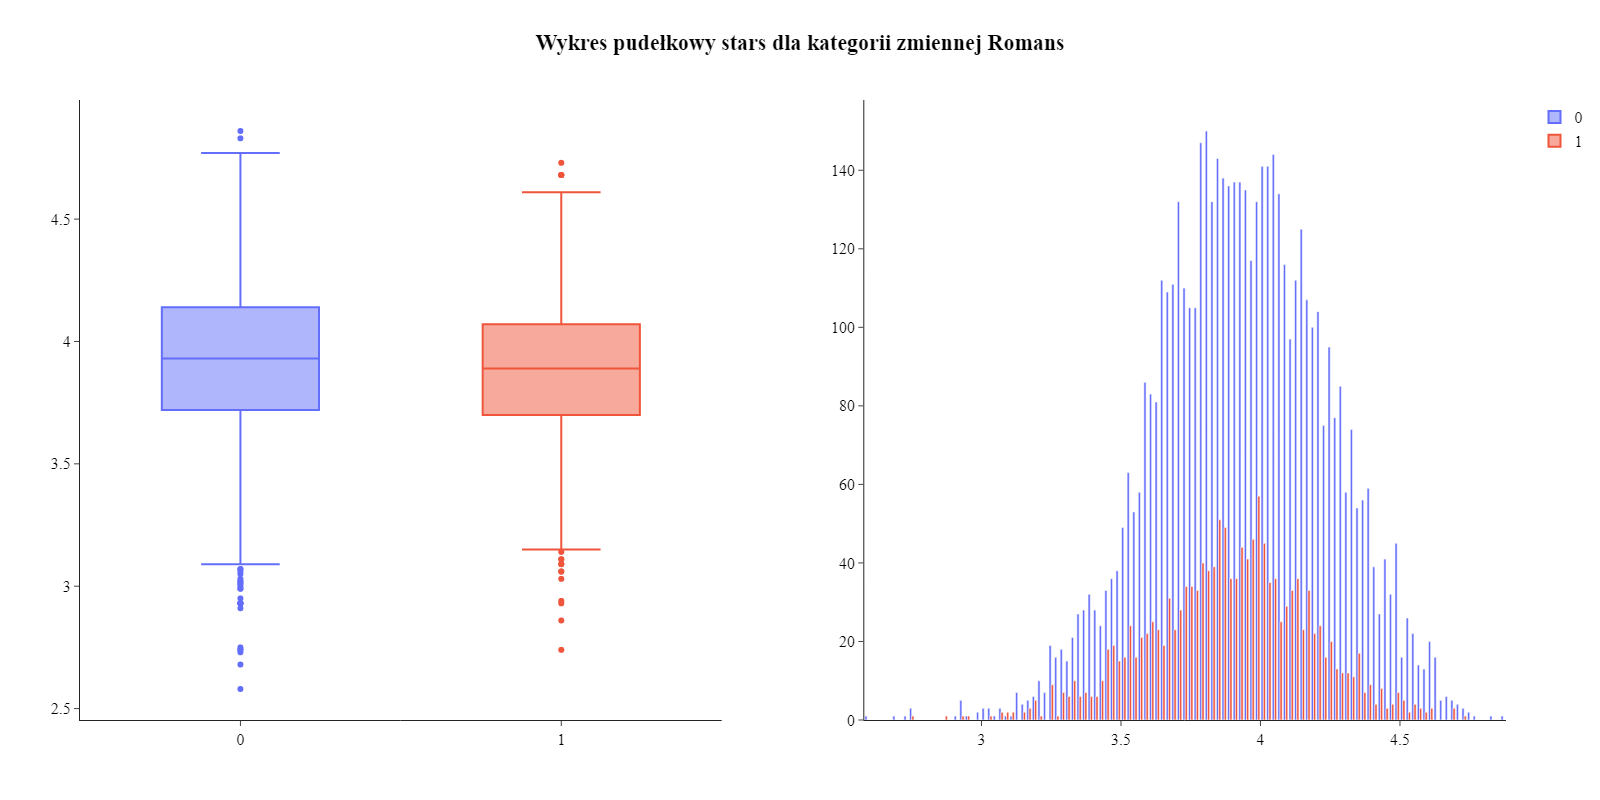

In [216]:
plots.boxplot_by_categorical(data, categorical='Romans', target=target)

$\text{Wnioski:}$<p>
$\text{1. W większości przypadków rozkład zmiennej celu nie różni się znacząco w zależności od wartości zmiennej kategorycznej.}$<p>
$\text{2. Widać, że średnio książki z kategorii Nonfiction są lepiej ocenianie niż książki z kategorii Fiction.}$<p>
$\text{3. W przypadku zmiennych: Fanatasy i Social mediana oceny książki jest nieznacznie wyższa dla książek z danej kategorii.}$<p>
$\text{4. W przypadku zmiennych: Romance i Crime mediana oceny książki jest nieznacznie niższa dla książek z danej kategorii.}$

## Rozkład zmiennej celu w zależności od zmiennych ciągłych

$\text{W poniższej sekcji przedstawiono rozkład zmiennej celu w zależności od rozkładu zmiennych ciągłych.}$<p>
$\text{Po przedstawieniu wszystkich wykresów zapiszemy kilka wniosków.}$

### pages

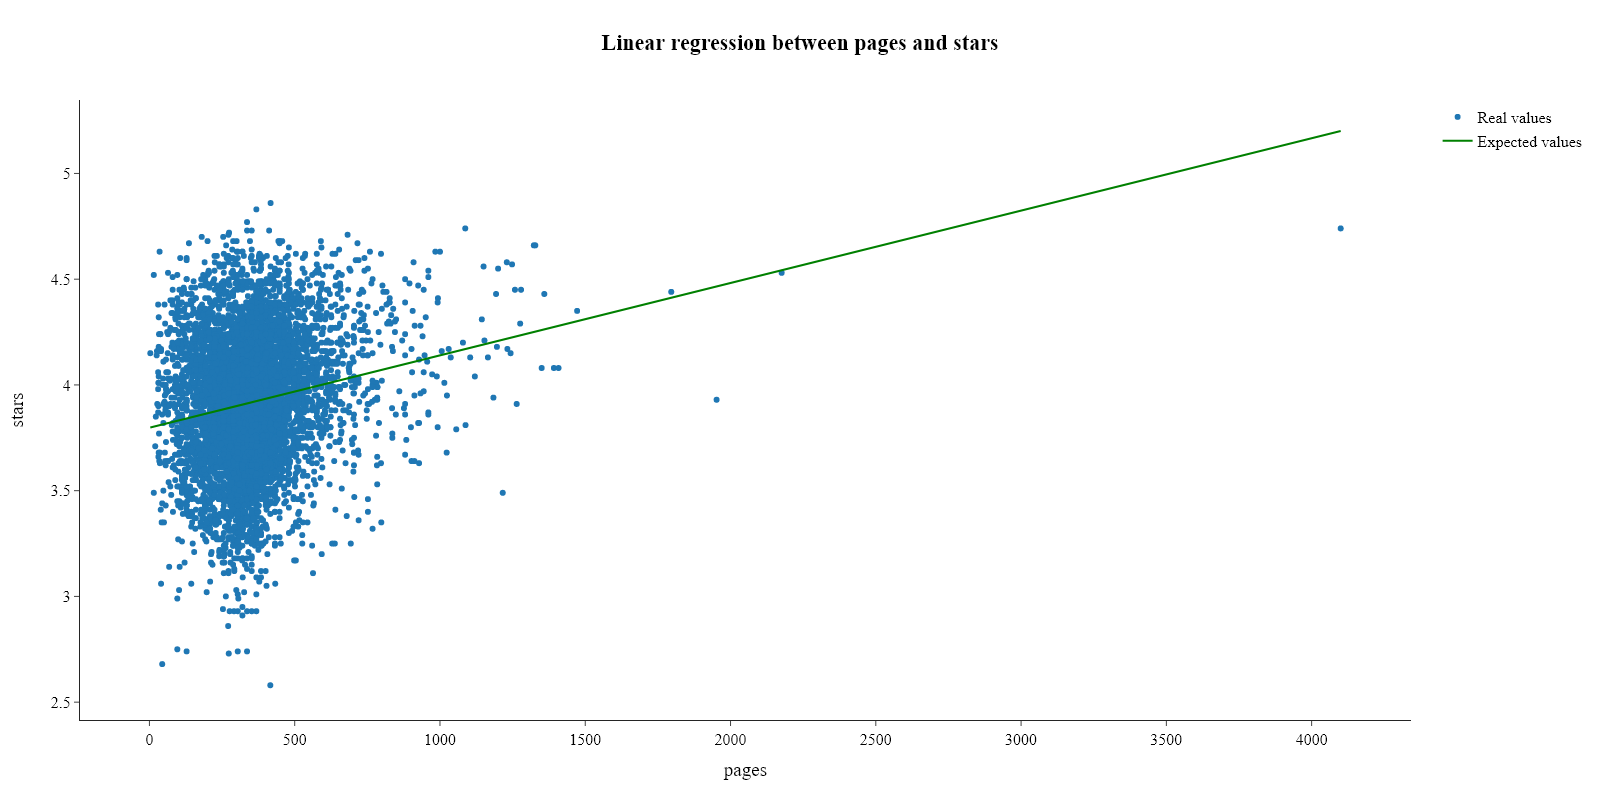

In [61]:
plots.linear_regression_plot(data, feature="pages", target=target)

### reviews

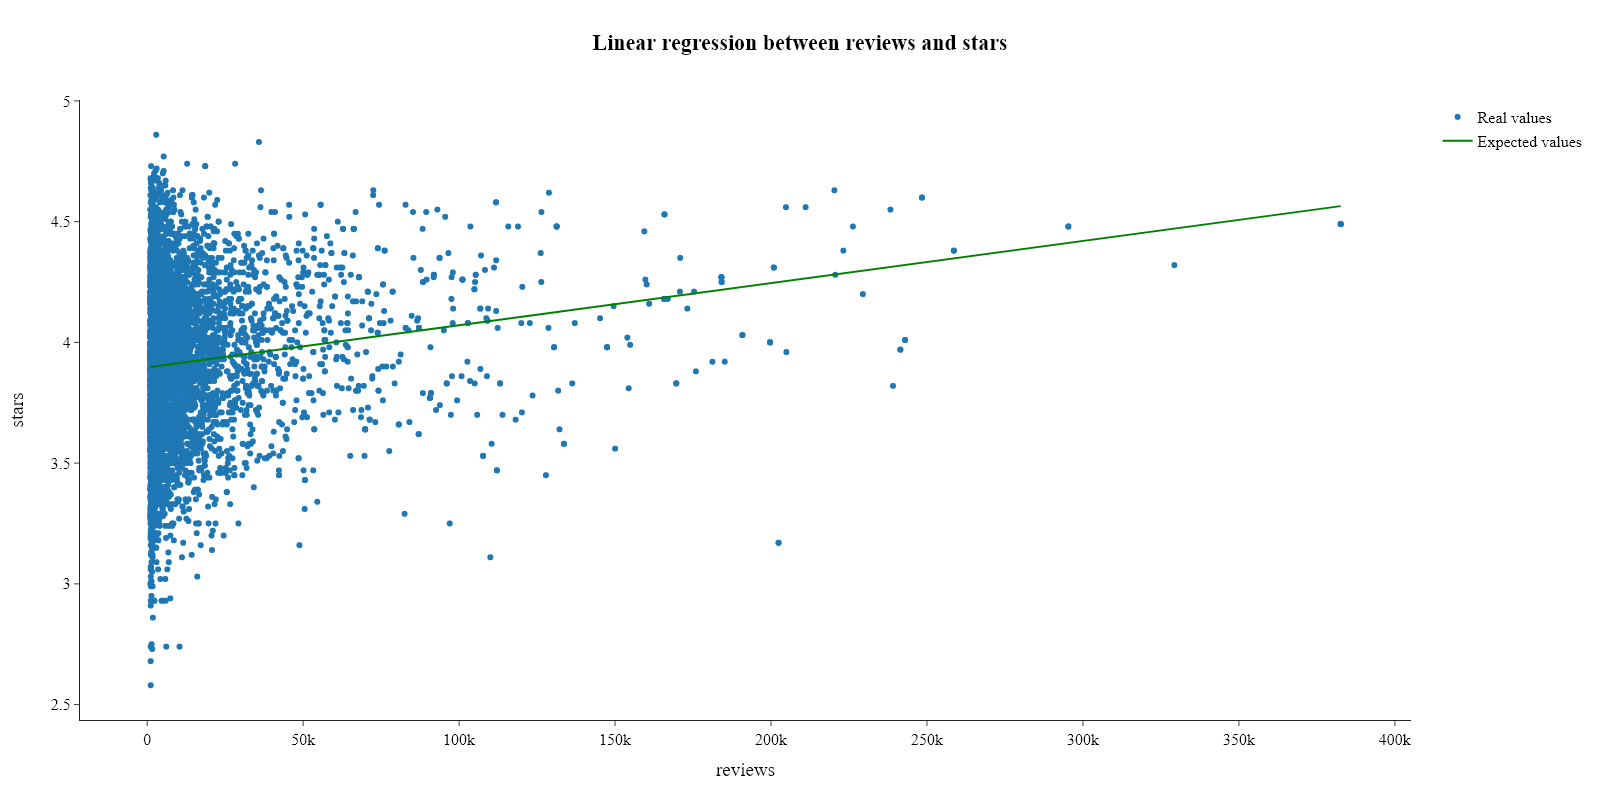

In [62]:
plots.linear_regression_plot(data, feature="reviews", target=target)

### mix

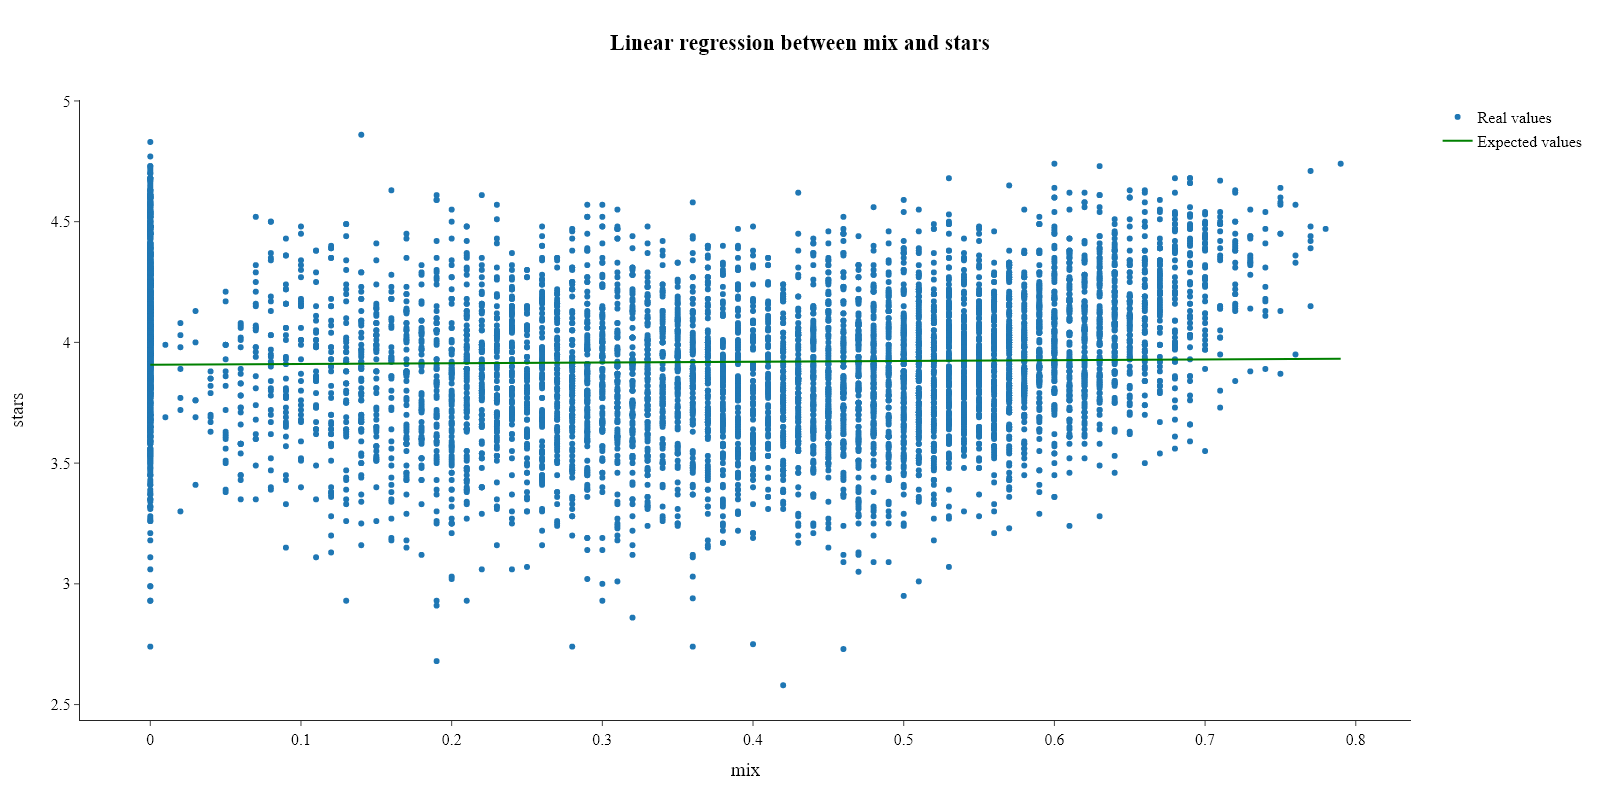

In [63]:
plots.linear_regression_plot(data, feature="mix", target=target)

### character

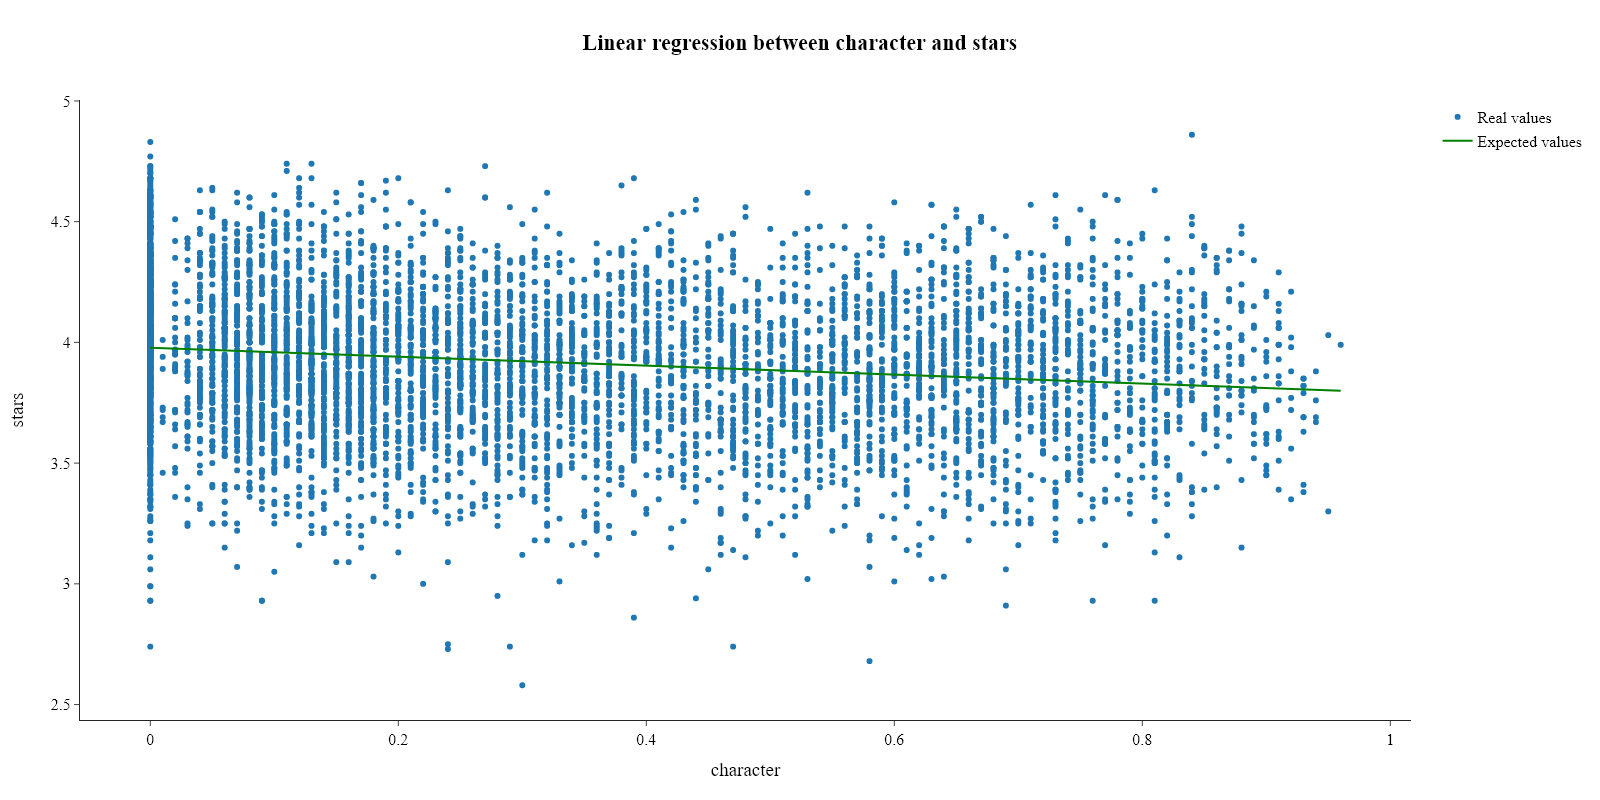

In [64]:
plots.linear_regression_plot(data, feature="character", target=target)

### plot

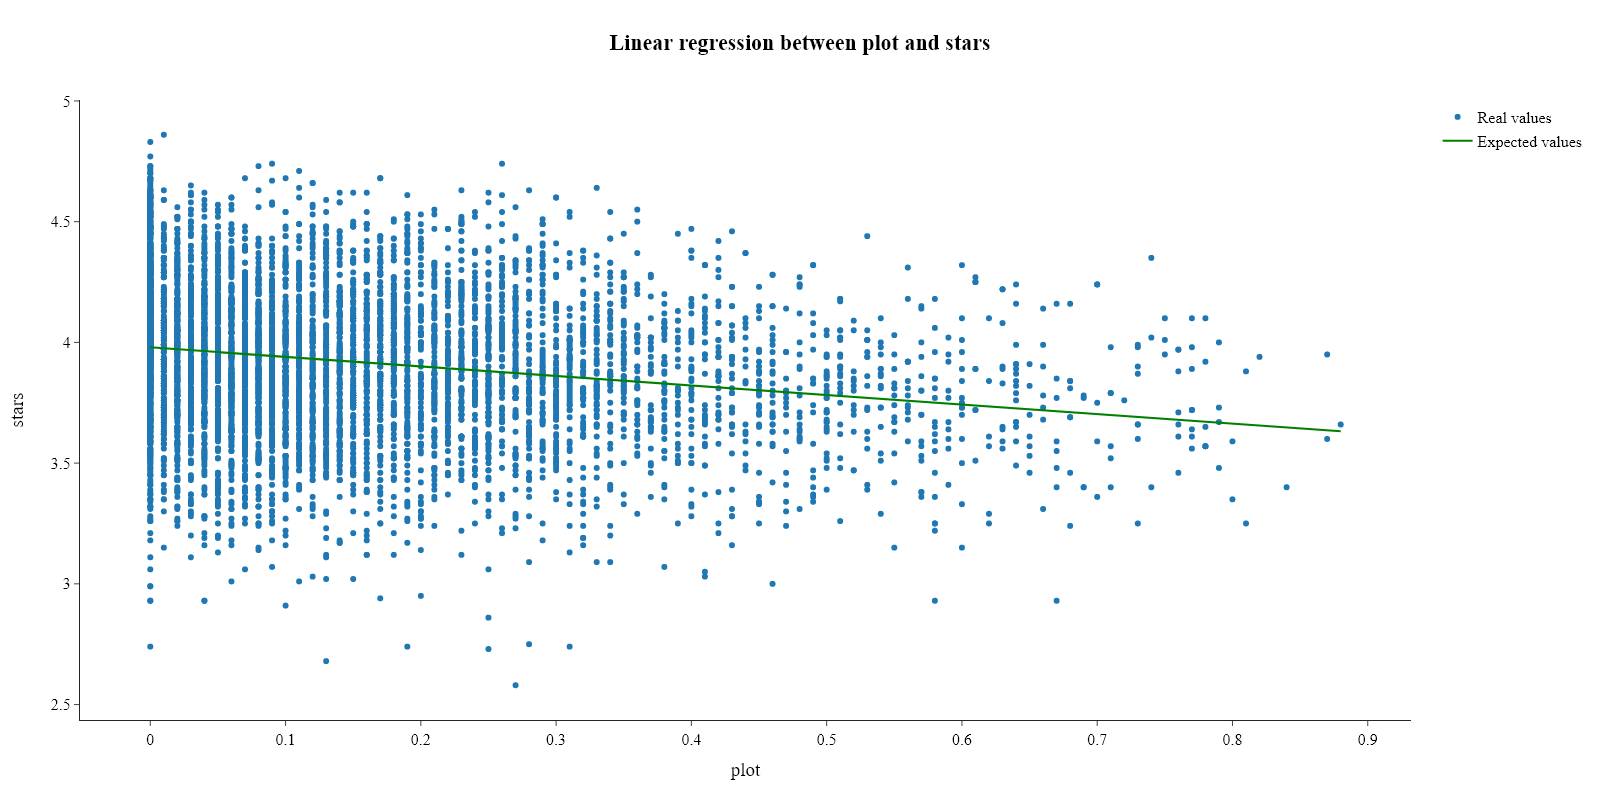

In [65]:
plots.linear_regression_plot(data, feature="plot", target=target)

### funny

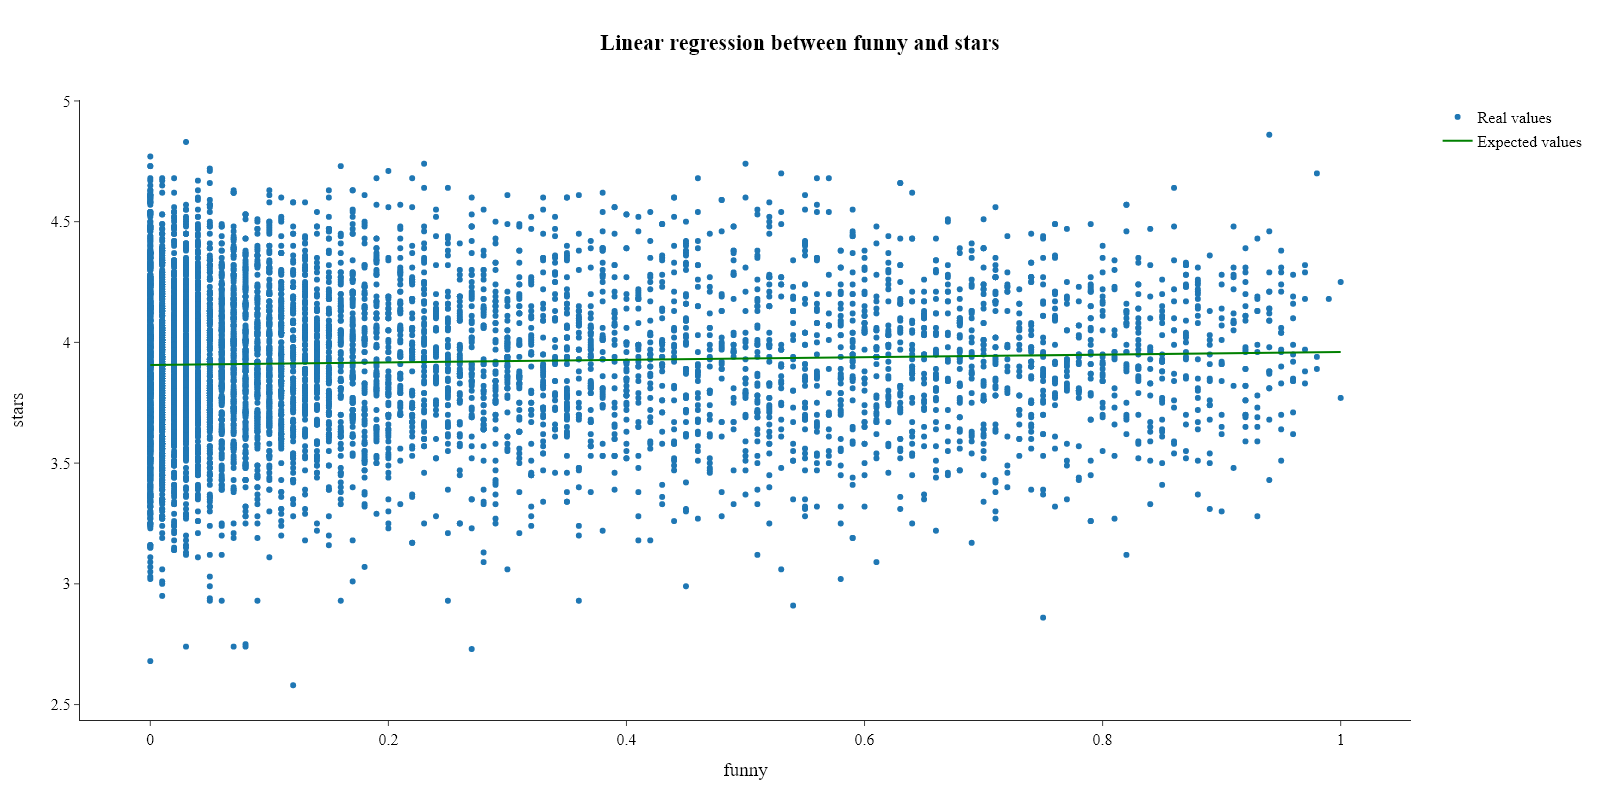

In [67]:
plots.linear_regression_plot(data, feature="funny", target=target)

### lighthearted

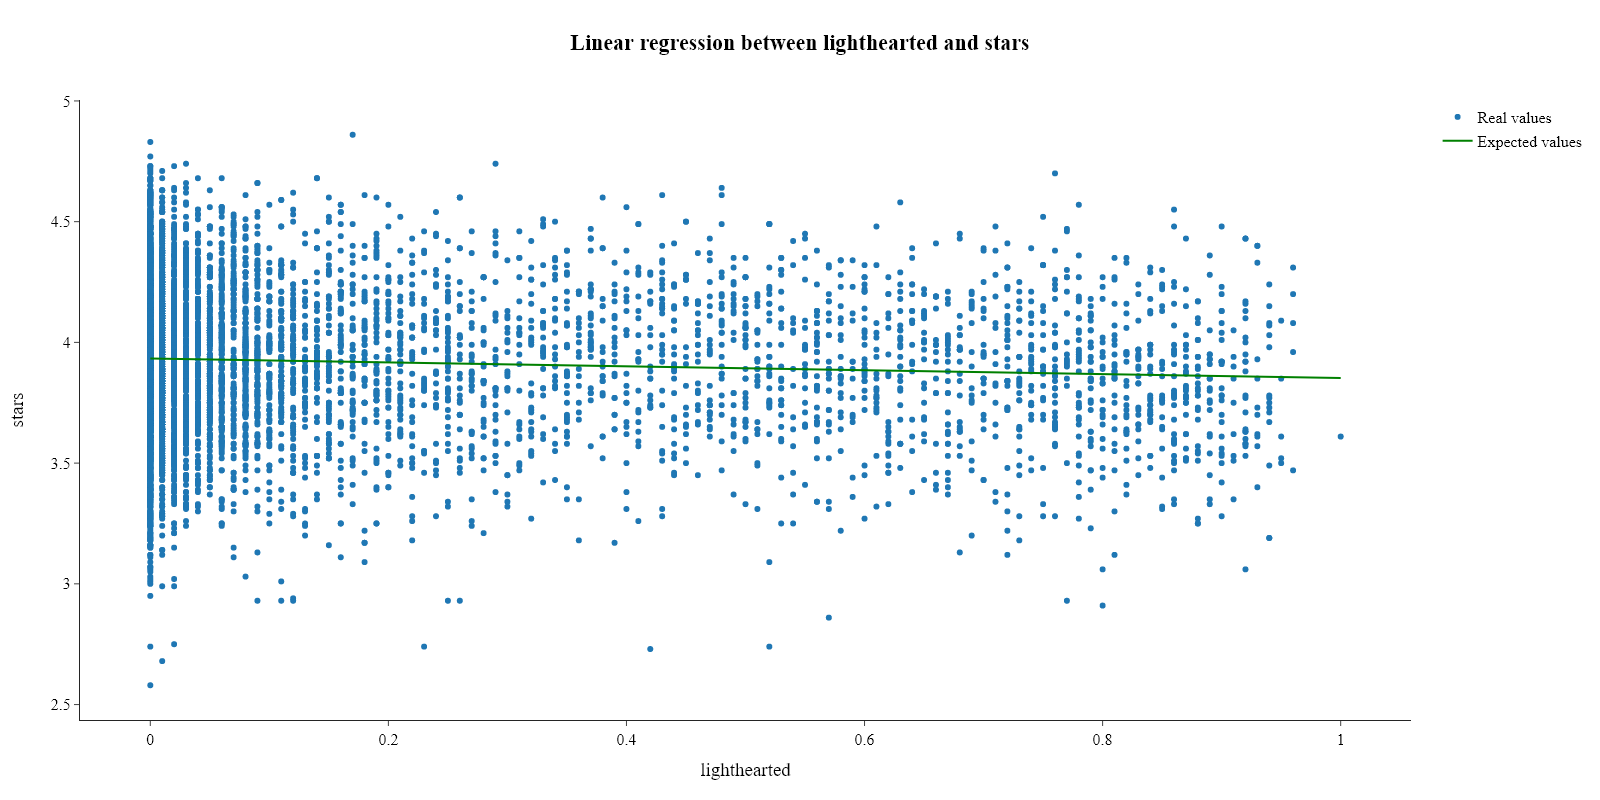

In [68]:
plots.linear_regression_plot(data, feature="lighthearted", target=target)

### emotional

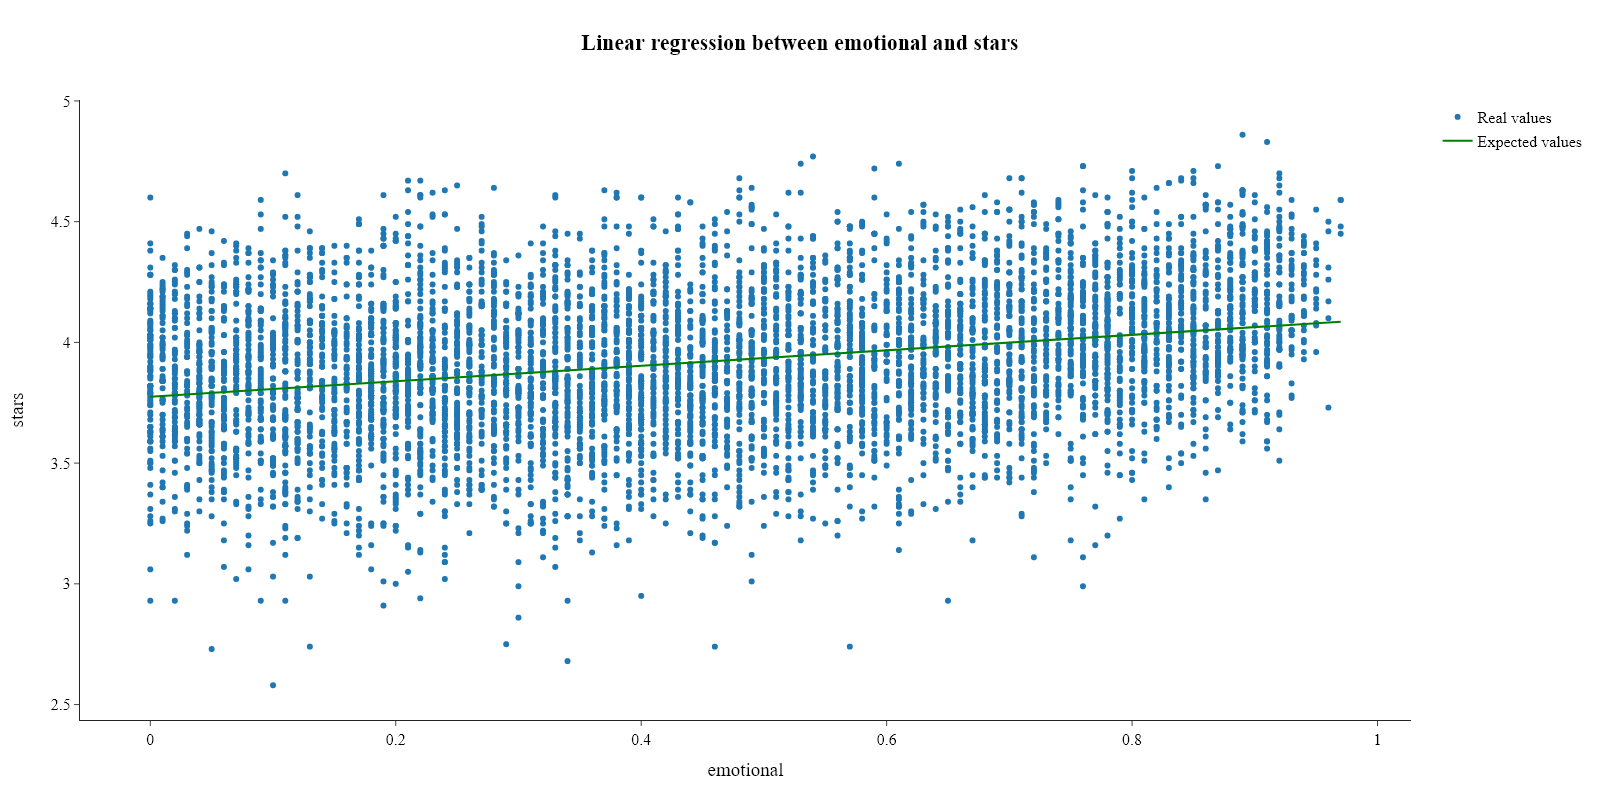

In [69]:
plots.linear_regression_plot(data, feature="emotional", target=target)

### hopeful

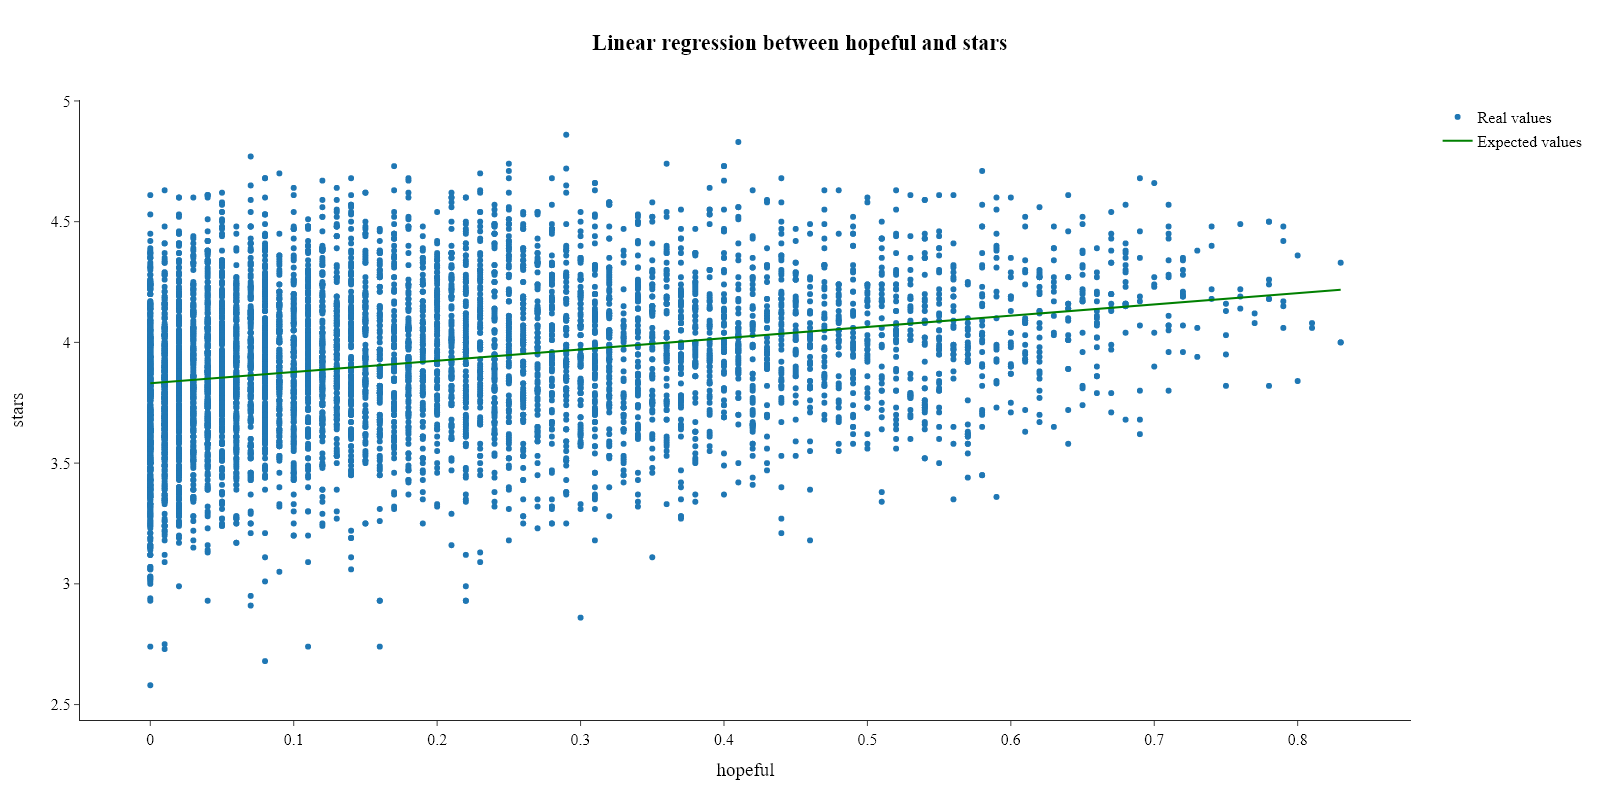

In [70]:
plots.linear_regression_plot(data, feature="hopeful", target=target)

### inspiring

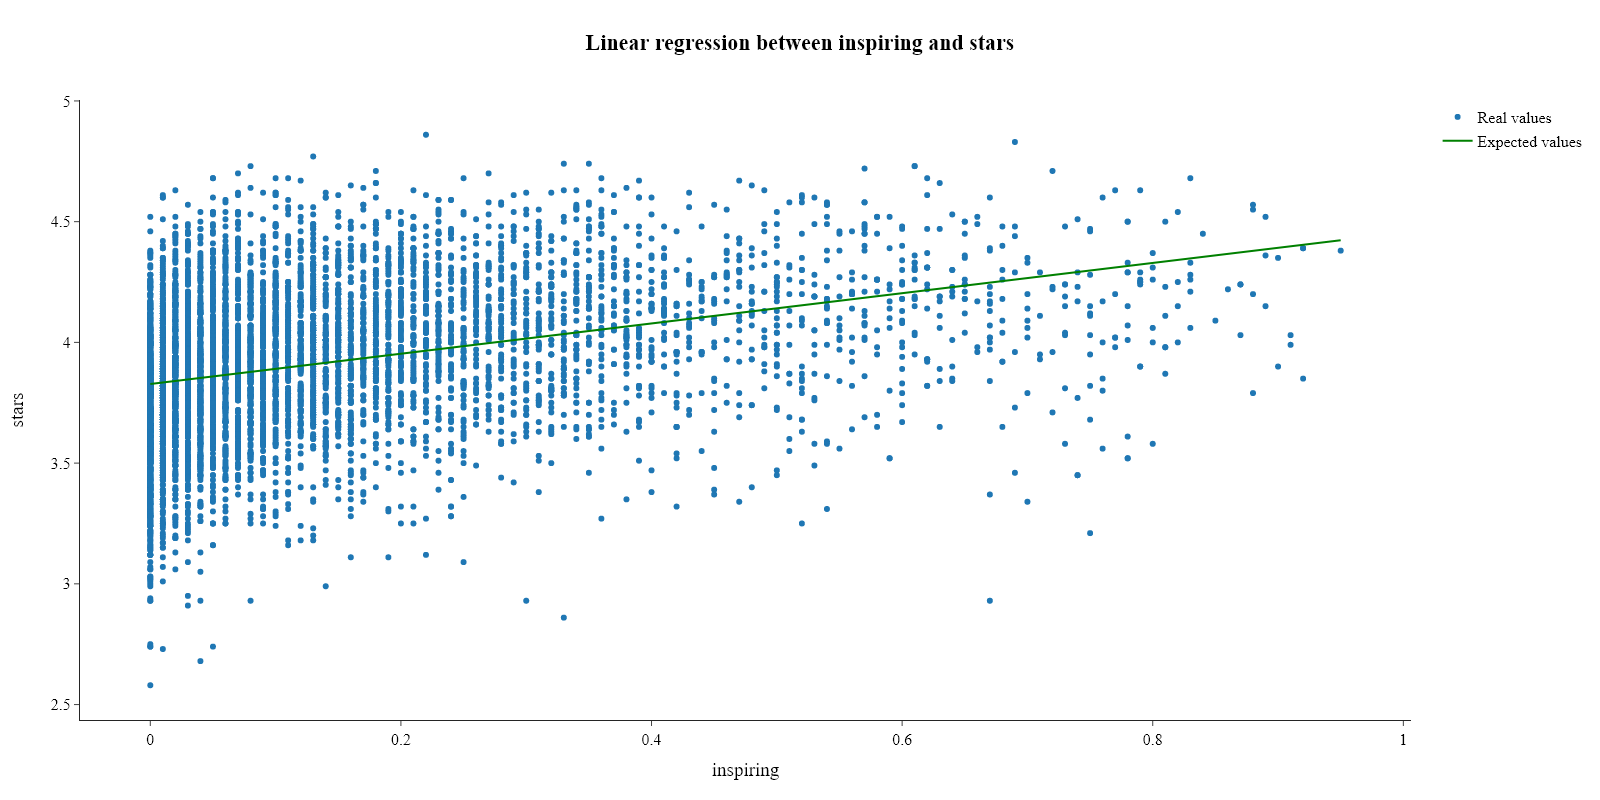

In [71]:
plots.linear_regression_plot(data, feature="inspiring", target=target)

### relaxing

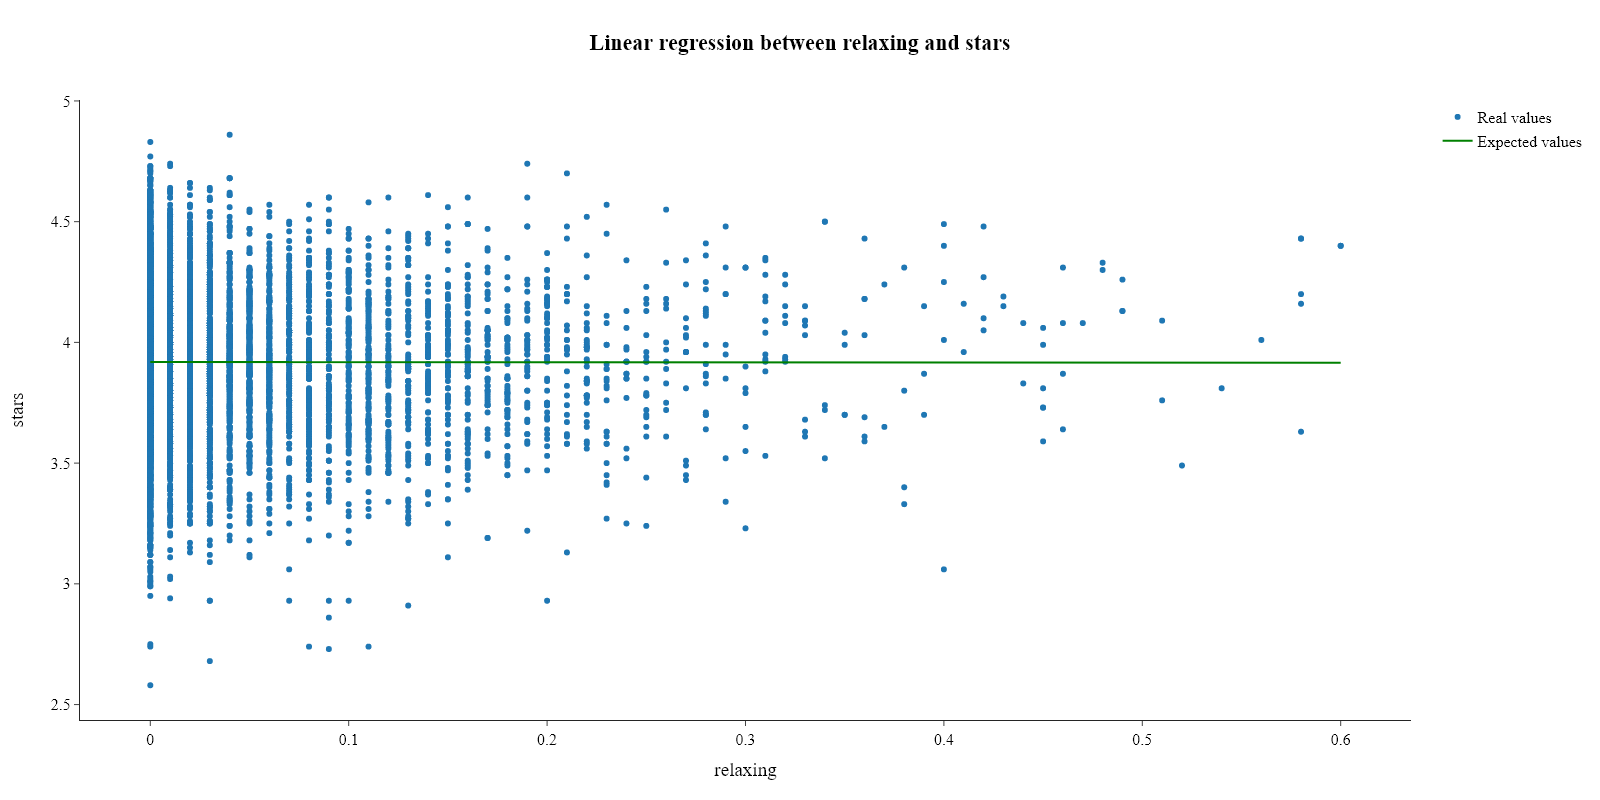

In [72]:
plots.linear_regression_plot(data, feature="relaxing", target=target)

### tense

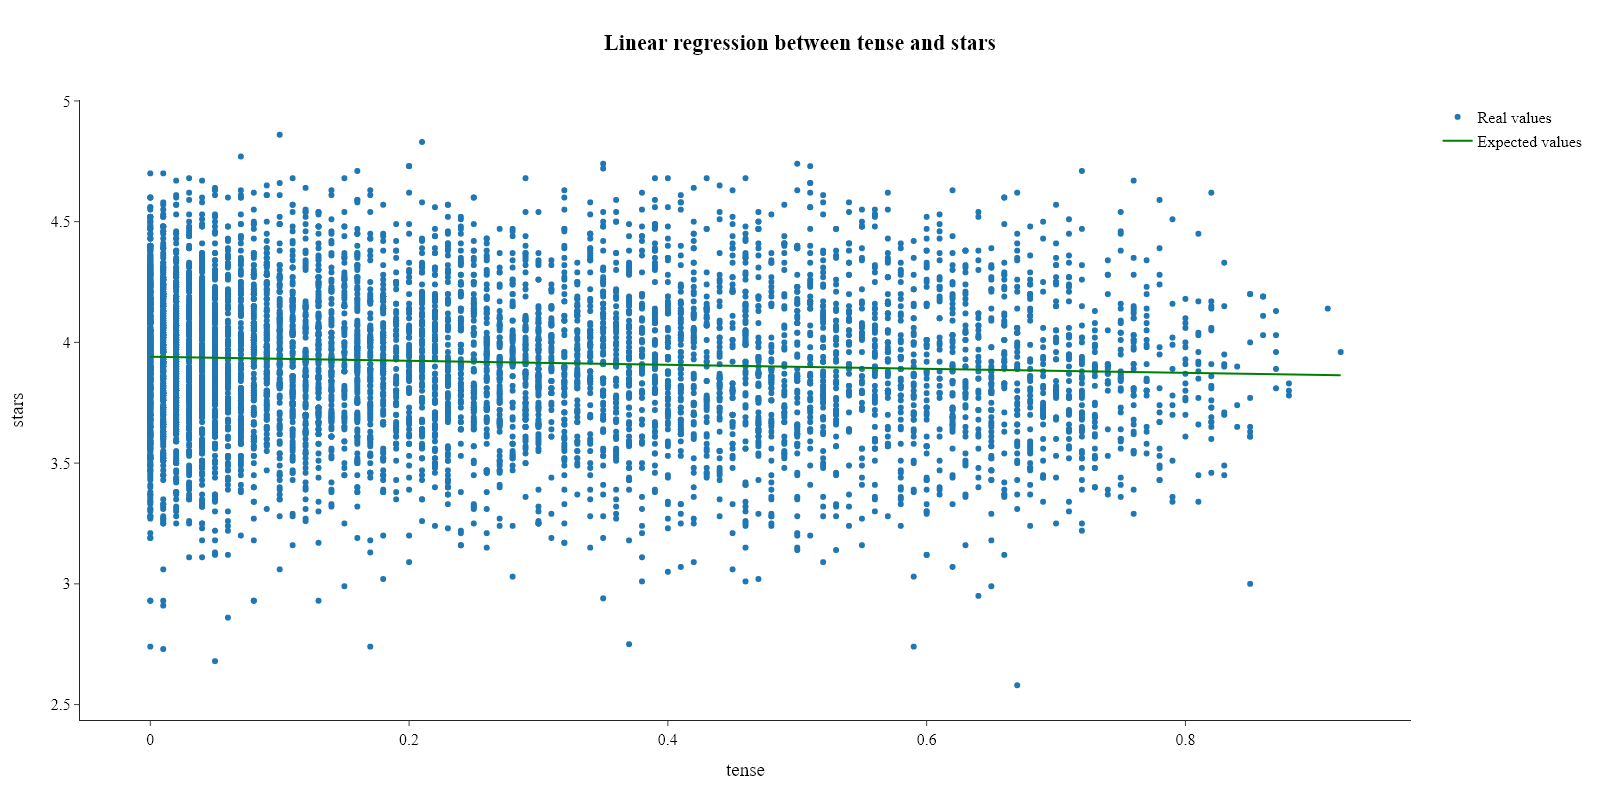

In [73]:
plots.linear_regression_plot(data, feature="tense", target=target)

### sad

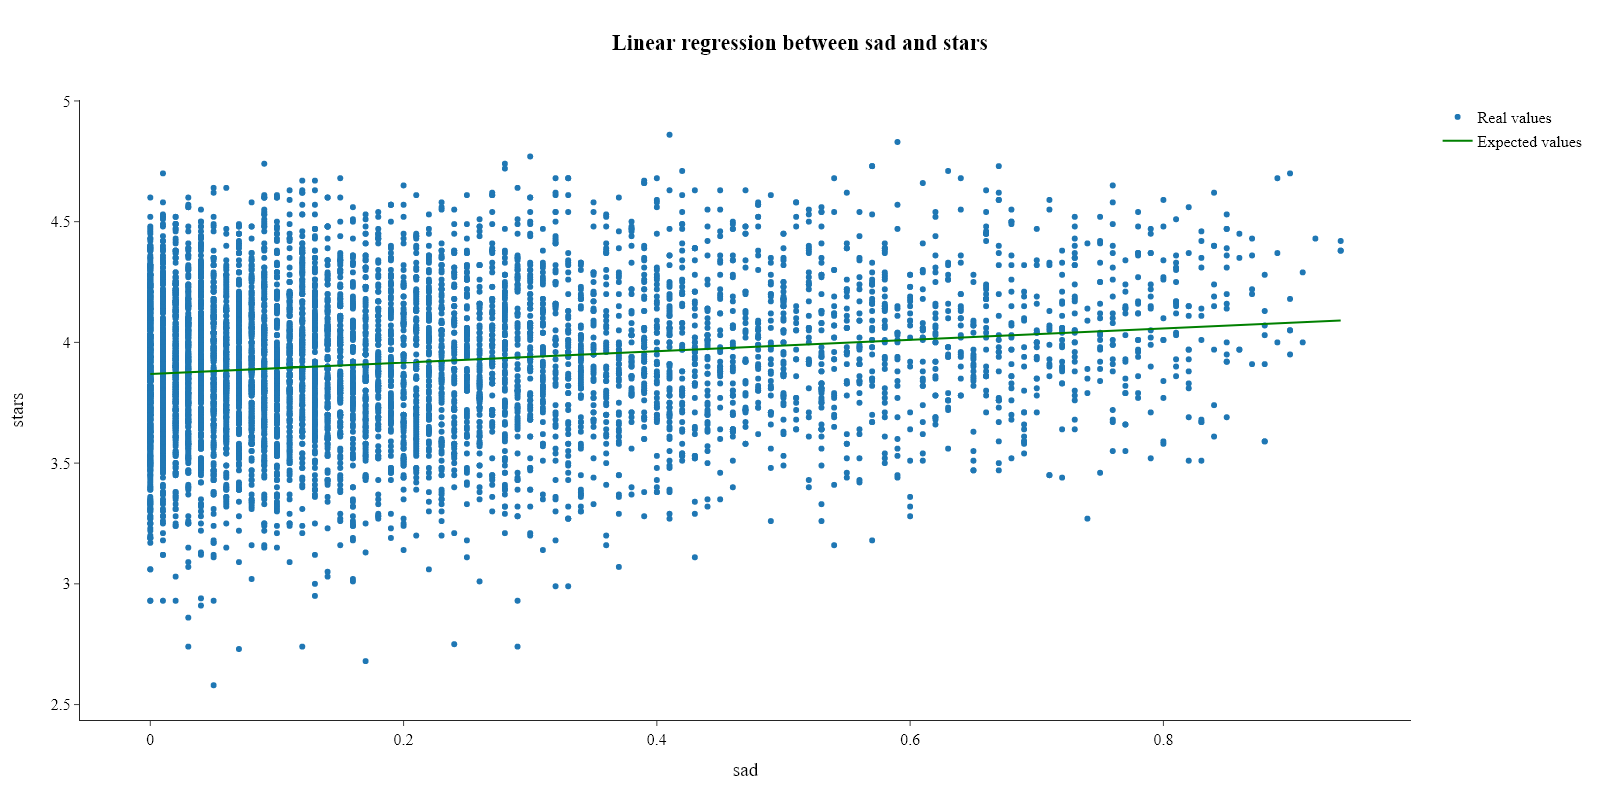

In [74]:
plots.linear_regression_plot(data, feature="sad", target=target)

### reflective

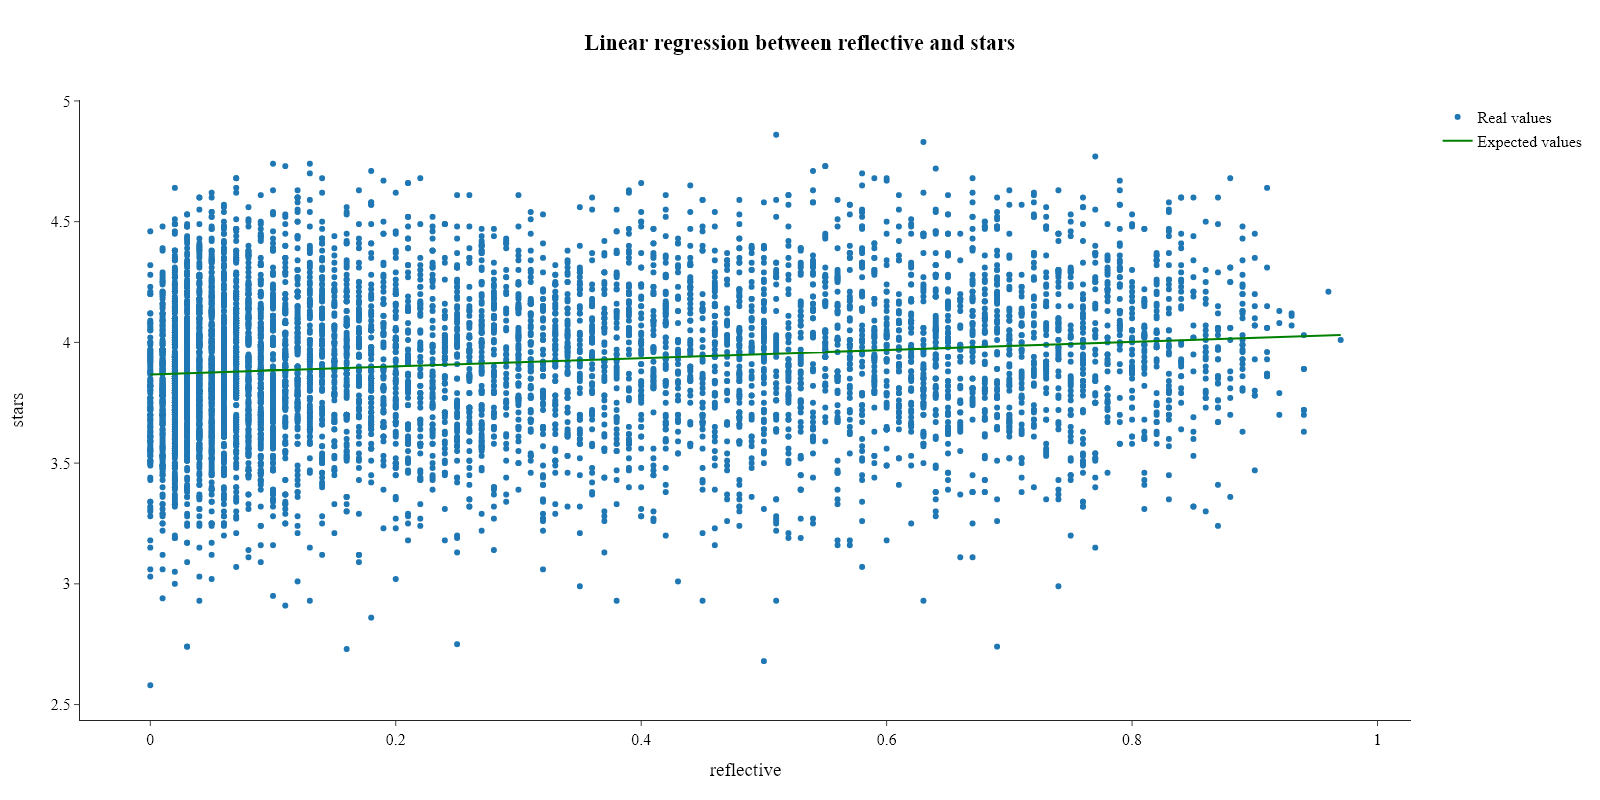

In [75]:
plots.linear_regression_plot(data, feature="reflective", target=target)

### adventurous

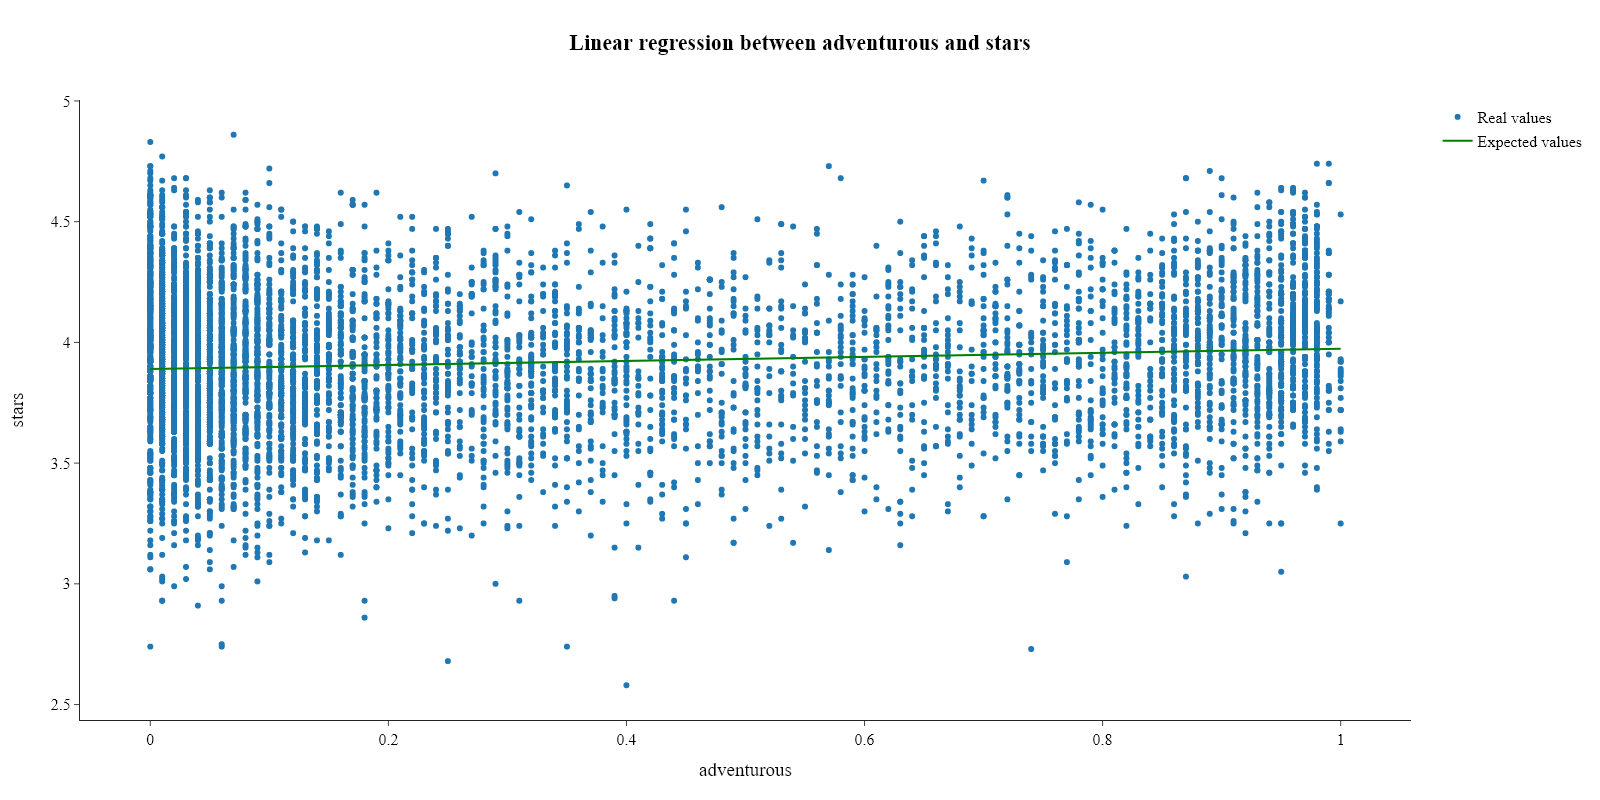

In [76]:
plots.linear_regression_plot(data, feature="adventurous", target=target)

### challenging

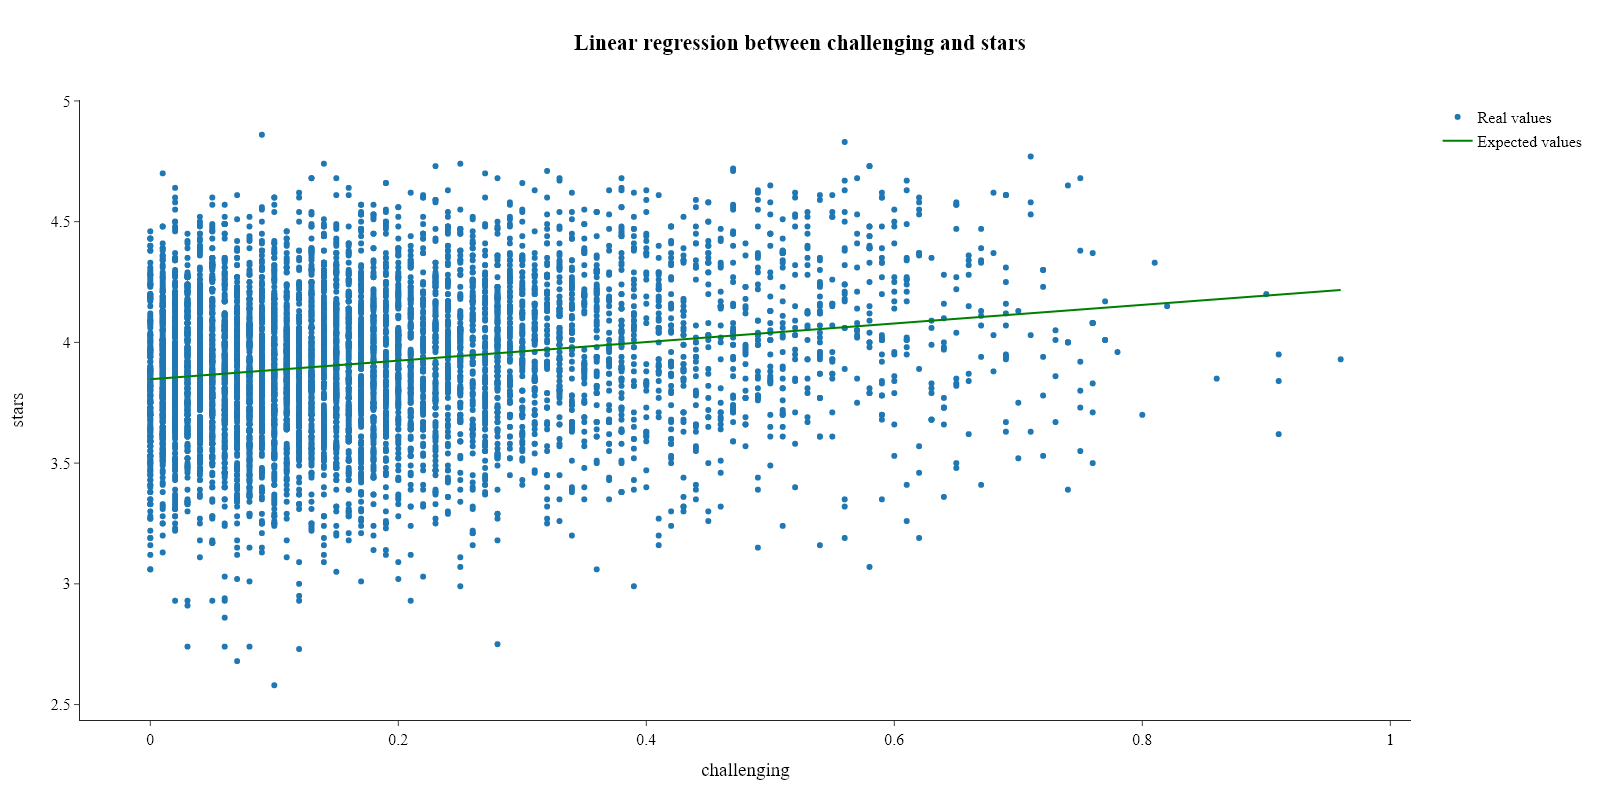

In [77]:
plots.linear_regression_plot(data, feature="challenging", target=target)

### informative

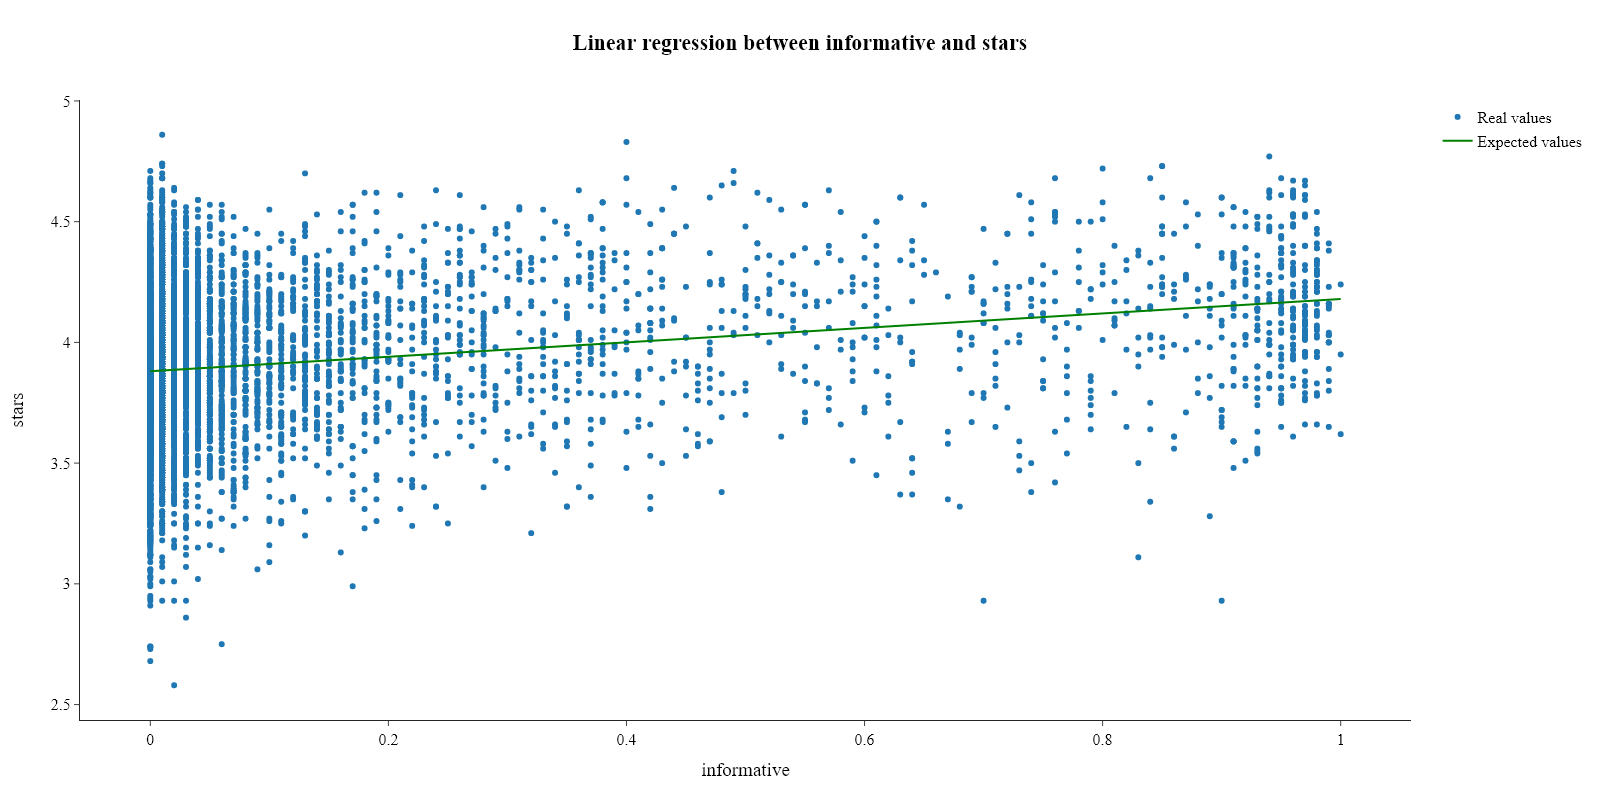

In [78]:
plots.linear_regression_plot(data, feature="informative", target=target)

### mysterious

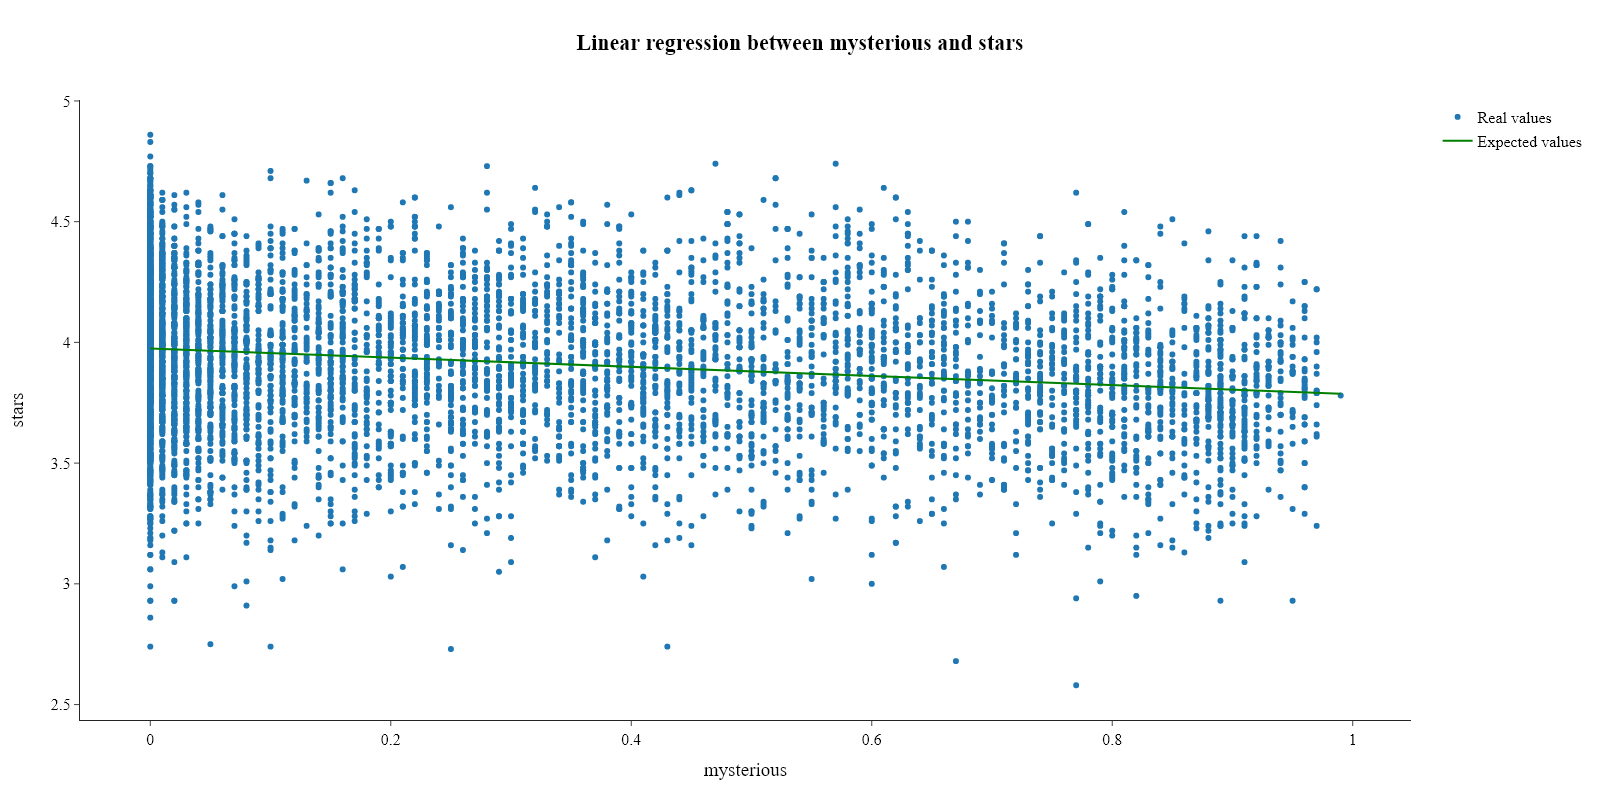

In [79]:
plots.linear_regression_plot(data, feature="mysterious", target=target)

### dark

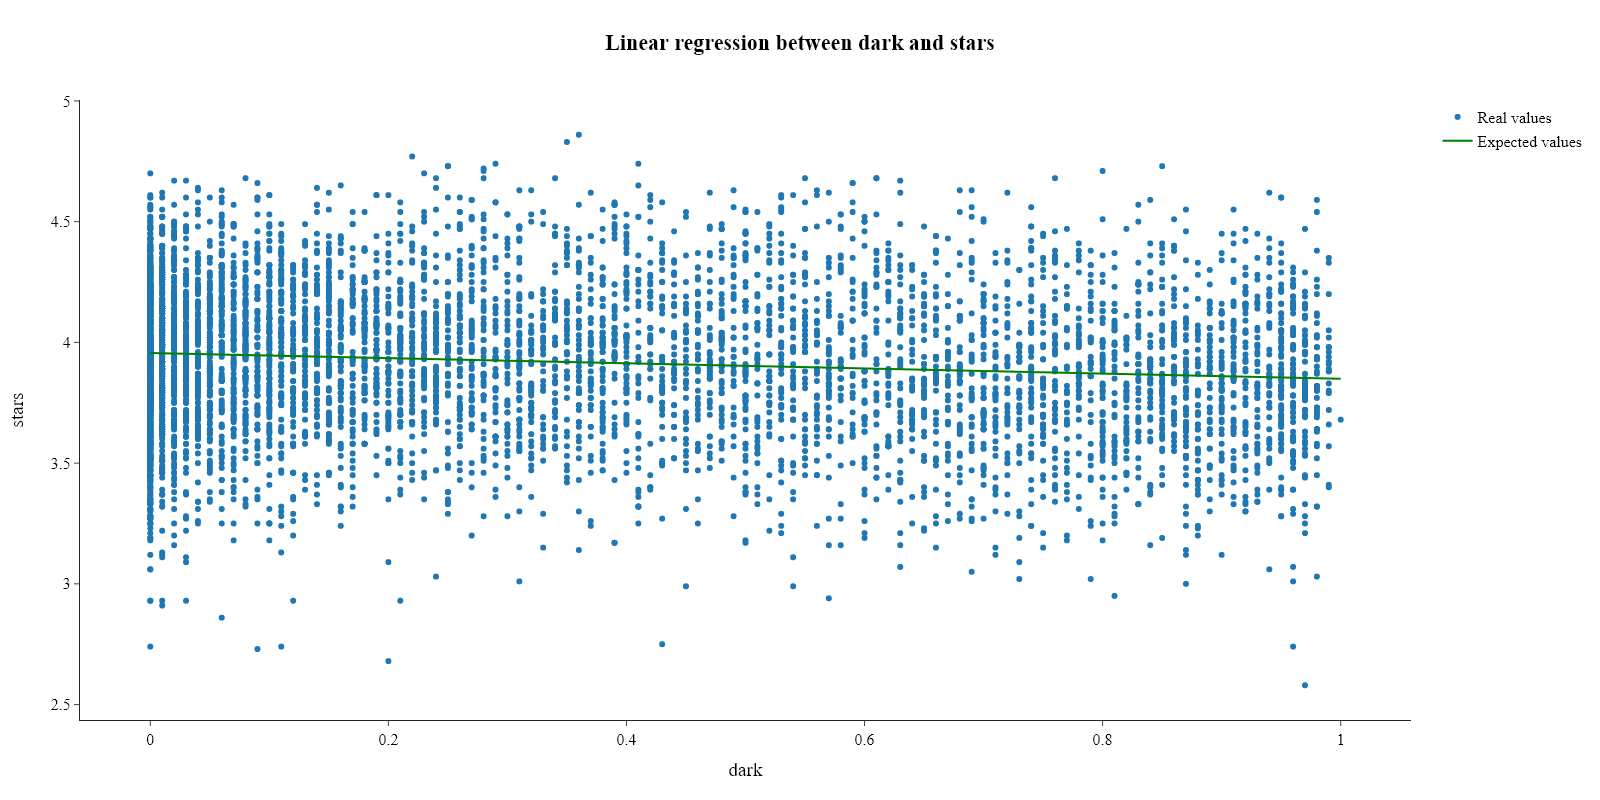

In [80]:
plots.linear_regression_plot(data, feature="dark", target=target)

$\text{Wnioski:}$<p>
$\text{1. Brak liniowych zależności między zmiennymi ciągłymi a zmienną celu.}$<p>
$\text{2. W przypadku niektórych cech (np.: mix, funny, czy relaxing) linia trendu jest pozioma, co sugeruje, że nie ma zależności między tymi zmienną a stars.}$

# Redundant data

$\text{Sekcja będzie poświęcona analizie zbioru w celu znalezienia zbędnych danych/zmiennych.}$<p>
$\text{W tym celu posługiwać się będziemy metodami statystycznymi.}$

## Korelacja

$\text{Poniższy wykres przedstawia korelację Pearsona między zmiennymi ciągłymi oraz zmienną celu.}$

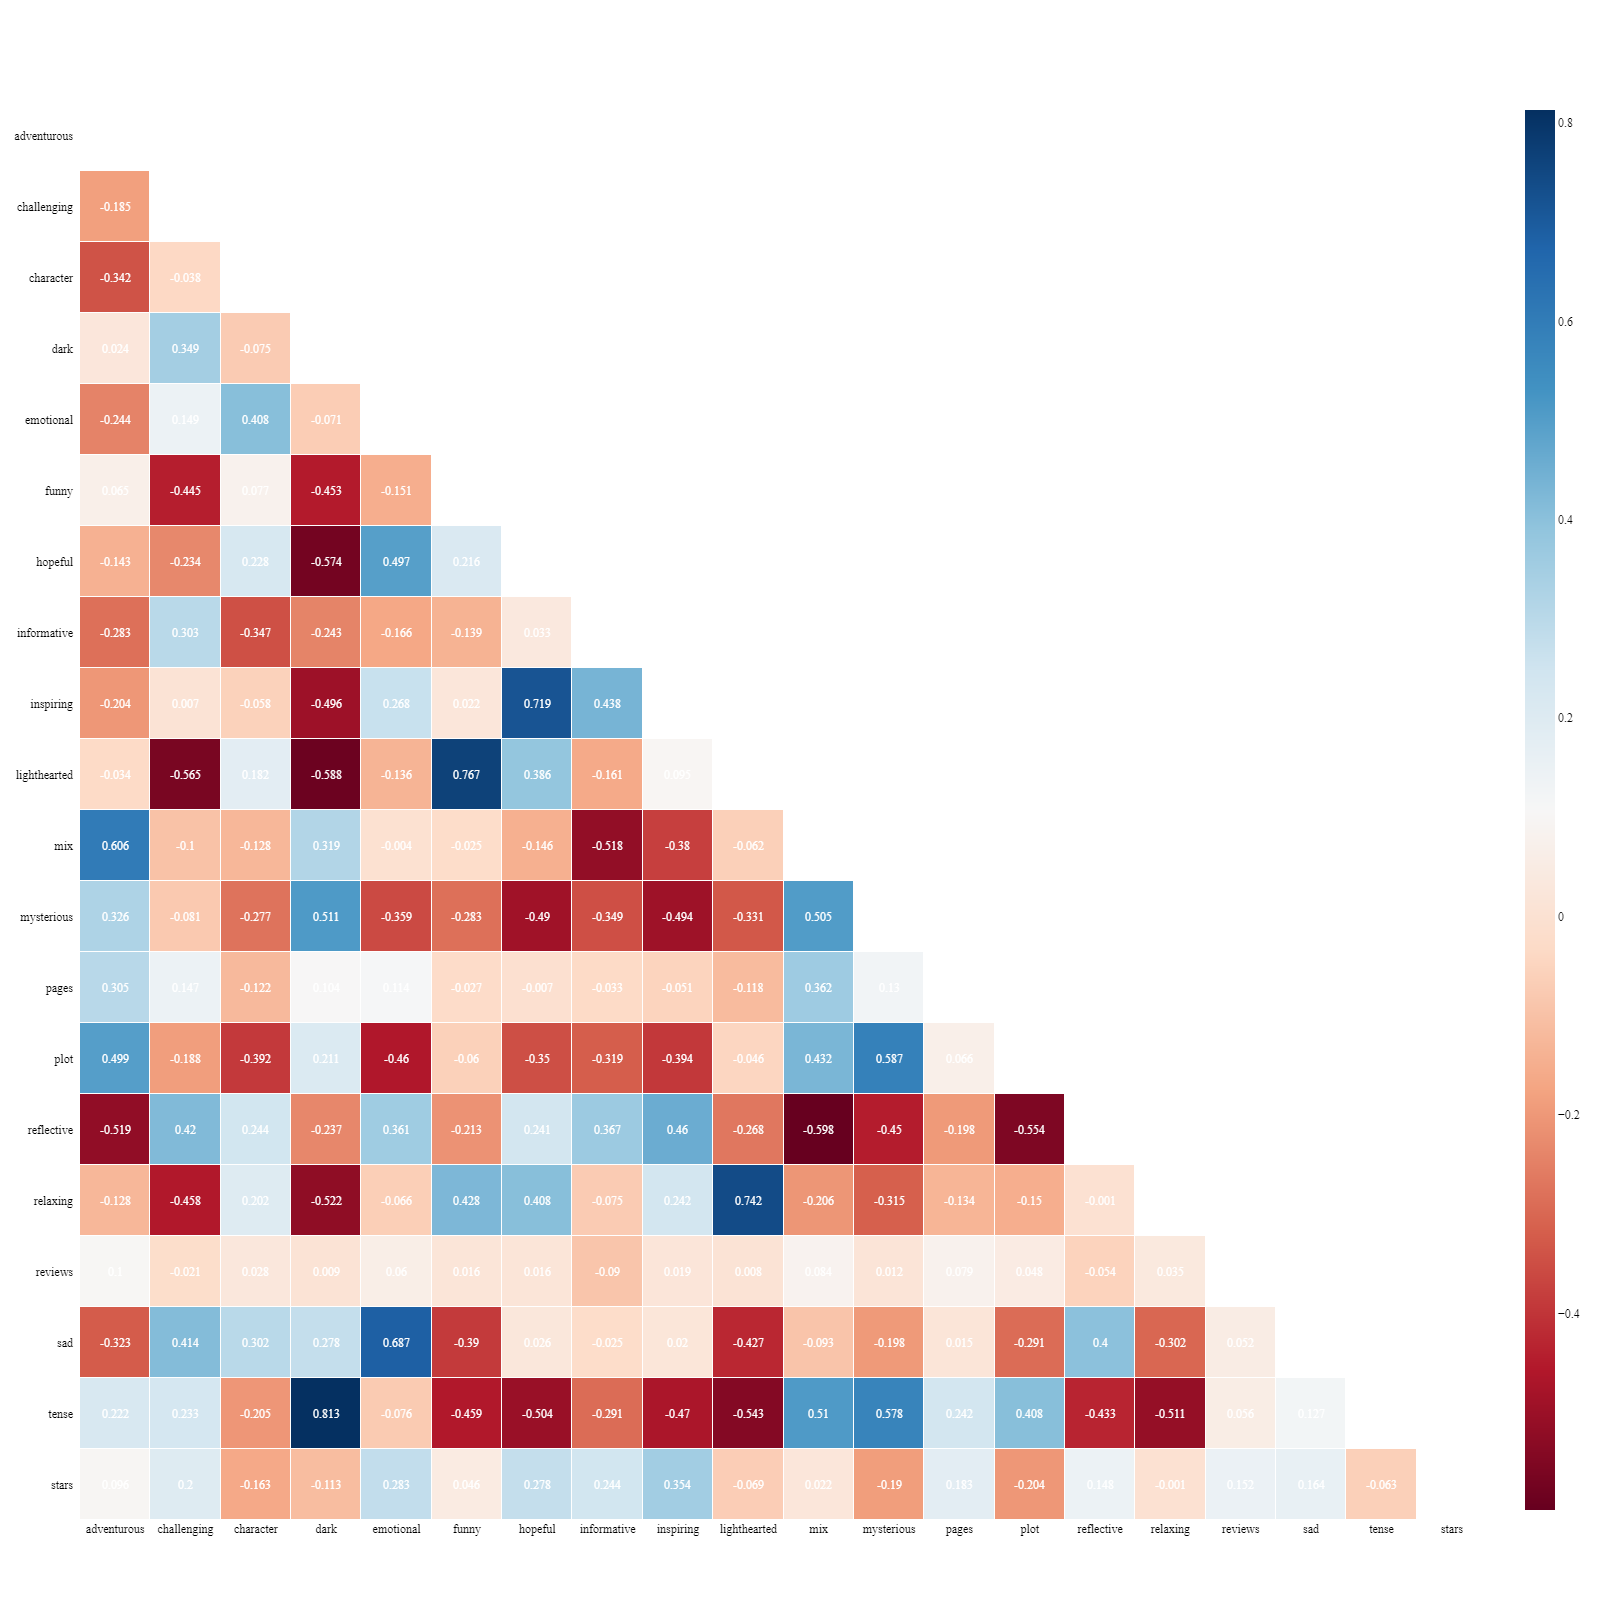

In [220]:
plots.correlation_plot(data=data[continous_features+[target]], features_names=data[continous_features+[target]].columns.tolist())

$\text{Macierz korelacji potwierdza, że między zmiennymi ciągłymi, a zmienną celu nie występuje silna liniowa korelacja.}$<p>
$\text{Warto jednak odnotować, że między niektórymi cechami objaśniającymi występuje wysoka wartość współczynnika korelacji Pearsona.}$<p>
$\text{Współczynnik korelacji Pearsona można zastosować tylko w sytuacji, gdy założenie o rozkładzie normalnym zmiennych jest zachowane.}$<p>
$\text{Pomimo tego, że histogramy przedstawione wyżej nie wskazują na to, aby cechy rozkład normalny, zweryfikujemy to za pomocą testu statystycznego Jarque-Bera.}$

In [250]:
for feature in continous_features:
    y_subset = data[feature]
    if(stats.jarque_bera(y_subset).pvalue > 0.05):
        print("{} ma rozkład normalny, ponieważ p_value > alpha ({} >= {}).".format(feature, round(stats.jarque_bera(y_subset).pvalue, 3), 0.05))
    else:
        print("{} nie ma rozkładu normalnego, ponieważ p_value < alpha ({} < {}).".format(feature, round(stats.jarque_bera(y_subset).pvalue, 3), 0.05))

adventurous nie ma rozkładu normalnego, ponieważ p_value < alpha (0.0 < 0.05).
challenging nie ma rozkładu normalnego, ponieważ p_value < alpha (0.0 < 0.05).
character nie ma rozkładu normalnego, ponieważ p_value < alpha (0.0 < 0.05).
dark nie ma rozkładu normalnego, ponieważ p_value < alpha (0.0 < 0.05).
emotional nie ma rozkładu normalnego, ponieważ p_value < alpha (0.0 < 0.05).
funny nie ma rozkładu normalnego, ponieważ p_value < alpha (0.0 < 0.05).
hopeful nie ma rozkładu normalnego, ponieważ p_value < alpha (0.0 < 0.05).
informative nie ma rozkładu normalnego, ponieważ p_value < alpha (0.0 < 0.05).
inspiring nie ma rozkładu normalnego, ponieważ p_value < alpha (0.0 < 0.05).
mix nie ma rozkładu normalnego, ponieważ p_value < alpha (0.0 < 0.05).
mysterious nie ma rozkładu normalnego, ponieważ p_value < alpha (0.0 < 0.05).
pages nie ma rozkładu normalnego, ponieważ p_value < alpha (0.0 < 0.05).
plot nie ma rozkładu normalnego, ponieważ p_value < alpha (0.0 < 0.05).
reflective nie ma 

$\text{Wyniki testu Jarque-Bera wskazują, że rozkłady zmiennych nie są normalne.}$<p>
$\text{W związku z tym zastosujemy testy nieparametryczne, które nie wymagają spełnienia założenia o normalności rozkładu.}$<p>
$\text{Do analizy korelacji wykorzystamy zatem test Spearmana.}$

In [225]:
i = 0
while(i < len(continous_features)):
    j = i+1
    while(j < len(continous_features)):
        if(stats.spearmanr(data[continous_features[i]], data[continous_features[j]]).pvalue < 0.05):
            print("Korelacja między {} i {} jest statystycznie istotna, ponieważ p_value < alpha ({} < {}).".format(continous_features[i], continous_features[j], round(stats.spearmanr(data[continous_features[i]], data[continous_features[j]]).pvalue, 3), 0.05))
        j = j + 1
    i = i + 1

Korelacja między adventurous i challenging jest statystycznie istotna, ponieważ p_value < alpha (0.0 < 0.05).
Korelacja między adventurous i character jest statystycznie istotna, ponieważ p_value < alpha (0.0 < 0.05).
Korelacja między adventurous i dark jest statystycznie istotna, ponieważ p_value < alpha (0.0 < 0.05).
Korelacja między adventurous i emotional jest statystycznie istotna, ponieważ p_value < alpha (0.0 < 0.05).
Korelacja między adventurous i funny jest statystycznie istotna, ponieważ p_value < alpha (0.0 < 0.05).
Korelacja między adventurous i hopeful jest statystycznie istotna, ponieważ p_value < alpha (0.0 < 0.05).
Korelacja między adventurous i informative jest statystycznie istotna, ponieważ p_value < alpha (0.0 < 0.05).
Korelacja między adventurous i inspiring jest statystycznie istotna, ponieważ p_value < alpha (0.0 < 0.05).
Korelacja między adventurous i lighthearted jest statystycznie istotna, ponieważ p_value < alpha (0.0 < 0.05).
Korelacja między adventurous i m

Korelacja między lighthearted i sad jest statystycznie istotna, ponieważ p_value < alpha (0.0 < 0.05).
Korelacja między lighthearted i tense jest statystycznie istotna, ponieważ p_value < alpha (0.0 < 0.05).
Korelacja między mix i mysterious jest statystycznie istotna, ponieważ p_value < alpha (0.0 < 0.05).
Korelacja między mix i pages jest statystycznie istotna, ponieważ p_value < alpha (0.0 < 0.05).
Korelacja między mix i plot jest statystycznie istotna, ponieważ p_value < alpha (0.0 < 0.05).
Korelacja między mix i reflective jest statystycznie istotna, ponieważ p_value < alpha (0.0 < 0.05).
Korelacja między mix i relaxing jest statystycznie istotna, ponieważ p_value < alpha (0.0 < 0.05).
Korelacja między mix i reviews jest statystycznie istotna, ponieważ p_value < alpha (0.0 < 0.05).
Korelacja między mix i sad jest statystycznie istotna, ponieważ p_value < alpha (0.016 < 0.05).
Korelacja między mix i tense jest statystycznie istotna, ponieważ p_value < alpha (0.0 < 0.05).
Korelacja 

$\text{Jak możemy zaobserwować powyżej, bazując na teście korelacji Spearmana większość zmiennych jest ze sobą statystycznie istotnie skorelowana.}$<p>
$\text{Do powyższego testu wprowadzimy lekką modyfikację w celu zweryfikowania, które zmienne są silnie skorelowane (wartość współczynnika korelacji > 0.8).}$

In [238]:
i = 0
while(i < len(continous_features)):
    j = i+1
    while(j < len(continous_features)):
        if(stats.spearmanr(data[continous_features[i]], data[continous_features[j]]).pvalue < 0.05 and
          stats.spearmanr(data[continous_features[i]], data[continous_features[j]]).statistic>0.79):
            print("Korelacja między {} i {} jest statystycznie istotna i wynosi: {}.".format(continous_features[i], continous_features[j], round(stats.spearmanr(data[continous_features[i]], data[continous_features[j]]).statistic, 3)))
        j = j + 1
    i = i + 1

Korelacja między dark i tense jest statystycznie istotna i wynosi: 0.845.
Korelacja między funny i lighthearted jest statystycznie istotna i wynosi: 0.8.
Korelacja między hopeful i inspiring jest statystycznie istotna i wynosi: 0.817.
Korelacja między lighthearted i relaxing jest statystycznie istotna i wynosi: 0.831.


$\text{W zbiorze występują cztery pary zmiennych objaśniających, którym warto dokładniej się przyjrzeć na etapie selekcji cech do modelu.}$

$\text{Kolejnym wartym przeanalizowania testem statystycznym jest VIF, czyli analiza współliniowości.}$

In [240]:
# the independent variables set 
X = data[continous_features]
  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 

vif_data

feature        VIF
0    adventurous   4.777901
1    challenging   5.607598
2      character   4.512772
3           dark   9.734159
4      emotional  18.092946
5          funny   5.516938
6        hopeful  10.960195
7    informative   2.633714
8      inspiring   7.047583
9   lighthearted  11.177178
10           mix  12.224429
11    mysterious   5.276787
12         pages   8.093981
13          plot   4.732666
14    reflective   7.743729
15      relaxing   4.280570
16       reviews   1.289936
17           sad   7.286684
18         tense  12.184558

$\text{W przypadku, gdy } VIF > 10 \text{ warto rozpatrzeć usunięcie zmiennej z modelu, ponieważ może prowadzić do zaburzenia estymacji.}$<p>
$\text{W naszym przypadku wartość statystyki przekraczające ten próg to te dla zmiennych: emotional, hopeful, lighthearted, mix i tense.}$<p>
$\text{Nie przekraczają jednak znacząco wyznaczonej wartości granicznej, stąd dokładniej przyjrzymy się tym zmiennym na etapie selekcji cech do modelu}$<p>

$\text{W celu sprawdzenia, czy rozkład zmiennej celu różni się w zależności od kategorii zmiennych dyskretnych wykorzystamy test ANOVA.}$<p>
$\text{Zanim jednak do tego przystąpimy, należy sprawdzić, czy spełnione są założenia.}$<p>
$\text{Pierwsze z nich mówi o normalności rozkładu zmiennej w każdej z analizowanych podgrup.}$<p>
$\text{Podobnie jak w przypadku współczynnika korelacji Pearsona, wykorzystamy test Jarque Bera.}$

In [251]:
for feature in categorical_features:
    for category in data[feature].value_counts().index:
        subset = data.loc[data[feature]==category, target]
        if(stats.jarque_bera(y_subset).pvalue > 0.05):
            break
    print("{} ma nie ma rozkładu normalnego wewnątrz wszystkich kategorii cechy {}.".format(target, feature))

stars ma nie ma rozkładu normalnego wewnątrz wszystkich kategorii cechy series.
stars ma nie ma rozkładu normalnego wewnątrz wszystkich kategorii cechy Fiction.
stars ma nie ma rozkładu normalnego wewnątrz wszystkich kategorii cechy Nonfiction.
stars ma nie ma rozkładu normalnego wewnątrz wszystkich kategorii cechy Literary.
stars ma nie ma rozkładu normalnego wewnątrz wszystkich kategorii cechy Fantasy.
stars ma nie ma rozkładu normalnego wewnątrz wszystkich kategorii cechy Crime.
stars ma nie ma rozkładu normalnego wewnątrz wszystkich kategorii cechy Social.
stars ma nie ma rozkładu normalnego wewnątrz wszystkich kategorii cechy Children.
stars ma nie ma rozkładu normalnego wewnątrz wszystkich kategorii cechy Romans.
stars ma nie ma rozkładu normalnego wewnątrz wszystkich kategorii cechy Realism.


$\text{Wygląda na to, że rozkłady zmiennej celu w każdej z podgrup nie są normalne.}$<p>
$\text{W związku z tym zastosujemy test Kruskala-Wallisa, który jest nieparametryczną odpowiedzią na test ANOVA i bada czy mediany w grupach są równe.}$

In [253]:
for feature in categorical_features: 
    if stats.kruskal(data[feature],data[target]).pvalue>0.5:
        print("Mediany we wszystkich podgrupach zmiennej {} są takie same.".format(feature))
    else:
        print("Mediany we wszystkich podgrupach zmiennej {} nie są takie same.".format(feature))

Mediany we wszystkich podgrupach zmiennej series nie są takie same.
Mediany we wszystkich podgrupach zmiennej Fiction nie są takie same.
Mediany we wszystkich podgrupach zmiennej Nonfiction nie są takie same.
Mediany we wszystkich podgrupach zmiennej Literary nie są takie same.
Mediany we wszystkich podgrupach zmiennej Fantasy nie są takie same.
Mediany we wszystkich podgrupach zmiennej Crime nie są takie same.
Mediany we wszystkich podgrupach zmiennej Social nie są takie same.
Mediany we wszystkich podgrupach zmiennej Children nie są takie same.
Mediany we wszystkich podgrupach zmiennej Romans nie są takie same.
Mediany we wszystkich podgrupach zmiennej Realism nie są takie same.


$\text{Na podstawie testu Kruskala-Wallisa mediany zmiennej celu różnią się w zależności od kategorii zmiennych dyskretnych.}$<p>
$\text{Jest to raczej pozytywny sygnał, ponieważ oznacza, że cechy powinny różnicować stars.}$

# Podsumowanie

$\text{W tym notebooku przedstawiliśmy podstawowe informacje o zbiorze danych, a także dokonaliśmy wizualizacji zmiennych.}$<p>
$\text{Dane po wstępnej modyfikacji zostaną zapisane do pliku csv, który posłuży do dalszej analizy.}$

In [254]:
data.to_csv('data_eda.csv')